In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.stattools import durbin_watson
import zipfile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
import shap
import statsmodels.formula.api as smf

# Core Idea

* As we checked similar previous work, we found that for the diagnosed diabetes rate, race, income and education could be significant predictors. Based on that work, we would like to explore if the grocery density (number of grocery stores per million people own) and the crime rate (crime rate per 100000) would be significant predictors to diagnosed diabetes rate.

* Our first guess is that with higher grocery density in one area, the diagnosed diabetes rate would be lowered down. And the crime rate seems to hava little or no relationship with the diagnosed diabetes rate.

# 1. First Model

For our first model, we would like to test that whether race, income and education would affect the diagnosed diabetes rate.

## Dependent Variable

The dependent variable (y) here is the mean diagnosed diabetes rate.

## Independent Variable

The independent variables (Xs) here are the rate, income and education.

## Hypothesis

Hypothesis for the First model:

$\begin{cases}
H_0: \text{The 3 prodictors, race, income and education has no significant relationship with the dependent variable, diagnosed diabetes rate.}\\
H_1: \text{The 3 prodictors, race, income and education has a significant relationship with the dependent variable, diagnosed diabetes rate.}\\
\end{cases}$

## 1.1 Import Data

### 1.1.1 Import Diabetes Data

In [2]:
path_diabetes = Path('IHME_USA_COUNTY_DIABETES_PREVALENCE_1999_2012_NATIONAL_Y2016M08D23.XLSX')
df_diabetes = pd.read_excel(path_diabetes)

### 1.1.2 Import Race Data

In [3]:
path_race = Path('county_demographics.csv')
df_race = pd.read_csv(path_race)

### 1.1.3 Import Income Data

In [4]:
path_income = Path('lapi1124.xlsx')
df_income = pd.read_excel(path_income)

### 1.1.4 Import Education Data

In [5]:
path_education = Path('Education.xlsx')
df_education = pd.read_excel(path_education)

## 1.2 Observe Data

### 1.2.1 Observe Diabetes Data

In [6]:
df_diabetes

Diagnosed and Undiagnosed Diabetes Prevalence by County in the U.S., 1999-2012 (Diabetes Care, 2016)  \
0                                                 NaN                                                     
1                                            Tab name                                                     
2                                           Diagnosed                                                     
3                                         Undiagnosed                                                     
4                                               Total                                                     
5                                           Awareness                                                     
6                                             Control                                                     
7                                                 NaN                                                     
8                                                 NaN                                                     
9   Data citation: Institute for Health Metrics an...                                                     
10  Terms and conditions of use: http://www.health...                                                     

                                           Unnamed: 1  
0                                                 NaN  
1                                         Description  
2   The proportion of adults age 20+ who report a ...  
3   The proportion of adults age 20+ who do not re...  
4   The proportion of adults age 20+ who report a ...  
5   The proportion of adults age 20+ with a previo...  
6   The proportion of adults age 20+ with a previo...  
7   *High FPG/A1C is fasting plasma glucose at lea...  
8                                                 NaN  
9                                                 NaN  
10                                                NaN

In [7]:
df_diabetes = pd.read_excel(path_diabetes, sheet_name=None)
df_diabetes.keys()

dict_keys(['Overview', 'Diagnosed', 'Undiagnosed', 'Total', 'Awareness', 'Control'])

Conclusion: The excel file has 6 sheets and what we need is the data in the 'Diagnosed' sheet.

In [8]:
df_diabetes = pd.read_excel(path_diabetes, sheet_name='Diagnosed')
df_diabetes

Age-Standardized Diagnosed Diabetes Prevalence (%) Unnamed: 1  \
0                                              Location       FIPS   
1                                              National        NaN   
2                                               Alabama          1   
3                                        Autauga County       1001   
4                                        Baldwin County       1003   
...                                                 ...        ...   
3190                                  Sweetwater County      56037   
3191                                       Teton County      56039   
3192                                       Uinta County      56041   
3193                                    Washakie County      56043   
3194                                      Weston County      56045   

                        Unnamed: 2                 Unnamed: 3  \
0     Prevalence, 1999, Both Sexes  Prevalence, 1999, Females   
1                             6.52                       6.27   
2                             7.94                       7.78   
3                             7.84                        7.7   
4                             6.35                        5.5   
...                            ...                        ...   
3190                          5.52                       5.09   
3191                          3.25                       3.18   
3192                          5.22                       5.15   
3193                          5.64                       6.07   
3194                          5.04                       4.97   

                   Unnamed: 4                    Unnamed: 5  \
0     Prevalence, 1999, Males  Prevalence, 2000, Both Sexes   
1                        6.78                          6.96   
2                         8.1                          8.41   
3                        7.99                          8.25   
4                        7.26                          6.73   
...                       ...                           ...   
3190                     5.99                          5.85   
3191                     3.33                           3.6   
3192                      5.3                          5.57   
3193                     5.19                          5.97   
3194                     5.11                          5.39   

                     Unnamed: 6               Unnamed: 7  \
0     Prevalence, 2000, Females  Prevalence, 2000, Males   
1                           6.7                     7.23   
2                          8.25                     8.58   
3                          8.09                     8.42   
4                          5.85                     7.66   
...                         ...                      ...   
3190                       5.39                     6.35   
3191                       3.53                     3.68   
3192                       5.51                     5.64   
3193                       6.41                      5.5   
3194                       5.32                     5.46   

                        Unnamed: 8                 Unnamed: 9  ...  \
0     Prevalence, 2001, Both Sexes  Prevalence, 2001, Females  ...   
1                             7.37                        7.1  ...   
2                             8.93                       8.78  ...   
3                             8.67                       8.47  ...   
4                             7.15                       6.27  ...   
...                            ...                        ...  ...   
3190                           6.2                       5.74  ...   
3191                          3.88                        3.8  ...   
3192                          5.88                        5.8  ...   
3193                          6.21                       6.58  ...   
3194                          5.73                       5.62  ...   

                  Unnamed: 37                   Unnamed: 38  \
0

In [9]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 47 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   Age-Standardized Diagnosed Diabetes Prevalence (%)  3195 non-null   object
 1   Unnamed: 1                                          3194 non-null   object
 2   Unnamed: 2                                          3195 non-null   object
 3   Unnamed: 3                                          3195 non-null   object
 4   Unnamed: 4                                          3195 non-null   object
 5   Unnamed: 5                                          3195 non-null   object
 6   Unnamed: 6                                          3195 non-null   object
 7   Unnamed: 7                                          3195 non-null   object
 8   Unnamed: 8                                          3195 non-null   object
 9   Unnamed:

In [10]:
df_diabetes.isnull().sum()

Age-Standardized Diagnosed Diabetes Prevalence (%)    0
Unnamed: 1                                            1
Unnamed: 2                                            0
Unnamed: 3                                            0
Unnamed: 4                                            0
Unnamed: 5                                            0
Unnamed: 6                                            0
Unnamed: 7                                            0
Unnamed: 8                                            0
Unnamed: 9                                            0
Unnamed: 10                                           0
Unnamed: 11                                           0
Unnamed: 12                                           0
Unnamed: 13                                           0
Unnamed: 14                                           0
Unnamed: 15                                           0
Unnamed: 16                                           0
Unnamed: 17                                     

In [11]:
df_diabetes.describe()

Age-Standardized Diagnosed Diabetes Prevalence (%) Unnamed: 1  \
count                                                3195       3194   
unique                                               1929       3194   
top                                     Washington County       FIPS   
freq                                                   30          1   

        Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  \
count      3195.00     3195.00     3195.00     3195.00     3195.00   
unique      631.00      700.00      577.00      680.00      751.00   
top           6.45        6.24        6.52        6.93        5.71   
freq         19.00       20.00       20.00       18.00       16.00   

        Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  Unnamed: 37  Unnamed: 38  \
count      3195.00      3195.0     3195.00  ...      3195.00      3195.00   
unique      624.00       695.0      757.00  ...       765.00       830.00   
top           6.09         7.4        5.81  ...         9.91         9.78   
freq         18.00        19.0       16.00  ...        14.00        13.00   

        Unnamed: 39  Unnamed: 40  Unnamed: 41  Unnamed: 42  Unnamed: 43  \
count       3195.00       3195.0      3195.00      3195.00      3195.00   
unique       906.00        770.0       848.00       925.00       792.00   
top            9.53         10.6         8.47         9.74         9.31   
freq          14.00         17.0        15.00        15.00        14.00   

        Unnamed: 44  Unnamed: 45  Unnamed: 46  
count       3195.00      3195.00      3195.00  
unique      2120.00      2231.00      2077.00  
top           56.71        68.78        59.13  
freq          11.00         7.00         8.00  

[4 rows x 47 columns]

### 1.2.2 Observe Race Data

In [12]:
df_race

County State  Age.Percent 65 and Older  \
0     Abbeville County    SC                      22.4   
1        Acadia Parish    LA                      15.8   
2      Accomack County    VA                      24.6   
3           Ada County    ID                      14.9   
4         Adair County    IA                      23.0   
...                ...   ...                       ...   
3134       Yuma County    AZ                      19.3   
3135       Yuma County    CO                      18.7   
3136     Zapata County    TX                      13.2   
3137     Zavala County    TX                      14.6   
3138    Ziebach County    SD                       9.6   

      Age.Percent Under 18 Years  Age.Percent Under 5 Years  \
0                           19.8                        4.7   
1                           25.8                        6.9   
2                           20.7                        5.6   
3                           23.2                        5.6   
4                           21.8                        5.6   
...                          ...                        ...   
3134                        25.1                        7.1   
3135                        27.4                        7.5   
3136                        33.1                        8.6   
3137                        28.4                        7.2   
3138                        27.5                        5.5   

      Education.Bachelor's Degree or Higher  Education.High School or Higher  \
0                                      15.6                             81.7   
1                                      13.3                             79.0   
2                                      19.5                             81.5   
3                                      38.5                             95.2   
4                                      18.5                             94.2   
...                                     ...                              ...   
3134                                   15.0                             73.3   
3135                                   21.8                             88.6   
3136                                   11.6                             61.9   
3137                                   10.9                             66.9   
3138                                   16.4                             84.1   

      Employment.Nonemployer Establishments  \
0                                      1416   
1                                      4533   
2                                      2387   
3                                     41464   
4                                       609   
...                                     ...   
3134                                   9896   
3135                                   1020   
3136                                   1452   
3137                                    837   
3138                                     87   

      Ethnicities.American Indian and Alaska Native Alone  \
0                                                   0.3     
1                                                   0.4     
2                                                   0.7     
3                                                   0.8     
4                                                   0.3     
...                                                 ...     
3134                                                2.3     
3135                                                1.0     
3136                                                0.5     
3137                                                1.1     
3138                                               71.1     

      Ethnicities.Asian Alone  ...  Population.Population per Square Mile  \
0                         0.4  ...                                   51.8   
1                         0.3  ...                                   94.3   
2                         0.8  ...                                   73.

In [13]:
df_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 43 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   County                                                        3139 non-null   object 
 1   State                                                         3139 non-null   object 
 2   Age.Percent 65 and Older                                      3139 non-null   float64
 3   Age.Percent Under 18 Years                                    3139 non-null   float64
 4   Age.Percent Under 5 Years                                     3139 non-null   float64
 5   Education.Bachelor's Degree or Higher                         3139 non-null   float64
 6   Education.High School or Higher                               3139 non-null   float64
 7   Employment.Nonemployer Establishments                         3139 no

In [14]:
df_race.isnull().sum()

County                                                          0
State                                                           0
Age.Percent 65 and Older                                        0
Age.Percent Under 18 Years                                      0
Age.Percent Under 5 Years                                       0
Education.Bachelor's Degree or Higher                           0
Education.High School or Higher                                 0
Employment.Nonemployer Establishments                           0
Ethnicities.American Indian and Alaska Native Alone             0
Ethnicities.Asian Alone                                         0
Ethnicities.Black Alone                                         0
Ethnicities.Hispanic or Latino                                  0
Ethnicities.Native Hawaiian and Other Pacific Islander Alone    0
Ethnicities.Two or More Races                                   0
Ethnicities.White Alone                                         0
Ethnicitie

In [15]:
df_race.describe()

Age.Percent 65 and Older  Age.Percent Under 18 Years  \
count               3139.000000                 3139.000000   
mean                  19.759828                   21.914431   
std                    4.807341                    3.468644   
min                    4.900000                   -1.000000   
25%                   16.700000                   19.900000   
50%                   19.400000                   21.900000   
75%                   22.300000                   23.800000   
max                   58.200000                   41.700000   

       Age.Percent Under 5 Years  Education.Bachelor's Degree or Higher  \
count                3139.000000                            3139.000000   
mean                    5.750430                              21.981841   
std                     1.106273                               9.569848   
min                    -1.000000                               0.000000   
25%                     5.100000                              15.400000   
50%                     5.700000                              19.600000   
75%                     6.300000                              26.000000   
max                    12.500000                              77.600000   

       Education.High School or Higher  Employment.Nonemployer Establishments  \
count                      3139.000000                           3.139000e+03   
mean                         86.951927                           8.360340e+03   
std                           6.258044                           3.361605e+04   
min                          26.400000                          -1.000000e+00   
25%                          83.350000                           7.270000e+02   
50%                          88.300000                           1.658000e+03   
75%                          91.500000                           4.439500e+03   
max                          98.900000                           1.107080e+06   

       Ethnicities.American Indian and Alaska Native Alone  \
count                                        3139.000000     
mean                                            2.317936     
std                                             7.424452     
min                                            -1.000000     
25%                                             0.400000     
50%                                             0.700000     
75%                                             1.400000     
max                                            86.800000     

       Ethnicities.Asian Alone  Ethnicities.Black Alone  \
count              3139.000000              3139.000000   
mean                  1.573463                 9.360593   
std                   2.954798                14.451943   
min                  -1.000000                -1.000000   
25%                   0.500000                 0.900000   
50%                   0.800000                 2.500000   
75%                   1.450000                10.900000   
max                  43.400000                86.600000   

       Ethnicities.Hispanic or Latino  ...  \
count                     3139.000000  ...   
mean                         9.773813  ...   
std                         13.870306  ...   
min                          0.600000  ...   
25%                          2.500000  ...   
50%                          4.500000  ...   
75%                         10.150000  ...   
max                         96.400000  ...   

       Population.Population per Square Mile  \
count                            3139.000000   
mean                              259.362982   
std                              1725.202893   
min                                 0.000000   
25%                                17.000000   
50%                                45.200000   
75%                               113.850000   
max                             69467.500000   

       Sales.Accommodation and Food Services Sales  Sales.Retail Sales  \
count               

### 1.2.3 Observe Income Data

In [16]:
df_income

Table 1. Per Capita Personal Income, by County, 2021–2023  \
0                                                   NaN          
1                                                   NaN          
2                                                   NaN          
3                                         United States          
4                                                   NaN          
...                                                 ...          
3219                                           Washakie          
3220                                             Weston          
3221  1. Per capita personal income was computed usi...          
3222  2. Virginia combination areas consist of 1 or ...          
3223                   U.S. Bureau of Economic Analysis          

                       Unnamed: 1  Unnamed: 2  Unnamed: 3     Unnamed: 4  \
0     Per capita personal income1         NaN         NaN            NaN   
1                         Dollars         NaN         NaN  Rank in state   
2                            2021      2022.0      2023.0           2023   
3                           64460     66244.0     69810.0             --   
4                             NaN         NaN         NaN            NaN   
...                           ...         ...         ...            ...   
3219                        58601     54752.0     57474.0             17   
3220                        50512     51090.0     54380.0             20   
3221                          NaN         NaN         NaN            NaN   
3222                          NaN         NaN         NaN            NaN   
3223                          NaN         NaN         NaN            NaN   

                                Unnamed: 5  Unnamed: 6     Unnamed: 7  
0     Percent change from preceding period         NaN            NaN  
1                           Percent change         NaN  Rank in state  
2                                     2022      2023.0           2023  
3                                      2.8         5.4             --  
4                                      NaN         NaN            NaN  
...                                    ...         ...            ...  
3219                                  -6.6         5.0             17  
3220                                   1.1         6.4              9  
3221                                   NaN         NaN            NaN  
3222                                   NaN         NaN            NaN  
3223                                   NaN         NaN            NaN  

[3224 rows x 8 columns]

In [17]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 8 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Table 1. Per Capita Personal Income, by County, 2021–2023  3170 non-null   object 
 1   Unnamed: 1                                                 3168 non-null   object 
 2   Unnamed: 2                                                 3166 non-null   float64
 3   Unnamed: 3                                                 3166 non-null   float64
 4   Unnamed: 4                                                 3167 non-null   object 
 5   Unnamed: 5                                                 3168 non-null   object 
 6   Unnamed: 6                                                 3166 non-null   float64
 7   Unnamed: 7                                                 3167 non-null   object 
dtypes: float6

In [18]:
df_income.isnull().sum()

Table 1. Per Capita Personal Income, by County, 2021–2023    54
Unnamed: 1                                                   56
Unnamed: 2                                                   58
Unnamed: 3                                                   58
Unnamed: 4                                                   57
Unnamed: 5                                                   56
Unnamed: 6                                                   58
Unnamed: 7                                                   57
dtype: int64

In [19]:
df_income.describe()

Unnamed: 2     Unnamed: 3   Unnamed: 6
count    3166.000000    3166.000000  3166.000000
mean    55576.690145   58017.679406     5.036639
std     17371.756905   18661.024789    36.141942
min      2022.000000    2023.000000   -28.000000
25%     45682.500000   47717.000000     3.300000
50%     51916.500000   54087.000000     4.900000
75%     60952.000000   63599.000000     6.100000
max    418669.000000  471751.000000  2023.000000

### 1.2.4 Observe Education Data

In [20]:
df_education

Educational attainment for adults age 25 and older for the United States, States, and counties, 1970–2022  \
0     Note: For 1970 and 1980, the share of adults w...                                                          
1     Source: USDA, Economic Research Service using ...                                                          
2                                             FIPS Code                                                          
3                                                 00000                                                          
4                                                 01000                                                          
...                                                 ...                                                          
3292                                              72145                                                          
3293                                              72147                                                          
3294                                              72149                                                          
3295                                              72151                                                          
3296                                              72153                                                          

     Unnamed: 1           Unnamed: 2                 Unnamed: 3  \
0           NaN                  NaN                        NaN   
1           NaN                  NaN                        NaN   
2         State            Area name  2003 Urban Influence Code   
3            US        United States                        NaN   
4            AL              Alabama                        NaN   
...         ...                  ...                        ...   
3292         PR  Vega Baja Municipio                          1   
3293         PR    Vieques Municipio                         12   
3294         PR   Villalba Municipio                          2   
3295         PR    Yabucoa Municipio                          1   
3296         PR      Yauco Municipio                          2   

                     Unnamed: 4                       Unnamed: 5  \
0                           NaN                              NaN   
1                           NaN                              NaN   
2     2013 Urban Influence Code  2013 Rural-urban Continuum Code   
3                           NaN                              NaN   
4                           NaN                              NaN   
...                         ...                              ...   
3292                          1                                1   
3293                         12                                7   
3294                          2                                2   
3295                          1                                1   
3296                          2                                2   

                           Unnamed: 6                             Unnamed: 7  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2     2023 Rural-urban Continuum Code  Less than a high school diploma, 1970   
3                                 NaN                               52373312   
4                                 NaN                                1062306   
...                               ...                                    ...   
3292                                1                                    NaN   
3293                                6                                    NaN   
3294                                2                                    NaN   
3295                                1                                    NaN   
3296                                2                                    NaN   

                          Unnamed: 8                 

In [21]:
df_education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297 entries, 0 to 3296
Data columns (total 55 columns):
 #   Column                                                                                                     Non-Null Count  Dtype 
---  ------                                                                                                     --------------  ----- 
 0   Educational attainment for adults age 25 and older for the United States, States, and counties, 1970–2022  3297 non-null   object
 1   Unnamed: 1                                                                                                 3295 non-null   object
 2   Unnamed: 2                                                                                                 3295 non-null   object
 3   Unnamed: 3                                                                                                 3222 non-null   object
 4   Unnamed: 4                                                                    

In [22]:
df_education.isnull().sum()

Educational attainment for adults age 25 and older for the United States, States, and counties, 1970–2022      0
Unnamed: 1                                                                                                     2
Unnamed: 2                                                                                                     2
Unnamed: 3                                                                                                    75
Unnamed: 4                                                                                                    75
Unnamed: 5                                                                                                    75
Unnamed: 6                                                                                                    74
Unnamed: 7                                                                                                   110
Unnamed: 8                                                                                      

In [23]:
df_education.describe()

Educational attainment for adults age 25 and older for the United States, States, and counties, 1970–2022  \
count                                                3297                                                          
unique                                               3297                                                          
top     Note: For 1970 and 1980, the share of adults w...                                                          
freq                                                    1                                                          

       Unnamed: 1         Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
count        3295               3295        3222        3222        3222   
unique         54               2028          13          13          10   
top            TX  Washington County           2           2           6   
freq          255                 30         703         764         597   

        Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  Unnamed: 45  \
count         3223        3187        3187        3187  ...  3275.000000   
unique          10        2895        2695        2019  ...  3273.000000   
top              9        2139        1378         612  ...    33.044688   
freq           590           4           5           8  ...     2.000000   

        Unnamed: 46  Unnamed: 47  Unnamed: 48  Unnamed: 49  Unnamed: 50  \
count          3275         3276         3276         3276         3276   
unique         3271         2678         3012         3019         2876   
top              20          370         2502         3555          911   
freq              3            5            4            4            4   

        Unnamed: 51  Unnamed: 52  Unnamed: 53  Unnamed: 54  
count   3276.000000  3276.000000  3276.000000  3276.000000  
unique  3270.000000  3271.000000  3275.000000  3274.000000  
top        5.357143    39.655172    15.037475    62.636093  
freq       2.000000     2.000000     2.000000     2.000000  

[4 rows x 55 columns]

## 1.3 Data Processing

### 1.3.1 Processing Data for Diabetes

In [24]:
df_diabetes

Age-Standardized Diagnosed Diabetes Prevalence (%) Unnamed: 1  \
0                                              Location       FIPS   
1                                              National        NaN   
2                                               Alabama          1   
3                                        Autauga County       1001   
4                                        Baldwin County       1003   
...                                                 ...        ...   
3190                                  Sweetwater County      56037   
3191                                       Teton County      56039   
3192                                       Uinta County      56041   
3193                                    Washakie County      56043   
3194                                      Weston County      56045   

                        Unnamed: 2                 Unnamed: 3  \
0     Prevalence, 1999, Both Sexes  Prevalence, 1999, Females   
1                             6.52                       6.27   
2                             7.94                       7.78   
3                             7.84                        7.7   
4                             6.35                        5.5   
...                            ...                        ...   
3190                          5.52                       5.09   
3191                          3.25                       3.18   
3192                          5.22                       5.15   
3193                          5.64                       6.07   
3194                          5.04                       4.97   

                   Unnamed: 4                    Unnamed: 5  \
0     Prevalence, 1999, Males  Prevalence, 2000, Both Sexes   
1                        6.78                          6.96   
2                         8.1                          8.41   
3                        7.99                          8.25   
4                        7.26                          6.73   
...                       ...                           ...   
3190                     5.99                          5.85   
3191                     3.33                           3.6   
3192                      5.3                          5.57   
3193                     5.19                          5.97   
3194                     5.11                          5.39   

                     Unnamed: 6               Unnamed: 7  \
0     Prevalence, 2000, Females  Prevalence, 2000, Males   
1                           6.7                     7.23   
2                          8.25                     8.58   
3                          8.09                     8.42   
4                          5.85                     7.66   
...                         ...                      ...   
3190                       5.39                     6.35   
3191                       3.53                     3.68   
3192                       5.51                     5.64   
3193                       6.41                      5.5   
3194                       5.32                     5.46   

                        Unnamed: 8                 Unnamed: 9  ...  \
0     Prevalence, 2001, Both Sexes  Prevalence, 2001, Females  ...   
1                             7.37                        7.1  ...   
2                             8.93                       8.78  ...   
3                             8.67                       8.47  ...   
4                             7.15                       6.27  ...   
...                            ...                        ...  ...   
3190                           6.2                       5.74  ...   
3191                          3.88                        3.8  ...   
3192                          5.88                        5.8  ...   
3193                          6.21                       6.58  ...   
3194                          5.73                       5.62  ...   

                  Unnamed: 37                   Unnamed: 38  \
0

In [25]:
df_diabetes.columns = df_diabetes.iloc[0]  # Set the first row as the header
df_diabetes = df_diabetes[1:]  # Drop the first row from the DataFrame
df_diabetes = df_diabetes.reset_index(drop=True)  # Reset the index if needed
df_diabetes

0              Location   FIPS Prevalence, 1999, Both Sexes  \
0              National    NaN                         6.52   
1               Alabama      1                         7.94   
2        Autauga County   1001                         7.84   
3        Baldwin County   1003                         6.35   
4        Barbour County   1005                         9.52   
...                 ...    ...                          ...   
3189  Sweetwater County  56037                         5.52   
3190       Teton County  56039                         3.25   
3191       Uinta County  56041                         5.22   
3192    Washakie County  56043                         5.64   
3193      Weston County  56045                         5.04   

0    Prevalence, 1999, Females Prevalence, 1999, Males  \
0                         6.27                    6.78   
1                         7.78                     8.1   
2                          7.7                    7.99   
3                          5.5                    7.26   
4                          9.4                    9.64   
...                        ...                     ...   
3189                      5.09                    5.99   
3190                      3.18                    3.33   
3191                      5.15                     5.3   
3192                      6.07                    5.19   
3193                      4.97                    5.11   

0    Prevalence, 2000, Both Sexes Prevalence, 2000, Females  \
0                            6.96                       6.7   
1                            8.41                      8.25   
2                            8.25                      8.09   
3                            6.73                      5.85   
4                            10.2                     10.08   
...                           ...                       ...   
3189                         5.85                      5.39   
3190                          3.6                      3.53   
3191                         5.57                      5.51   
3192                         5.97                      6.41   
3193                         5.39                      5.32   

0    Prevalence, 2000, Males Prevalence, 2001, Both Sexes  \
0                       7.23                         7.37   
1                       8.58                         8.93   
2                       8.42                         8.67   
3                       7.66                         7.15   
4                      10.33                        10.84   
...                      ...                          ...   
3189                    6.35                          6.2   
3190                    3.68                         3.88   
3191                    5.64                         5.88   
3192                     5.5                         6.21   
3193                    5.46                         5.73   

0    Prevalence, 2001, Females  ... Prevalence, 2010, Males  \
0                          7.1  ...                   10.21   
1                         8.78  ...                   11.59   
2                         8.47  ...                   11.21   
3                         6.27  ...                   10.12   
4                        10.75  ...                   13.77   
...                        ...  ...                     ...   
3189                      5.74  ...                    9.35   
3190                       3.8  ...                    5.82   
3191                       5.8  ...                    8.35   
3192                      6.58  ...                    8.08   
3193                      5.62  ...                    8.25   

0    Prevalence, 2011, Both Sexes Prevalence, 2011, Females  \
0                            9.98                       9.6   
1                           11.74                     11.76   
2                           11.24                     10.84   
3                            9.52              

In [26]:
df_diabetes = df_diabetes.drop(['Percent Change, 1999-2012, Males',
                              'Percent Change, 1999-2012, Females','Percent Change, 1999-2012, Both Sexes'], axis=1)    
# drop the last few columns
df_diabetes = df_diabetes.drop(columns=[col for col in df_diabetes.columns if 'Male' in col or 'Female' in col])   # just keep both sexes
df_diabetes = df_diabetes.rename(columns=({'Location':'county'}))   # change the column name for uniform
df_diabetes

0                county   FIPS Prevalence, 1999, Both Sexes  \
0              National    NaN                         6.52   
1               Alabama      1                         7.94   
2        Autauga County   1001                         7.84   
3        Baldwin County   1003                         6.35   
4        Barbour County   1005                         9.52   
...                 ...    ...                          ...   
3189  Sweetwater County  56037                         5.52   
3190       Teton County  56039                         3.25   
3191       Uinta County  56041                         5.22   
3192    Washakie County  56043                         5.64   
3193      Weston County  56045                         5.04   

0    Prevalence, 2000, Both Sexes Prevalence, 2001, Both Sexes  \
0                            6.96                         7.37   
1                            8.41                         8.93   
2                            8.25                         8.67   
3                            6.73                         7.15   
4                            10.2                        10.84   
...                           ...                          ...   
3189                         5.85                          6.2   
3190                          3.6                         3.88   
3191                         5.57                         5.88   
3192                         5.97                         6.21   
3193                         5.39                         5.73   

0    Prevalence, 2002, Both Sexes Prevalence, 2003, Both Sexes  \
0                             7.7                         8.11   
1                            9.25                         9.66   
2                            8.99                         9.39   
3                            7.41                         7.73   
4                            11.2                        11.64   
...                           ...                          ...   
3189                         6.54                         6.97   
3190                         4.01                         4.25   
3191                         6.19                         6.62   
3192                         6.44                         6.68   
3193                         5.89                         6.22   

0    Prevalence, 2004, Both Sexes Prevalence, 2005, Both Sexes  \
0                            8.11                         8.55   
1                            9.66                        10.17   
2                            9.38                         9.66   
3                            7.69                         8.11   
4                           11.75                        12.17   
...                           ...                          ...   
3189                         7.02                         7.38   
3190                         4.29                          4.6   
3191                         6.54                         6.89   
3192                         6.66                         7.06   
3193                         6.23                         6.51   

0    Prevalence, 2006, Both Sexes Prevalence, 2007, Both Sexes  \
0                            8.94                         9.29   
1                            10.6                        11.02   
2                           10.16                        10.36   
3                            8.49                         8.75   
4                           13.29                        13.56   
...                           ...                          ...   
3189                         7.77                          8.1   
3190                         4.86                         5.17   
3191                         7.15                         7.48   
3192                         7.27                         7.54   
3193                         6.85                         7.16   

0    Prevalence, 2008, Both Sexes Prevalence, 2009, Both Sexes  \
0    

In [27]:
# Initialize an empty column for the state
df_diabetes['state'] = None

# Variable to store the current state
current_state = None

# extract those state name from the 'county' column
for index, row in df_diabetes.iterrows():
    if 'County' not in row['county']:  # If the row does not contain 'County', assume it's a state
        current_state = row['county']
    df_diabetes.at[index, 'state'] = current_state  # Assign the current state to the 'state' column

df_diabetes = df_diabetes[df_diabetes['county'].str.contains('County')].reset_index(drop=True)
df_diabetes

0                county   FIPS Prevalence, 1999, Both Sexes  \
0        Autauga County   1001                         7.84   
1        Baldwin County   1003                         6.35   
2        Barbour County   1005                         9.52   
3           Bibb County   1007                         8.04   
4         Blount County   1009                          7.4   
...                 ...    ...                          ...   
3002  Sweetwater County  56037                         5.52   
3003       Teton County  56039                         3.25   
3004       Uinta County  56041                         5.22   
3005    Washakie County  56043                         5.64   
3006      Weston County  56045                         5.04   

0    Prevalence, 2000, Both Sexes Prevalence, 2001, Both Sexes  \
0                            8.25                         8.67   
1                            6.73                         7.15   
2                            10.2                        10.84   
3                            8.65                         9.14   
4                            7.93                         8.49   
...                           ...                          ...   
3002                         5.85                          6.2   
3003                          3.6                         3.88   
3004                         5.57                         5.88   
3005                         5.97                         6.21   
3006                         5.39                         5.73   

0    Prevalence, 2002, Both Sexes Prevalence, 2003, Both Sexes  \
0                            8.99                         9.39   
1                            7.41                         7.73   
2                            11.2                        11.64   
3                            9.43                         9.74   
4                            8.77                         9.16   
...                           ...                          ...   
3002                         6.54                         6.97   
3003                         4.01                         4.25   
3004                         6.19                         6.62   
3005                         6.44                         6.68   
3006                         5.89                         6.22   

0    Prevalence, 2004, Both Sexes Prevalence, 2005, Both Sexes  \
0                            9.38                         9.66   
1                            7.69                         8.11   
2                           11.75                        12.17   
3                             9.7                        10.11   
4                            9.13                         9.47   
...                           ...                          ...   
3002                         7.02                         7.38   
3003                         4.29                          4.6   
3004                         6.54                         6.89   
3005                         6.66                         7.06   
3006                         6.23                         6.51   

0    Prevalence, 2006, Both Sexes Prevalence, 2007, Both Sexes  \
0                           10.16                        10.36   
1                            8.49                         8.75   
2                           13.29                        13.56   
3                           10.73                        11.05   
4                           10.01                        10.45   
...                           ...                          ...   
3002                         7.77                          8.1   
3003                         4.86                         5.17   
3004                         7.15                         7.48   
3005                         7.27                         7.54   
3006                         6.85                         7.16   

0    Prevalence, 2008, Both Sexes Prevalence, 2009, Both Sexes  \
0    

In [28]:
columns = list(df_diabetes.columns)  # Get the list of column names
last_column = columns.pop()  # Remove the last column name
columns.insert(1, last_column)  # Insert the last column name at the second position

# Reorder DataFrame with the new column order
df_diabetes = df_diabetes[columns]
df_diabetes

0                county    state   FIPS Prevalence, 1999, Both Sexes  \
0        Autauga County  Alabama   1001                         7.84   
1        Baldwin County  Alabama   1003                         6.35   
2        Barbour County  Alabama   1005                         9.52   
3           Bibb County  Alabama   1007                         8.04   
4         Blount County  Alabama   1009                          7.4   
...                 ...      ...    ...                          ...   
3002  Sweetwater County  Wyoming  56037                         5.52   
3003       Teton County  Wyoming  56039                         3.25   
3004       Uinta County  Wyoming  56041                         5.22   
3005    Washakie County  Wyoming  56043                         5.64   
3006      Weston County  Wyoming  56045                         5.04   

0    Prevalence, 2000, Both Sexes Prevalence, 2001, Both Sexes  \
0                            8.25                         8.67   
1                            6.73                         7.15   
2                            10.2                        10.84   
3                            8.65                         9.14   
4                            7.93                         8.49   
...                           ...                          ...   
3002                         5.85                          6.2   
3003                          3.6                         3.88   
3004                         5.57                         5.88   
3005                         5.97                         6.21   
3006                         5.39                         5.73   

0    Prevalence, 2002, Both Sexes Prevalence, 2003, Both Sexes  \
0                            8.99                         9.39   
1                            7.41                         7.73   
2                            11.2                        11.64   
3                            9.43                         9.74   
4                            8.77                         9.16   
...                           ...                          ...   
3002                         6.54                         6.97   
3003                         4.01                         4.25   
3004                         6.19                         6.62   
3005                         6.44                         6.68   
3006                         5.89                         6.22   

0    Prevalence, 2004, Both Sexes Prevalence, 2005, Both Sexes  \
0                            9.38                         9.66   
1                            7.69                         8.11   
2                           11.75                        12.17   
3                             9.7                        10.11   
4                            9.13                         9.47   
...                           ...                          ...   
3002                         7.02                         7.38   
3003                         4.29                          4.6   
3004                         6.54                         6.89   
3005                         6.66                         7.06   
3006                         6.23                         6.51   

0    Prevalence, 2006, Both Sexes Prevalence, 2007, Both Sexes  \
0                           10.16                        10.36   
1                            8.49                         8.75   
2                           13.29                        13.56   
3                           10.73                        11.05   
4                           10.01                        10.45   
...                           ...                          ...   
3002                         7.77                          8.1   
3003                         4.86                         5.17   
3004                         7.15                         7.48   
3005                         7.27                         7.54   
3006                         6

In [29]:
# Dictionary mapping state names to their abbreviations
state_abbrev = {
    'Alabama': 'AL', 
    'Alaska': 'AK', 
    'Arizona': 'AZ', 
    'Arkansas': 'AR', 
    'California': 'CA',
    'Colorado': 'CO', 
    'Connecticut': 'CT',
    'District of Columbia': 'DC',
    'Delaware': 'DE', 
    'Florida': 'FL', 
    'Georgia': 'GA',
    'Hawaii': 'HI', 
    'Idaho': 'ID', 
    'Illinois': 'IL', 
    'Indiana': 'IN', 
    'Iowa': 'IA',
    'Kansas': 'KS', 
    'Kentucky': 'KY', 
    'Louisiana': 'LA', 
    'Maine': 'ME', 
    'Maryland': 'MD',
    'Massachusetts': 'MA', 
    'Michigan': 'MI', 
    'Minnesota': 'MN', 
    'Mississippi': 'MS', 
    'Missouri': 'MO',
    'Montana': 'MT', 
    'Nebraska': 'NE', 
    'Nevada': 'NV', 
    'New Hampshire': 'NH', 
    'New Jersey': 'NJ',
    'New Mexico': 'NM', 
    'New York': 'NY', 
    'North Carolina': 'NC', 
    'North Dakota': 'ND', 
    'Ohio': 'OH',
    'Oklahoma': 'OK', 
    'Oregon': 'OR', 
    'Pennsylvania': 'PA', 
    'Rhode Island': 'RI', 
    'South Carolina': 'SC',
    'South Dakota': 'SD', 
    'Tennessee': 'TN', 
    'Texas': 'TX', 
    'Utah': 'UT', 
    'Vermont': 'VT',
    'Virginia': 'VA', 
    'Washington': 'WA', 
    'West Virginia': 'WV', 
    'Wisconsin': 'WI', 
    'Wyoming': 'WY'
}

# Map the full state names to abbreviations
df_diabetes['state'] = df_diabetes['state'].map(state_abbrev)
df_diabetes['county'] = df_diabetes['county'].str.replace(' County', '', regex=False) # exclude the County in the content to make uniform
df_diabetes = df_diabetes.rename(columns={'FIPS': 'fips'})
df_diabetes

0         county state   fips Prevalence, 1999, Both Sexes  \
0        Autauga    AL   1001                         7.84   
1        Baldwin    AL   1003                         6.35   
2        Barbour    AL   1005                         9.52   
3           Bibb    AL   1007                         8.04   
4         Blount    AL   1009                          7.4   
...          ...   ...    ...                          ...   
3002  Sweetwater    WY  56037                         5.52   
3003       Teton    WY  56039                         3.25   
3004       Uinta    WY  56041                         5.22   
3005    Washakie    WY  56043                         5.64   
3006      Weston    WY  56045                         5.04   

0    Prevalence, 2000, Both Sexes Prevalence, 2001, Both Sexes  \
0                            8.25                         8.67   
1                            6.73                         7.15   
2                            10.2                        10.84   
3                            8.65                         9.14   
4                            7.93                         8.49   
...                           ...                          ...   
3002                         5.85                          6.2   
3003                          3.6                         3.88   
3004                         5.57                         5.88   
3005                         5.97                         6.21   
3006                         5.39                         5.73   

0    Prevalence, 2002, Both Sexes Prevalence, 2003, Both Sexes  \
0                            8.99                         9.39   
1                            7.41                         7.73   
2                            11.2                        11.64   
3                            9.43                         9.74   
4                            8.77                         9.16   
...                           ...                          ...   
3002                         6.54                         6.97   
3003                         4.01                         4.25   
3004                         6.19                         6.62   
3005                         6.44                         6.68   
3006                         5.89                         6.22   

0    Prevalence, 2004, Both Sexes Prevalence, 2005, Both Sexes  \
0                            9.38                         9.66   
1                            7.69                         8.11   
2                           11.75                        12.17   
3                             9.7                        10.11   
4                            9.13                         9.47   
...                           ...                          ...   
3002                         7.02                         7.38   
3003                         4.29                          4.6   
3004                         6.54                         6.89   
3005                         6.66                         7.06   
3006                         6.23                         6.51   

0    Prevalence, 2006, Both Sexes Prevalence, 2007, Both Sexes  \
0                           10.16                        10.36   
1                            8.49                         8.75   
2                           13.29                        13.56   
3                           10.73                        11.05   
4                           10.01                        10.45   
...                           ...                          ...   
3002                         7.77                          8.1   
3003                         4.86                         5.17   
3004                         7.15                         7.48   
3005                         7.27                         7.54   
3006                         6.85                         7.16   

0    Prevalence, 2008, Both Sexes Prevalence, 2009, Both Sexes  \
0                

In [30]:
# Specify the starting column by name
start_column = 'Prevalence, 1999, Both Sexes'

# Calculate the mean from the specified column to the end for each row
df_diabetes['mean rate'] = df_diabetes.loc[:, start_column:].mean(axis=1)   # we would use the average value of the diagnosed rate
df_diabetes = df_diabetes[['county', 'state', 'fips', 'mean rate']] # just keep columns we need
df_diabetes

0         county state   fips  mean rate
0        Autauga    AL   1001      9.825
1        Baldwin    AL   1003   8.230714
2        Barbour    AL   1005     12.485
3           Bibb    AL   1007  10.394286
4         Blount    AL   1009   9.632857
...          ...   ...    ...        ...
3002  Sweetwater    WY  56037   7.512143
3003       Teton    WY  56039   4.703571
3004       Uinta    WY  56041   6.961429
3005    Washakie    WY  56043   7.074286
3006      Weston    WY  56045       6.67

[3007 rows x 4 columns]

In [31]:
df_diabetes.isnull().sum()

0
county       0
state        0
fips         0
mean rate    0
dtype: int64

In [32]:
df_diabetes.describe()

0           county state  fips    mean rate
count         3007  3007  3007  3007.000000
unique        1742    48  3007  2741.000000
top     Washington    TX  1001     6.251429
freq            30   254     1     7.000000

In [33]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   county     3007 non-null   object
 1   state      3007 non-null   object
 2   fips       3007 non-null   object
 3   mean rate  3007 non-null   object
dtypes: object(4)
memory usage: 94.1+ KB


In [34]:
df_diabetes = df_diabetes.copy()
df_diabetes['mean rate'] = df_diabetes['mean rate'].astype(float)   # transfer the type of mean rate 
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   county     3007 non-null   object 
 1   state      3007 non-null   object 
 2   fips       3007 non-null   object 
 3   mean rate  3007 non-null   float64
dtypes: float64(1), object(3)
memory usage: 94.1+ KB


### 1.3.2 Processing Data for Race

In [35]:
df_race

County State  Age.Percent 65 and Older  \
0     Abbeville County    SC                      22.4   
1        Acadia Parish    LA                      15.8   
2      Accomack County    VA                      24.6   
3           Ada County    ID                      14.9   
4         Adair County    IA                      23.0   
...                ...   ...                       ...   
3134       Yuma County    AZ                      19.3   
3135       Yuma County    CO                      18.7   
3136     Zapata County    TX                      13.2   
3137     Zavala County    TX                      14.6   
3138    Ziebach County    SD                       9.6   

      Age.Percent Under 18 Years  Age.Percent Under 5 Years  \
0                           19.8                        4.7   
1                           25.8                        6.9   
2                           20.7                        5.6   
3                           23.2                        5.6   
4                           21.8                        5.6   
...                          ...                        ...   
3134                        25.1                        7.1   
3135                        27.4                        7.5   
3136                        33.1                        8.6   
3137                        28.4                        7.2   
3138                        27.5                        5.5   

      Education.Bachelor's Degree or Higher  Education.High School or Higher  \
0                                      15.6                             81.7   
1                                      13.3                             79.0   
2                                      19.5                             81.5   
3                                      38.5                             95.2   
4                                      18.5                             94.2   
...                                     ...                              ...   
3134                                   15.0                             73.3   
3135                                   21.8                             88.6   
3136                                   11.6                             61.9   
3137                                   10.9                             66.9   
3138                                   16.4                             84.1   

      Employment.Nonemployer Establishments  \
0                                      1416   
1                                      4533   
2                                      2387   
3                                     41464   
4                                       609   
...                                     ...   
3134                                   9896   
3135                                   1020   
3136                                   1452   
3137                                    837   
3138                                     87   

      Ethnicities.American Indian and Alaska Native Alone  \
0                                                   0.3     
1                                                   0.4     
2                                                   0.7     
3                                                   0.8     
4                                                   0.3     
...                                                 ...     
3134                                                2.3     
3135                                                1.0     
3136                                                0.5     
3137                                                1.1     
3138                                               71.1     

      Ethnicities.Asian Alone  ...  Population.Population per Square Mile  \
0                         0.4  ...                                   51.8   
1                         0.3  ...                                   94.3   
2                         0.8  ...                                   73.

In [36]:
df_race['County'] = df_race['County'].str.replace('County', '', case=False).str.strip()
df_race

County State  Age.Percent 65 and Older  \
0         Abbeville    SC                      22.4   
1     Acadia Parish    LA                      15.8   
2          Accomack    VA                      24.6   
3               Ada    ID                      14.9   
4             Adair    IA                      23.0   
...             ...   ...                       ...   
3134           Yuma    AZ                      19.3   
3135           Yuma    CO                      18.7   
3136         Zapata    TX                      13.2   
3137         Zavala    TX                      14.6   
3138        Ziebach    SD                       9.6   

      Age.Percent Under 18 Years  Age.Percent Under 5 Years  \
0                           19.8                        4.7   
1                           25.8                        6.9   
2                           20.7                        5.6   
3                           23.2                        5.6   
4                           21.8                        5.6   
...                          ...                        ...   
3134                        25.1                        7.1   
3135                        27.4                        7.5   
3136                        33.1                        8.6   
3137                        28.4                        7.2   
3138                        27.5                        5.5   

      Education.Bachelor's Degree or Higher  Education.High School or Higher  \
0                                      15.6                             81.7   
1                                      13.3                             79.0   
2                                      19.5                             81.5   
3                                      38.5                             95.2   
4                                      18.5                             94.2   
...                                     ...                              ...   
3134                                   15.0                             73.3   
3135                                   21.8                             88.6   
3136                                   11.6                             61.9   
3137                                   10.9                             66.9   
3138                                   16.4                             84.1   

      Employment.Nonemployer Establishments  \
0                                      1416   
1                                      4533   
2                                      2387   
3                                     41464   
4                                       609   
...                                     ...   
3134                                   9896   
3135                                   1020   
3136                                   1452   
3137                                    837   
3138                                     87   

      Ethnicities.American Indian and Alaska Native Alone  \
0                                                   0.3     
1                                                   0.4     
2                                                   0.7     
3                                                   0.8     
4                                                   0.3     
...                                                 ...     
3134                                                2.3     
3135                                                1.0     
3136                                                0.5     
3137                                                1.1     
3138                                               71.1     

      Ethnicities.Asian Alone  ...  Population.Population per Square Mile  \
0                         0.4  ...                                   51.8   
1                         0.3  ...                                   94.3   
2                         0.8  ...                                   73.8   
3                         2.

In [37]:
columns_to_keep = df_race.columns[:2].tolist() + [col for col in df_race.columns if 'Alone' in col]
df_race = df_race[columns_to_keep]
df_race 

County State  \
0         Abbeville    SC   
1     Acadia Parish    LA   
2          Accomack    VA   
3               Ada    ID   
4             Adair    IA   
...             ...   ...   
3134           Yuma    AZ   
3135           Yuma    CO   
3136         Zapata    TX   
3137         Zavala    TX   
3138        Ziebach    SD   

      Ethnicities.American Indian and Alaska Native Alone  \
0                                                   0.3     
1                                                   0.4     
2                                                   0.7     
3                                                   0.8     
4                                                   0.3     
...                                                 ...     
3134                                                2.3     
3135                                                1.0     
3136                                                0.5     
3137                                                1.1     
3138                                               71.1     

      Ethnicities.Asian Alone  Ethnicities.Black Alone  \
0                         0.4                     27.6   
1                         0.3                     18.0   
2                         0.8                     28.8   
3                         2.7                      1.4   
4                         0.5                      0.6   
...                       ...                      ...   
3134                      1.5                      2.6   
3135                      0.5                      0.6   
3136                      0.2                      0.6   
3137                      0.3                      1.3   
3138                      0.3                      0.5   

      Ethnicities.Native Hawaiian and Other Pacific Islander Alone  \
0                                                   0.0              
1                                                   0.0              
2                                                   0.2              
3                                                   0.2              
4                                                   0.0              
...                                                 ...              
3134                                                0.3              
3135                                                0.2              
3136                                                0.0              
3137                                                0.2              
3138                                                0.0              

      Ethnicities.White Alone  \
0                        70.2   
1                        79.7   
2                        67.8   
3                        91.9   
4                        97.4   
...                       ...   
3134                     91.2   
3135                     96.5   
3136                     98.4   
3137                     96.5   
3138                     24.5   

      Ethnicities.White Alone\t not Hispanic or Latino  
0                                                 68.9  
1                                                 77.3  
2                                                 59.9  
3                                                 84.3  
4                                                 95.1  
...                                                ...  
3134                                              30.1  
3135                                              72.9  
3136                                               4.6  
3137                                               4.9  
3138                                              23.8  

[3139 rows x 8 columns]

In [38]:
df_race = df_race.iloc[:, :-1]  # exclude the last column
df_race

County State  \
0         Abbeville    SC   
1     Acadia Parish    LA   
2          Accomack    VA   
3               Ada    ID   
4             Adair    IA   
...             ...   ...   
3134           Yuma    AZ   
3135           Yuma    CO   
3136         Zapata    TX   
3137         Zavala    TX   
3138        Ziebach    SD   

      Ethnicities.American Indian and Alaska Native Alone  \
0                                                   0.3     
1                                                   0.4     
2                                                   0.7     
3                                                   0.8     
4                                                   0.3     
...                                                 ...     
3134                                                2.3     
3135                                                1.0     
3136                                                0.5     
3137                                                1.1     
3138                                               71.1     

      Ethnicities.Asian Alone  Ethnicities.Black Alone  \
0                         0.4                     27.6   
1                         0.3                     18.0   
2                         0.8                     28.8   
3                         2.7                      1.4   
4                         0.5                      0.6   
...                       ...                      ...   
3134                      1.5                      2.6   
3135                      0.5                      0.6   
3136                      0.2                      0.6   
3137                      0.3                      1.3   
3138                      0.3                      0.5   

      Ethnicities.Native Hawaiian and Other Pacific Islander Alone  \
0                                                   0.0              
1                                                   0.0              
2                                                   0.2              
3                                                   0.2              
4                                                   0.0              
...                                                 ...              
3134                                                0.3              
3135                                                0.2              
3136                                                0.0              
3137                                                0.2              
3138                                                0.0              

      Ethnicities.White Alone  
0                        70.2  
1                        79.7  
2                        67.8  
3                        91.9  
4                        97.4  
...                       ...  
3134                     91.2  
3135                     96.5  
3136                     98.4  
3137                     96.5  
3138                     24.5  

[3139 rows x 7 columns]

In [39]:
df_race.columns = ['county', 'state', 'Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White']
df_race

county state  Indian and Alaska  Asian  Black  \
0         Abbeville    SC                0.3    0.4   27.6   
1     Acadia Parish    LA                0.4    0.3   18.0   
2          Accomack    VA                0.7    0.8   28.8   
3               Ada    ID                0.8    2.7    1.4   
4             Adair    IA                0.3    0.5    0.6   
...             ...   ...                ...    ...    ...   
3134           Yuma    AZ                2.3    1.5    2.6   
3135           Yuma    CO                1.0    0.5    0.6   
3136         Zapata    TX                0.5    0.2    0.6   
3137         Zavala    TX                1.1    0.3    1.3   
3138        Ziebach    SD               71.1    0.3    0.5   

      Hawaiian and Other Pacific  White  
0                            0.0   70.2  
1                            0.0   79.7  
2                            0.2   67.8  
3                            0.2   91.9  
4                            0.0   97.4  
...                          ...    ...  
3134                         0.3   91.2  
3135                         0.2   96.5  
3136                         0.0   98.4  
3137                         0.2   96.5  
3138                         0.0   24.5  

[3139 rows x 7 columns]

In [40]:
df_race = df_race[(df_race[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White']] >= 0).all(axis=1)]
df_race = df_race.reset_index().drop('index', axis=1)
df_race

county state  Indian and Alaska  Asian  Black  \
0         Abbeville    SC                0.3    0.4   27.6   
1     Acadia Parish    LA                0.4    0.3   18.0   
2          Accomack    VA                0.7    0.8   28.8   
3               Ada    ID                0.8    2.7    1.4   
4             Adair    IA                0.3    0.5    0.6   
...             ...   ...                ...    ...    ...   
2926           Yuma    AZ                2.3    1.5    2.6   
2927           Yuma    CO                1.0    0.5    0.6   
2928         Zapata    TX                0.5    0.2    0.6   
2929         Zavala    TX                1.1    0.3    1.3   
2930        Ziebach    SD               71.1    0.3    0.5   

      Hawaiian and Other Pacific  White  
0                            0.0   70.2  
1                            0.0   79.7  
2                            0.2   67.8  
3                            0.2   91.9  
4                            0.0   97.4  
...                          ...    ...  
2926                         0.3   91.2  
2927                         0.2   96.5  
2928                         0.0   98.4  
2929                         0.2   96.5  
2930                         0.0   24.5  

[2931 rows x 7 columns]

In [41]:
df_race.isnull().sum()

county                        0
state                         0
Indian and Alaska             0
Asian                         0
Black                         0
Hawaiian and Other Pacific    0
White                         0
dtype: int64

In [42]:
df_race.describe()

Indian and Alaska        Asian        Black  \
count         2931.00000  2931.000000  2931.000000   
mean             2.28509     1.646878     9.705288   
std              7.26241     3.037293    14.456335   
min              0.00000     0.100000     0.100000   
25%              0.40000     0.500000     1.000000   
50%              0.60000     0.800000     2.900000   
75%              1.30000     1.500000    11.600000   
max             83.90000    43.400000    86.600000   

       Hawaiian and Other Pacific        White  
count                 2931.000000  2931.000000  
mean                     0.134016    83.998772  
std                      0.443489    16.179622  
min                      0.000000    10.300000  
25%                      0.000000    78.600000  
50%                      0.100000    90.700000  
75%                      0.100000    95.150000  
max                     12.800000    99.000000

In [43]:
df_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   county                      2931 non-null   object 
 1   state                       2931 non-null   object 
 2   Indian and Alaska           2931 non-null   float64
 3   Asian                       2931 non-null   float64
 4   Black                       2931 non-null   float64
 5   Hawaiian and Other Pacific  2931 non-null   float64
 6   White                       2931 non-null   float64
dtypes: float64(5), object(2)
memory usage: 160.4+ KB


### 1.3.3 Processing Data for Income

In [44]:
df_income

Table 1. Per Capita Personal Income, by County, 2021–2023  \
0                                                   NaN          
1                                                   NaN          
2                                                   NaN          
3                                         United States          
4                                                   NaN          
...                                                 ...          
3219                                           Washakie          
3220                                             Weston          
3221  1. Per capita personal income was computed usi...          
3222  2. Virginia combination areas consist of 1 or ...          
3223                   U.S. Bureau of Economic Analysis          

                       Unnamed: 1  Unnamed: 2  Unnamed: 3     Unnamed: 4  \
0     Per capita personal income1         NaN         NaN            NaN   
1                         Dollars         NaN         NaN  Rank in state   
2                            2021      2022.0      2023.0           2023   
3                           64460     66244.0     69810.0             --   
4                             NaN         NaN         NaN            NaN   
...                           ...         ...         ...            ...   
3219                        58601     54752.0     57474.0             17   
3220                        50512     51090.0     54380.0             20   
3221                          NaN         NaN         NaN            NaN   
3222                          NaN         NaN         NaN            NaN   
3223                          NaN         NaN         NaN            NaN   

                                Unnamed: 5  Unnamed: 6     Unnamed: 7  
0     Percent change from preceding period         NaN            NaN  
1                           Percent change         NaN  Rank in state  
2                                     2022      2023.0           2023  
3                                      2.8         5.4             --  
4                                      NaN         NaN            NaN  
...                                    ...         ...            ...  
3219                                  -6.6         5.0             17  
3220                                   1.1         6.4              9  
3221                                   NaN         NaN            NaN  
3222                                   NaN         NaN            NaN  
3223                                   NaN         NaN            NaN  

[3224 rows x 8 columns]

In [45]:
df_income.columns = df_income.iloc[0]  # Set the first row as the header
df_income = df_income[3:]  # Drop the first 3 rows from the DataFrame
df_income = df_income.reset_index(drop=True)  # Reset the index if needed
df_income

0                                                   NaN  \
0                                         United States   
1                                                   NaN   
2                                               Alabama   
3                                               Autauga   
4                                               Baldwin   
...                                                 ...   
3216                                           Washakie   
3217                                             Weston   
3218  1. Per capita personal income was computed usi...   
3219  2. Virginia combination areas consist of 1 or ...   
3220                   U.S. Bureau of Economic Analysis   

0    Per capita personal income1      NaN      NaN  NaN  \
0                          64460  66244.0  69810.0   --   
1                            NaN      NaN      NaN  NaN   
2                          50483  51683.0  54209.0   --   
3                          49174  49811.0  53079.0   10   
4                          56285  57621.0  60969.0    4   
...                          ...      ...      ...  ...   
3216                       58601  54752.0  57474.0   17   
3217                       50512  51090.0  54380.0   20   
3218                         NaN      NaN      NaN  NaN   
3219                         NaN      NaN      NaN  NaN   
3220                         NaN      NaN      NaN  NaN   

0    Percent change from preceding period  NaN  NaN  
0                                     2.8  5.4   --  
1                                     NaN  NaN  NaN  
2                                     2.4  4.9   --  
3                                     1.3  6.6    6  
4                                     2.4  5.8   12  
...                                   ...  ...  ...  
3216                                 -6.6  5.0   17  
3217                                  1.1  6.4    9  
3218                                  NaN  NaN  NaN  
3219                                  NaN  NaN  NaN  
3220                                  NaN  NaN  NaN  

[3221 rows x 8 columns]

In [46]:
df_income.columns = [f'Unnamed_{i}' if pd.isna(col) else col for i, col in enumerate(df_income.columns)]    # fill those empty column name
df_income

Unnamed_0  \
0                                         United States   
1                                                   NaN   
2                                               Alabama   
3                                               Autauga   
4                                               Baldwin   
...                                                 ...   
3216                                           Washakie   
3217                                             Weston   
3218  1. Per capita personal income was computed usi...   
3219  2. Virginia combination areas consist of 1 or ...   
3220                   U.S. Bureau of Economic Analysis   

     Per capita personal income1  Unnamed_2  Unnamed_3 Unnamed_4  \
0                          64460    66244.0    69810.0        --   
1                            NaN        NaN        NaN       NaN   
2                          50483    51683.0    54209.0        --   
3                          49174    49811.0    53079.0        10   
4                          56285    57621.0    60969.0         4   
...                          ...        ...        ...       ...   
3216                       58601    54752.0    57474.0        17   
3217                       50512    51090.0    54380.0        20   
3218                         NaN        NaN        NaN       NaN   
3219                         NaN        NaN        NaN       NaN   
3220                         NaN        NaN        NaN       NaN   

     Percent change from preceding period  Unnamed_6 Unnamed_7  
0                                     2.8        5.4        --  
1                                     NaN        NaN       NaN  
2                                     2.4        4.9        --  
3                                     1.3        6.6         6  
4                                     2.4        5.8        12  
...                                   ...        ...       ...  
3216                                 -6.6        5.0        17  
3217                                  1.1        6.4         9  
3218                                  NaN        NaN       NaN  
3219                                  NaN        NaN       NaN  
3220                                  NaN        NaN       NaN  

[3221 rows x 8 columns]

In [47]:
df_income.isnull().sum()

Unnamed_0                               51
Per capita personal income1             56
Unnamed_2                               56
Unnamed_3                               56
Unnamed_4                               56
Percent change from preceding period    56
Unnamed_6                               56
Unnamed_7                               56
dtype: int64

Conclusion: The percentage of missing value is not high, we could drop them.

In [48]:
df_income.columns = ['county', '2021(dollar)', '2022(dollar)', '2023(dollar)', '2023(dollar rank in state)', 
                     '2022(percent change)', '2023(percent change)', '2023(percent rank in state)']
# rename those columns into a concise style

df_income = df_income.dropna()  # drop those contains missing values
df_income = df_income[['county', '2021(dollar)', '2022(dollar)', '2023(dollar)']].reset_index().drop('index', axis=1)   
# select columns we need

df_income

county 2021(dollar)  2022(dollar)  2023(dollar)
0     United States        64460       66244.0       69810.0
1           Alabama        50483       51683.0       54209.0
2           Autauga        49174       49811.0       53079.0
3           Baldwin        56285       57621.0       60969.0
4           Barbour        40954       41031.0       41531.0
...             ...          ...           ...           ...
3160     Sweetwater        56150       60115.0       64115.0
3161          Teton       353263      418669.0      471751.0
3162          Uinta        44685       46401.0       49350.0
3163       Washakie        58601       54752.0       57474.0
3164         Weston        50512       51090.0       54380.0

[3165 rows x 4 columns]

In [49]:
df_income = df_income[df_income['county']!='United States'] # leave the state and county only in the dataframe
df_income = df_income.reset_index().drop('index', axis=1)
df_income

county 2021(dollar)  2022(dollar)  2023(dollar)
0        Alabama        50483       51683.0       54209.0
1        Autauga        49174       49811.0       53079.0
2        Baldwin        56285       57621.0       60969.0
3        Barbour        40954       41031.0       41531.0
4           Bibb        37362       38196.0       39835.0
...          ...          ...           ...           ...
3159  Sweetwater        56150       60115.0       64115.0
3160       Teton       353263      418669.0      471751.0
3161       Uinta        44685       46401.0       49350.0
3162    Washakie        58601       54752.0       57474.0
3163      Weston        50512       51090.0       54380.0

[3164 rows x 4 columns]

In [50]:
us_states = [
    "Alabama", 
    "Alaska", 
    "Arizona", 
    "Arkansas", 
    "California", 
    "Colorado", 
    "Connecticut", 
    "District of Columbia",
    "Delaware", 
    "Florida", 
    "Georgia", 
    "Hawaii", 
    "Idaho", 
    "Illinois", 
    "Indiana", 
    "Iowa", 
    "Kansas", 
    "Kentucky", 
    "Louisiana", 
    "Maine", 
    "Maryland", 
    "Massachusetts", 
    "Michigan", 
    "Minnesota", 
    "Mississippi", 
    "Missouri", 
    "Montana", 
    "Nebraska", 
    "Nevada", 
    "New Hampshire", 
    "New Jersey", 
    "New Mexico", 
    "New York", 
    "North Carolina", 
    "North Dakota", 
    "Ohio", 
    "Oklahoma", 
    "Oregon", 
    "Pennsylvania", 
    "Rhode Island", 
    "South Carolina", 
    "South Dakota", 
    "Tennessee", 
    "Texas", 
    "Utah", 
    "Vermont", 
    "Virginia", 
    "Washington", 
    "West Virginia", 
    "Wisconsin", 
    "Wyoming"
             ]


In [51]:
# Initialize the `state` column
df_income['state'] = None

# Track the current state name
current_state = None

# Loop through each row in the DataFrame
for i, row in df_income.iterrows():
    if row['county'] in us_states:
        # If `col1` contains a state name, update `current_state`
        current_state = row['county']
    # Assign the current state to the `State` column
    df_income.at[i, 'state'] = current_state

df_income = df_income[~df_income['county'].isin(us_states)].reset_index(drop=True)

df_income['state'] = df_income['state'].map(state_abbrev)   # after storing those states in the new columns, switch their style
df_income

county 2021(dollar)  2022(dollar)  2023(dollar) state
0        Autauga        49174       49811.0       53079.0    AL
1        Baldwin        56285       57621.0       60969.0    AL
2        Barbour        40954       41031.0       41531.0    AL
3           Bibb        37362       38196.0       39835.0    AL
4         Blount        42975       44063.0       45021.0    AL
...          ...          ...           ...           ...   ...
3049  Sweetwater        56150       60115.0       64115.0    WY
3050       Teton       353263      418669.0      471751.0    WY
3051       Uinta        44685       46401.0       49350.0    WY
3052    Washakie        58601       54752.0       57474.0    WY
3053      Weston        50512       51090.0       54380.0    WY

[3054 rows x 5 columns]

In [52]:
df_income['average income'] = (df_income['2021(dollar)'] + df_income['2022(dollar)'] + df_income['2023(dollar)']) / 3
df_income = df_income[['county', 'state', 'average income']]
df_income

county state average income
0        Autauga    AL        50688.0
1        Baldwin    AL   58291.666667
2        Barbour    AL        41172.0
3           Bibb    AL   38464.333333
4         Blount    AL   44019.666667
...          ...   ...            ...
3049  Sweetwater    WY   60126.666667
3050       Teton    WY       414561.0
3051       Uinta    WY        46812.0
3052    Washakie    WY   56942.333333
3053      Weston    WY        51994.0

[3054 rows x 3 columns]

In [53]:
df_income.isnull().sum()

county            0
state             0
average income    0
dtype: int64

In [54]:
df_income.describe()

county state  average income
count        3054  3054     3054.000000
unique       1812    50     3014.000000
top     Jefferson    CO    48114.333333
freq           26   254        3.000000

In [55]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054 entries, 0 to 3053
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   county          3054 non-null   object
 1   state           3054 non-null   object
 2   average income  3054 non-null   object
dtypes: object(3)
memory usage: 71.7+ KB


In [56]:
df_income = df_income.copy()
df_income['average income'] = df_income['average income'].astype(float)
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054 entries, 0 to 3053
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   county          3054 non-null   object 
 1   state           3054 non-null   object 
 2   average income  3054 non-null   float64
dtypes: float64(1), object(2)
memory usage: 71.7+ KB


### 1.3.4 Processing Data for Education

In [57]:
df_education

Educational attainment for adults age 25 and older for the United States, States, and counties, 1970–2022  \
0     Note: For 1970 and 1980, the share of adults w...                                                          
1     Source: USDA, Economic Research Service using ...                                                          
2                                             FIPS Code                                                          
3                                                 00000                                                          
4                                                 01000                                                          
...                                                 ...                                                          
3292                                              72145                                                          
3293                                              72147                                                          
3294                                              72149                                                          
3295                                              72151                                                          
3296                                              72153                                                          

     Unnamed: 1           Unnamed: 2                 Unnamed: 3  \
0           NaN                  NaN                        NaN   
1           NaN                  NaN                        NaN   
2         State            Area name  2003 Urban Influence Code   
3            US        United States                        NaN   
4            AL              Alabama                        NaN   
...         ...                  ...                        ...   
3292         PR  Vega Baja Municipio                          1   
3293         PR    Vieques Municipio                         12   
3294         PR   Villalba Municipio                          2   
3295         PR    Yabucoa Municipio                          1   
3296         PR      Yauco Municipio                          2   

                     Unnamed: 4                       Unnamed: 5  \
0                           NaN                              NaN   
1                           NaN                              NaN   
2     2013 Urban Influence Code  2013 Rural-urban Continuum Code   
3                           NaN                              NaN   
4                           NaN                              NaN   
...                         ...                              ...   
3292                          1                                1   
3293                         12                                7   
3294                          2                                2   
3295                          1                                1   
3296                          2                                2   

                           Unnamed: 6                             Unnamed: 7  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2     2023 Rural-urban Continuum Code  Less than a high school diploma, 1970   
3                                 NaN                               52373312   
4                                 NaN                                1062306   
...                               ...                                    ...   
3292                                1                                    NaN   
3293                                6                                    NaN   
3294                                2                                    NaN   
3295                                1                                    NaN   
3296                                2                                    NaN   

                          Unnamed: 8                 

In [58]:
df_education = pd.read_excel(path_education, skiprows=3)
df_education

FIPS Code State            Area name  2003 Urban Influence Code  \
0             0    US        United States                        NaN   
1          1000    AL              Alabama                        NaN   
2          1001    AL       Autauga County                        2.0   
3          1003    AL       Baldwin County                        5.0   
4          1005    AL       Barbour County                        6.0   
...         ...   ...                  ...                        ...   
3289      72145    PR  Vega Baja Municipio                        1.0   
3290      72147    PR    Vieques Municipio                       12.0   
3291      72149    PR   Villalba Municipio                        2.0   
3292      72151    PR    Yabucoa Municipio                        1.0   
3293      72153    PR      Yauco Municipio                        2.0   

      2013 Urban Influence Code  2013 Rural-urban Continuum Code  \
0                           NaN                              NaN   
1                           NaN                              NaN   
2                           2.0                              2.0   
3                           2.0                              3.0   
4                           6.0                              6.0   
...                         ...                              ...   
3289                        1.0                              1.0   
3290                       12.0                              7.0   
3291                        2.0                              2.0   
3292                        1.0                              1.0   
3293                        2.0                              2.0   

      2023 Rural-urban Continuum Code  Less than a high school diploma, 1970  \
0                                 NaN                             52373312.0   
1                                 NaN                              1062306.0   
2                                 2.0                                 6611.0   
3                                 3.0                                18726.0   
4                                 6.0                                 8120.0   
...                               ...                                    ...   
3289                              1.0                                    NaN   
3290                              6.0                                    NaN   
3291                              2.0                                    NaN   
3292                              1.0                                    NaN   
3293                              2.0                                    NaN   

      High school diploma only, 1970  Some college (1-3 years), 1970  ...  \
0                         34158051.0                      11650730.0  ...   
1                           468269.0                        136287.0  ...   
2                             3757.0                           933.0  ...   
3                             8426.0                          2334.0  ...   
4                             2242.0                           581.0  ...   
...                              ...                             ...  ...   
3289                             NaN                             NaN  ...   
3290                             NaN                             NaN  ...   
3291                             NaN                             NaN  ...   
3292                             NaN                             NaN  ...   
3293                             NaN                             NaN  ...   

      Percent of adults completing some college or associate's degree, 2008-12  \
0                                             28.993579                          
1                                             29.022866                          
2                                             29.618142                          
3                                             31.819503                          
4               

In [59]:
df_education = df_education[df_education['Area name']!='United States'] # leave the state and county only in the dataframe
df_education = df_education.reset_index().drop('index', axis=1)
df_education = df_education[~df_education['Area name'].isin(us_states)].reset_index(drop=True)
df_education = df_education[df_education['State']!='PR']  # do not need PR, sorry for that
df_education

FIPS Code State          Area name  2003 Urban Influence Code  \
0          1001    AL     Autauga County                        2.0   
1          1003    AL     Baldwin County                        5.0   
2          1005    AL     Barbour County                        6.0   
3          1007    AL        Bibb County                        1.0   
4          1009    AL      Blount County                        1.0   
...         ...   ...                ...                        ...   
3158      56037    WY  Sweetwater County                        8.0   
3159      56039    WY       Teton County                        8.0   
3160      56041    WY       Uinta County                        8.0   
3161      56043    WY    Washakie County                       11.0   
3162      56045    WY      Weston County                        9.0   

      2013 Urban Influence Code  2013 Rural-urban Continuum Code  \
0                           2.0                              2.0   
1                           2.0                              3.0   
2                           6.0                              6.0   
3                           1.0                              1.0   
4                           1.0                              1.0   
...                         ...                              ...   
3158                        8.0                              5.0   
3159                        8.0                              7.0   
3160                        8.0                              7.0   
3161                       11.0                              7.0   
3162                        9.0                              7.0   

      2023 Rural-urban Continuum Code  Less than a high school diploma, 1970  \
0                                 2.0                                 6611.0   
1                                 3.0                                18726.0   
2                                 6.0                                 8120.0   
3                                 1.0                                 5272.0   
4                                 1.0                                10677.0   
...                               ...                                    ...   
3158                              5.0                                 4393.0   
3159                              7.0                                  708.0   
3160                              7.0                                 1569.0   
3161                              9.0                                 1572.0   
3162                              9.0                                 1428.0   

      High school diploma only, 1970  Some college (1-3 years), 1970  ...  \
0                             3757.0                           933.0  ...   
1                             8426.0                          2334.0  ...   
2                             2242.0                           581.0  ...   
3                             1402.0                           238.0  ...   
4                             3440.0                           626.0  ...   
...                              ...                             ...  ...   
3158                          3731.0                           986.0  ...   
3159                           908.0                           524.0  ...   
3160                          1517.0                           445.0  ...   
3161                          1437.0                           590.0  ...   
3162                          1247.0                           398.0  ...   

      Percent of adults completing some college or associate's degree, 2008-12  \
0                                             29.618142                          
1                                             31.819503                          
2                                             25.771784                          
3                                             25.538085                          
4                                       

In [60]:
# Select the 2nd and 3rd columns by name
cols_to_keep = df_education.columns[1:3].tolist()

# Select columns that contain '2018' through '2022' in their names
year_cols = df_education.filter(regex='2018-22').columns.tolist() # keep the latest data only

# Combine the lists of columns to keep
final_cols = cols_to_keep + year_cols

# Select the desired columns from the DataFrame
df_education = df_education[final_cols]

df_education

State          Area name  Less than a high school diploma, 2018-22  \
0       AL     Autauga County                                    3857.0   
1       AL     Baldwin County                                   14031.0   
2       AL     Barbour County                                    4155.0   
3       AL        Bibb County                                    3366.0   
4       AL      Blount County                                    7447.0   
...    ...                ...                                       ...   
3158    WY  Sweetwater County                                    1919.0   
3159    WY       Teton County                                     721.0   
3160    WY       Uinta County                                     748.0   
3161    WY    Washakie County                                     292.0   
3162    WY      Weston County                                     435.0   

      High school diploma only, 2018-22  \
0                               12517.0   
1                               46391.0   
2                                6507.0   
3                                6510.0   
4                               14414.0   
...                                 ...   
3158                             9010.0   
3159                             2976.0   
3160                             4821.0   
3161                             1571.0   
3162                             1807.0   

      Some college or associate's degree, 2018-22  \
0                                         11935.0   
1                                         52215.0   
2                                          4913.0   
3                                          4310.0   
4                                         12939.0   
...                                           ...   
3158                                      11151.0   
3159                                       3400.0   
3160                                       5169.0   
3161                                       2491.0   
3162                                       1795.0   

      Bachelor's degree or higher, 2018-22  \
0                                  11879.0   
1                                  54385.0   
2                                   2100.0   
3                                   1739.0   
4                                   6017.0   
...                                    ...   
3158                                5514.0   
3159                               10776.0   
3160                                2536.0   
3161                                1167.0   
3162                                 863.0   

      Percent of adults with less than a high school diploma, 2018-22  \
0                                              9.597392                 
1                                              8.400690                 
2                                             23.507779                 
3                                             21.136578                 
4                                             18.244849                 
...                                                 ...                 
3158                                           6.954410                 
3159                                           4.034018                 
3160                                           5.635076                 
3161                                           5.288897                 
3162                                           8.877551                 

      Percent of adults with a high school diploma only, 2018-22  \
0                                             31.146113            
1                                             27.775383            
2                                             36.814710            
3                                             40.879121            
4                                             35.313717            
...                                                 ...            
3158                                        

In [61]:
df_education.columns = ['state', 'county', '< high school', 'high school', 'college or associate', '> bachelor', 
                        '< high school %', 'high school %', 'college or associate %', '> bachelor %']   
# rename those columns in a concise style

df_education = df_education.copy()
df_education['county'] = df_education['county'].str.replace(' County', '', regex=False) # exclude the County in the content of columns

df_education

state      county  < high school  high school  college or associate  \
0       AL     Autauga         3857.0      12517.0               11935.0   
1       AL     Baldwin        14031.0      46391.0               52215.0   
2       AL     Barbour         4155.0       6507.0                4913.0   
3       AL        Bibb         3366.0       6510.0                4310.0   
4       AL      Blount         7447.0      14414.0               12939.0   
...    ...         ...            ...          ...                   ...   
3158    WY  Sweetwater         1919.0       9010.0               11151.0   
3159    WY       Teton          721.0       2976.0                3400.0   
3160    WY       Uinta          748.0       4821.0                5169.0   
3161    WY    Washakie          292.0       1571.0                2491.0   
3162    WY      Weston          435.0       1807.0                1795.0   

      > bachelor  < high school %  high school %  college or associate %  \
0        11879.0         9.597392      31.146113               29.697920   
1        54385.0         8.400690      27.775383               31.262349   
2         2100.0        23.507779      36.814710               27.796322   
3         1739.0        21.136578      40.879121               27.064364   
4         6017.0        18.244849      35.313717               31.700027   
...          ...              ...            ...                     ...   
3158      5514.0         6.954410      32.652026               40.410959   
3159     10776.0         4.034018      16.650814               19.023107   
3160      2536.0         5.635076      36.319120               38.940786   
3161      1167.0         5.288897      28.454990               45.118638   
3162       863.0         8.877551      36.877551               36.632653   

      > bachelor %  
0        29.558575  
1        32.561579  
2        11.881188  
3        10.919937  
4        14.741407  
...            ...  
3158     19.982605  
3159     60.292061  
3160     19.105017  
3161     21.137475  
3162     17.612245  

[3163 rows x 10 columns]

In [62]:
df_education.isnull().sum()

state                      0
county                     0
< high school             19
high school               19
college or associate      19
> bachelor                19
< high school %           19
high school %             19
college or associate %    19
> bachelor %              19
dtype: int64

In [63]:
df_education = df_education.dropna()
df_education.isnull().sum()

state                     0
county                    0
< high school             0
high school               0
college or associate      0
> bachelor                0
< high school %           0
high school %             0
college or associate %    0
> bachelor %              0
dtype: int64

In [64]:
df_education.describe()

< high school   high school  college or associate    > bachelor  \
count   3.144000e+03  3.144000e+03          3.144000e+03  3.144000e+03   
mean    7.944871e+03  1.930486e+04          2.077004e+04  2.489293e+04   
std     3.547762e+04  5.399683e+04          6.253755e+04  8.979036e+04   
min     1.000000e+00  1.000000e+01          3.000000e+00  0.000000e+00   
25%     8.480000e+02  2.712000e+03          2.317750e+03  1.282750e+03   
50%     2.139500e+03  6.379000e+03          5.419500e+03  3.491500e+03   
75%     5.014000e+03  1.540075e+04          1.486175e+04  1.159575e+04   
max     1.364653e+06  1.412260e+06          1.743178e+06  2.389559e+06   

       < high school %  high school %  college or associate %  > bachelor %  
count      3144.000000    3144.000000             3144.000000   3144.000000  
mean         11.647687      33.944059               30.928872     23.479382  
std           5.717928       7.553155                5.343417     10.035569  
min           0.309598       7.125206                3.448276      0.000000  
25%           7.468799      29.102541               27.374271     16.523947  
50%          10.455251      34.237096               30.960772     20.945305  
75%          14.724715      39.369840               34.299413     27.870114  
max          66.666667      55.676209               80.952381     78.871499

In [65]:
df_education.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3144 entries, 0 to 3162
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3144 non-null   object 
 1   county                  3144 non-null   object 
 2   < high school           3144 non-null   float64
 3   high school             3144 non-null   float64
 4   college or associate    3144 non-null   float64
 5   > bachelor              3144 non-null   float64
 6   < high school %         3144 non-null   float64
 7   high school %           3144 non-null   float64
 8   college or associate %  3144 non-null   float64
 9   > bachelor %            3144 non-null   float64
dtypes: float64(8), object(2)
memory usage: 270.2+ KB


## 1.4 Multiple Regression

### 1.4.1 Combining Data

In [66]:
df_race

county state  Indian and Alaska  Asian  Black  \
0         Abbeville    SC                0.3    0.4   27.6   
1     Acadia Parish    LA                0.4    0.3   18.0   
2          Accomack    VA                0.7    0.8   28.8   
3               Ada    ID                0.8    2.7    1.4   
4             Adair    IA                0.3    0.5    0.6   
...             ...   ...                ...    ...    ...   
2926           Yuma    AZ                2.3    1.5    2.6   
2927           Yuma    CO                1.0    0.5    0.6   
2928         Zapata    TX                0.5    0.2    0.6   
2929         Zavala    TX                1.1    0.3    1.3   
2930        Ziebach    SD               71.1    0.3    0.5   

      Hawaiian and Other Pacific  White  
0                            0.0   70.2  
1                            0.0   79.7  
2                            0.2   67.8  
3                            0.2   91.9  
4                            0.0   97.4  
...                          ...    ...  
2926                         0.3   91.2  
2927                         0.2   96.5  
2928                         0.0   98.4  
2929                         0.2   96.5  
2930                         0.0   24.5  

[2931 rows x 7 columns]

In [67]:
df_race['county'].nunique()

1764

In [68]:
df_income

county state  average income
0        Autauga    AL    50688.000000
1        Baldwin    AL    58291.666667
2        Barbour    AL    41172.000000
3           Bibb    AL    38464.333333
4         Blount    AL    44019.666667
...          ...   ...             ...
3049  Sweetwater    WY    60126.666667
3050       Teton    WY   414561.000000
3051       Uinta    WY    46812.000000
3052    Washakie    WY    56942.333333
3053      Weston    WY    51994.000000

[3054 rows x 3 columns]

In [69]:
df_income['county'].nunique()

1812

In [70]:
df_education

state      county  < high school  high school  college or associate  \
0       AL     Autauga         3857.0      12517.0               11935.0   
1       AL     Baldwin        14031.0      46391.0               52215.0   
2       AL     Barbour         4155.0       6507.0                4913.0   
3       AL        Bibb         3366.0       6510.0                4310.0   
4       AL      Blount         7447.0      14414.0               12939.0   
...    ...         ...            ...          ...                   ...   
3158    WY  Sweetwater         1919.0       9010.0               11151.0   
3159    WY       Teton          721.0       2976.0                3400.0   
3160    WY       Uinta          748.0       4821.0                5169.0   
3161    WY    Washakie          292.0       1571.0                2491.0   
3162    WY      Weston          435.0       1807.0                1795.0   

      > bachelor  < high school %  high school %  college or associate %  \
0        11879.0         9.597392      31.146113               29.697920   
1        54385.0         8.400690      27.775383               31.262349   
2         2100.0        23.507779      36.814710               27.796322   
3         1739.0        21.136578      40.879121               27.064364   
4         6017.0        18.244849      35.313717               31.700027   
...          ...              ...            ...                     ...   
3158      5514.0         6.954410      32.652026               40.410959   
3159     10776.0         4.034018      16.650814               19.023107   
3160      2536.0         5.635076      36.319120               38.940786   
3161      1167.0         5.288897      28.454990               45.118638   
3162       863.0         8.877551      36.877551               36.632653   

      > bachelor %  
0        29.558575  
1        32.561579  
2        11.881188  
3        10.919937  
4        14.741407  
...            ...  
3158     19.982605  
3159     60.292061  
3160     19.105017  
3161     21.137475  
3162     17.612245  

[3144 rows x 10 columns]

In [71]:
df_education['county'].nunique()

1881

Conclusion: There are some counties share the same name even though they are in different states.

In [72]:
# when merging the data, choose both state and county to avoid repeating county name.
df_reg1 = pd.merge(df_race, df_income, on=['state', 'county'])  
df_reg1 = pd.merge(df_reg1, df_education, on=['state', 'county'])
df_reg1 = pd.merge(df_diabetes, df_reg1, on=['state', 'county'])
df_reg1 = df_reg1[['county', 'state', 'mean rate', 'Indian and Alaska', 'Asian', 'Black',
                   'Hawaiian and Other Pacific', 'White', 'average income', '< high school %', 
                   'high school %', 'college or associate %', '> bachelor %']]
df_reg1

county state  mean rate  Indian and Alaska  Asian  Black  \
0        Autauga    AL   9.825000                0.5    1.2   20.1   
1        Baldwin    AL   8.230714                0.8    1.1    8.8   
2        Barbour    AL  12.485000                0.7    0.5   48.2   
3           Bibb    AL  10.394286                0.5    0.2   21.3   
4         Blount    AL   9.632857                0.6    0.3    1.7   
...          ...   ...        ...                ...    ...    ...   
2057  Sweetwater    WY   7.512143                1.5    1.1    1.4   
2058       Teton    WY   4.703571                0.9    1.7    0.7   
2059       Uinta    WY   6.961429                1.4    0.5    0.8   
2060    Washakie    WY   7.074286                1.8    0.8    0.6   
2061      Weston    WY   6.670000                1.9    1.7    0.7   

      Hawaiian and Other Pacific  White  average income  < high school %  \
0                            0.1   76.3    50688.000000         9.597392   
1                            0.1   87.4    58291.666667         8.400690   
2                            0.2   49.2    41172.000000        23.507779   
3                            0.1   76.8    38464.333333        21.136578   
4                            0.1   95.8    44019.666667        18.244849   
...                          ...    ...             ...              ...   
2057                         0.2   93.8    60126.666667         6.954410   
2058                         0.1   95.0   414561.000000         4.034018   
2059                         0.2   95.3    46812.000000         5.635076   
2060                         0.1   94.5    56942.333333         5.288897   
2061                         0.0   93.2    51994.000000         8.877551   

      high school %  college or associate %  > bachelor %  
0         31.146113               29.697920     29.558575  
1         27.775383               31.262349     32.561579  
2         36.814710               27.796322     11.881188  
3         40.879121               27.064364     10.919937  
4         35.313717               31.700027     14.741407  
...             ...                     ...           ...  
2057      32.652026               40.410959     19.982605  
2058      16.650814               19.023107     60.292061  
2059      36.319120               38.940786     19.105017  
2060      28.454990               45.118638     21.137475  
2061      36.877551               36.632653     17.612245  

[2062 rows x 13 columns]

### 1.4.2 First Regression

In [73]:
X = df_reg1[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White', 'average income', 
             '< high school %','high school %', 'college or associate %', '> bachelor %']]

y = df_reg1['mean rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     1087.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:24   Log-Likelihood:                -2387.0
No. Observations:                2062   AIC:                             4794.
Df Residuals:                    2052   BIC:                             4850.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:
* R-squared: The R-squred is 0.827, showing that the model is good in fitting the data.

* P-value: 0.00 here, smaller than alpha, 0.05, indicating that we could rejetc ${H_0}$, meaning race, income and education have a significant relationship with diagnosed diabetes rate.

* Individual Variables: The p-value in race part, except Black, others are all not significant as their p-values are bigger than alpha, 0.05, showing that all races except black are not significant to diagnosed diabetes rate, and all other variables are significant variables.

* *Additional thing*: The coefficient for average income seems not to be reasonable, one of the potential reasons here is that this variable is some kind of right-skewed and we could do the log transformation.

### 1.4.3 Assumption Violation

#### 1.4.3.1 Normality

Raw Data

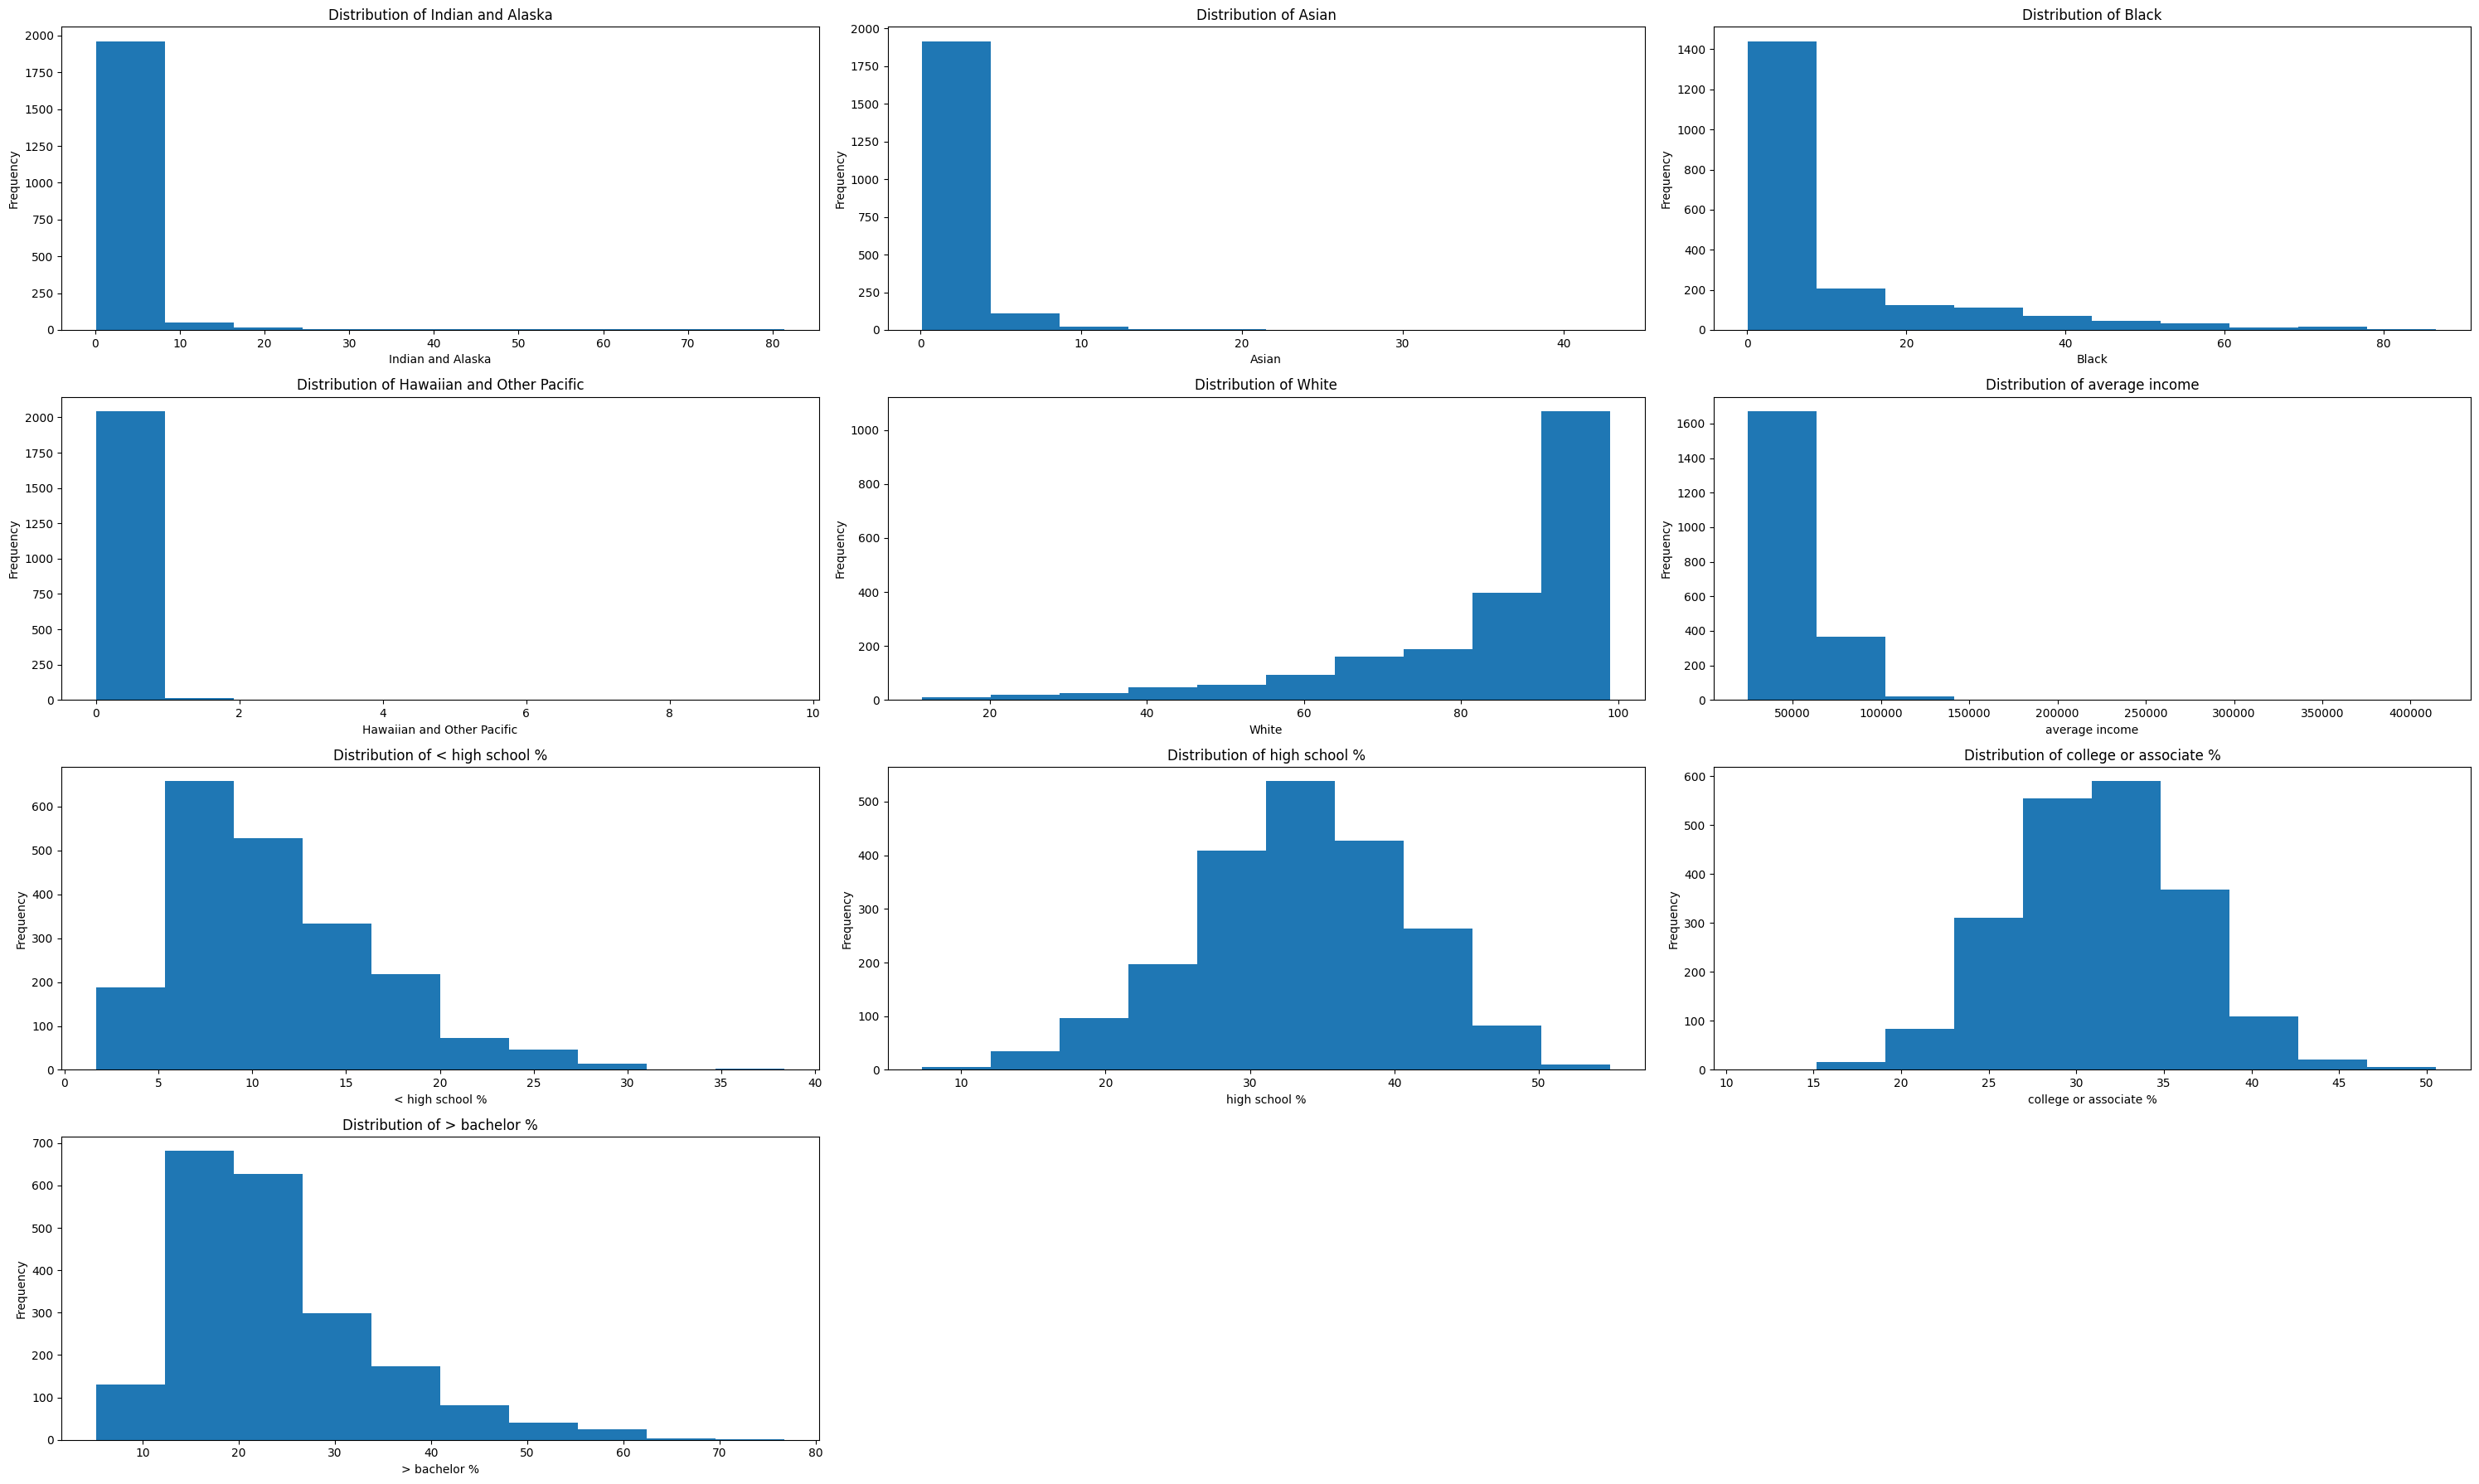

In [74]:
plt.figure(figsize=(30,18))

plt.subplot(4,3,1)
plt.hist(df_reg1['Indian and Alaska'])
plt.title('Distribution of Indian and Alaska')
plt.xlabel('Indian and Alaska')
plt.ylabel('Frequency')

plt.subplot(4,3,2)
plt.hist(df_reg1['Asian'])
plt.title('Distribution of Asian')
plt.xlabel('Asian')
plt.ylabel('Frequency')

plt.subplot(4,3,3)
plt.hist(df_reg1['Black'])
plt.title('Distribution of Black')
plt.xlabel('Black')
plt.ylabel('Frequency')

plt.subplot(4,3,4)
plt.hist(df_reg1['Hawaiian and Other Pacific'])
plt.title('Distribution of Hawaiian and Other Pacific')
plt.xlabel('Hawaiian and Other Pacific')
plt.ylabel('Frequency')

plt.subplot(4,3,5)
plt.hist(df_reg1['White'])
plt.title('Distribution of White')
plt.xlabel('White')
plt.ylabel('Frequency')

plt.subplot(4,3,6)
plt.hist(df_reg1['average income'])
plt.title('Distribution of average income')
plt.xlabel('average income')
plt.ylabel('Frequency')

plt.subplot(4,3,7)
plt.hist(df_reg1['< high school %'])
plt.title('Distribution of < high school %')
plt.xlabel('< high school %')
plt.ylabel('Frequency')

plt.subplot(4,3,8)
plt.hist(df_reg1['high school %'])
plt.title('Distribution of high school %')
plt.xlabel('high school %')
plt.ylabel('Frequency')

plt.subplot(4,3,9)
plt.hist(df_reg1['college or associate %'])
plt.title('Distribution of college or associate %')
plt.xlabel('college or associate %')
plt.ylabel('Frequency')

plt.subplot(4,3,10)
plt.hist(df_reg1['> bachelor %'])
plt.title('Distribution of > bachelor %')
plt.xlabel('> bachelor %')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Conclusion:

* For Race, White are left-skewed and other seems to be right-skewed.

* For Average Income, it looks right-skewed.

* For Education, > bachelor % and < high shcool % seems to be some kind right-skewed.

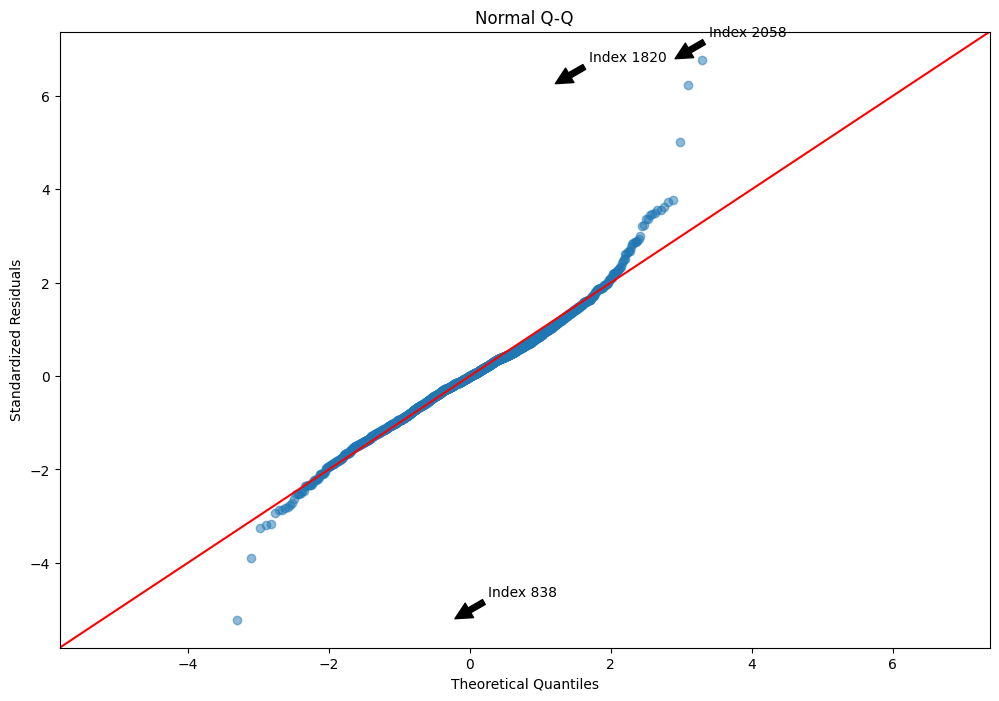

In [75]:
model_fitted_y = model.fittedvalues  # Predicted (fitted) values
model_residuals = model.resid  # Residuals
model_abs_resid = abs(model_residuals)  # Absolute residuals
model_std_residuals = model.get_influence().resid_studentized_internal  # Standardized residuals

# Q-Q plot of standardized residuals
QQ = ProbPlot(model_std_residuals)  
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, lw=1)

# Set figure size and title
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
# Use standardized residuals to find the largest values
abs_norm_resid = np.flip(np.argsort(np.abs(model_std_residuals)), 0)  # Get indices of largest residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# Annotate the top 3 residuals
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(f'Index {i}', 
                               xy=(QQ.theoretical_quantiles[i], model_std_residuals[i]),
                               xytext=(QQ.theoretical_quantiles[i] + 0.5, model_std_residuals[i] + 0.5),
                               arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

Conclusion: 
* The Q-Q plot shows that even though the some individual variables would violate the normality assumption, the regression model can still roughly satisfy the normality assumption. 

After Transformation

In [76]:
# Log Transfer for right-skewed
df_reg1['log Indian and Alaska'] = np.log(df_reg1['Indian and Alaska'] + 1)
df_reg1['log Asian'] = np.log(df_reg1['Asian'] + 1)
df_reg1['log Black'] = np.log(df_reg1['Black'] + 1)
df_reg1['log Hawaiian and Other Pacific'] = np.log(df_reg1['Hawaiian and Other Pacific'] + 1)
df_reg1['log average income'] = np.log(df_reg1['average income'])
df_reg1['log > bachelor %'] = np.log(df_reg1['> bachelor %'])
df_reg1['log < high school %'] = np.log(df_reg1['< high school %'])

# Another way for treating left-skewed
# reverse the skew
white_reversed = df_reg1['White'].max() + df_reg1['White'].min() - df_reg1['White']

# apply a box-cox transformation
white_transformed, _ = boxcox(white_reversed)

df_reg1['Transformed White'] = white_transformed

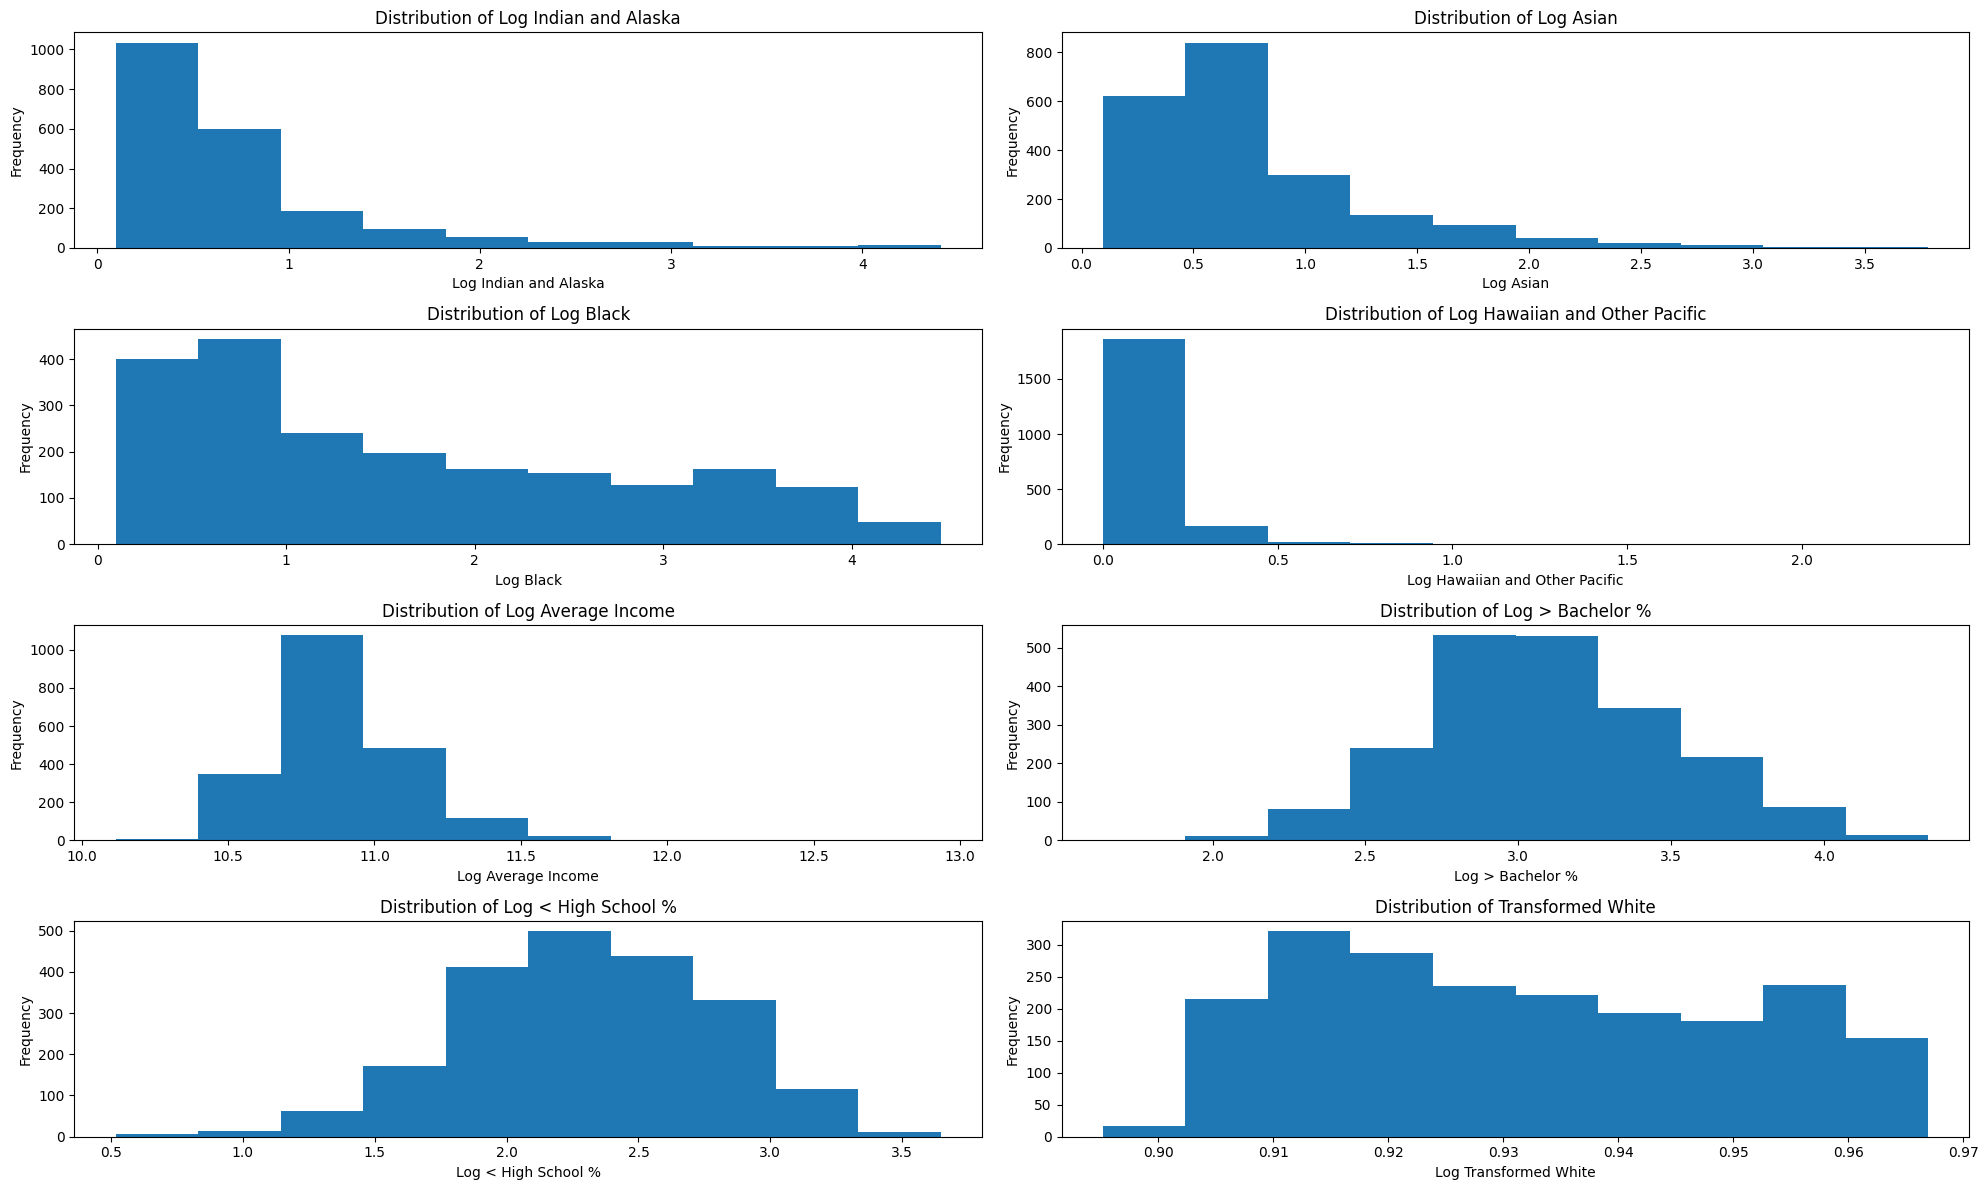

In [77]:
plt.figure(figsize=(20,12))

plt.subplot(4,2,1)
plt.hist(df_reg1['log Indian and Alaska'])
plt.title('Distribution of Log Indian and Alaska')
plt.xlabel('Log Indian and Alaska')
plt.ylabel('Frequency')

plt.subplot(4,2,2)
plt.hist(df_reg1['log Asian'])
plt.title('Distribution of Log Asian')
plt.xlabel('Log Asian')
plt.ylabel('Frequency')

plt.subplot(4,2,3)
plt.hist(df_reg1['log Black'])
plt.title('Distribution of Log Black')
plt.xlabel('Log Black')
plt.ylabel('Frequency')

plt.subplot(4,2,4)
plt.hist(df_reg1['log Hawaiian and Other Pacific'])
plt.title('Distribution of Log Hawaiian and Other Pacific')
plt.xlabel('Log Hawaiian and Other Pacific')
plt.ylabel('Frequency')

plt.subplot(4,2,5)
plt.hist(df_reg1['log average income'])
plt.title('Distribution of Log Average Income')
plt.xlabel('Log Average Income')
plt.ylabel('Frequency')

plt.subplot(4,2,6)
plt.hist(df_reg1['log > bachelor %'])
plt.title('Distribution of Log > Bachelor %')
plt.xlabel('Log > Bachelor %')
plt.ylabel('Frequency')

plt.subplot(4,2,7)
plt.hist(df_reg1['log < high school %'])
plt.title('Distribution of Log < High School %')
plt.xlabel('Log < High School %')
plt.ylabel('Frequency')

plt.subplot(4,2,8)
plt.hist(df_reg1['Transformed White'])
plt.title('Distribution of Transformed White')
plt.xlabel('Log Transformed White')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Conclusion:

* For Race: those right-skewed variables seem to be too right-skewed, even after log transforming, they still show the right-skewed tendency. After transforming White shows some kind of normality here.

* For Income and Education, after transforming, all become more normal.

#### 1.4.3.2 Linearity

Raw Data

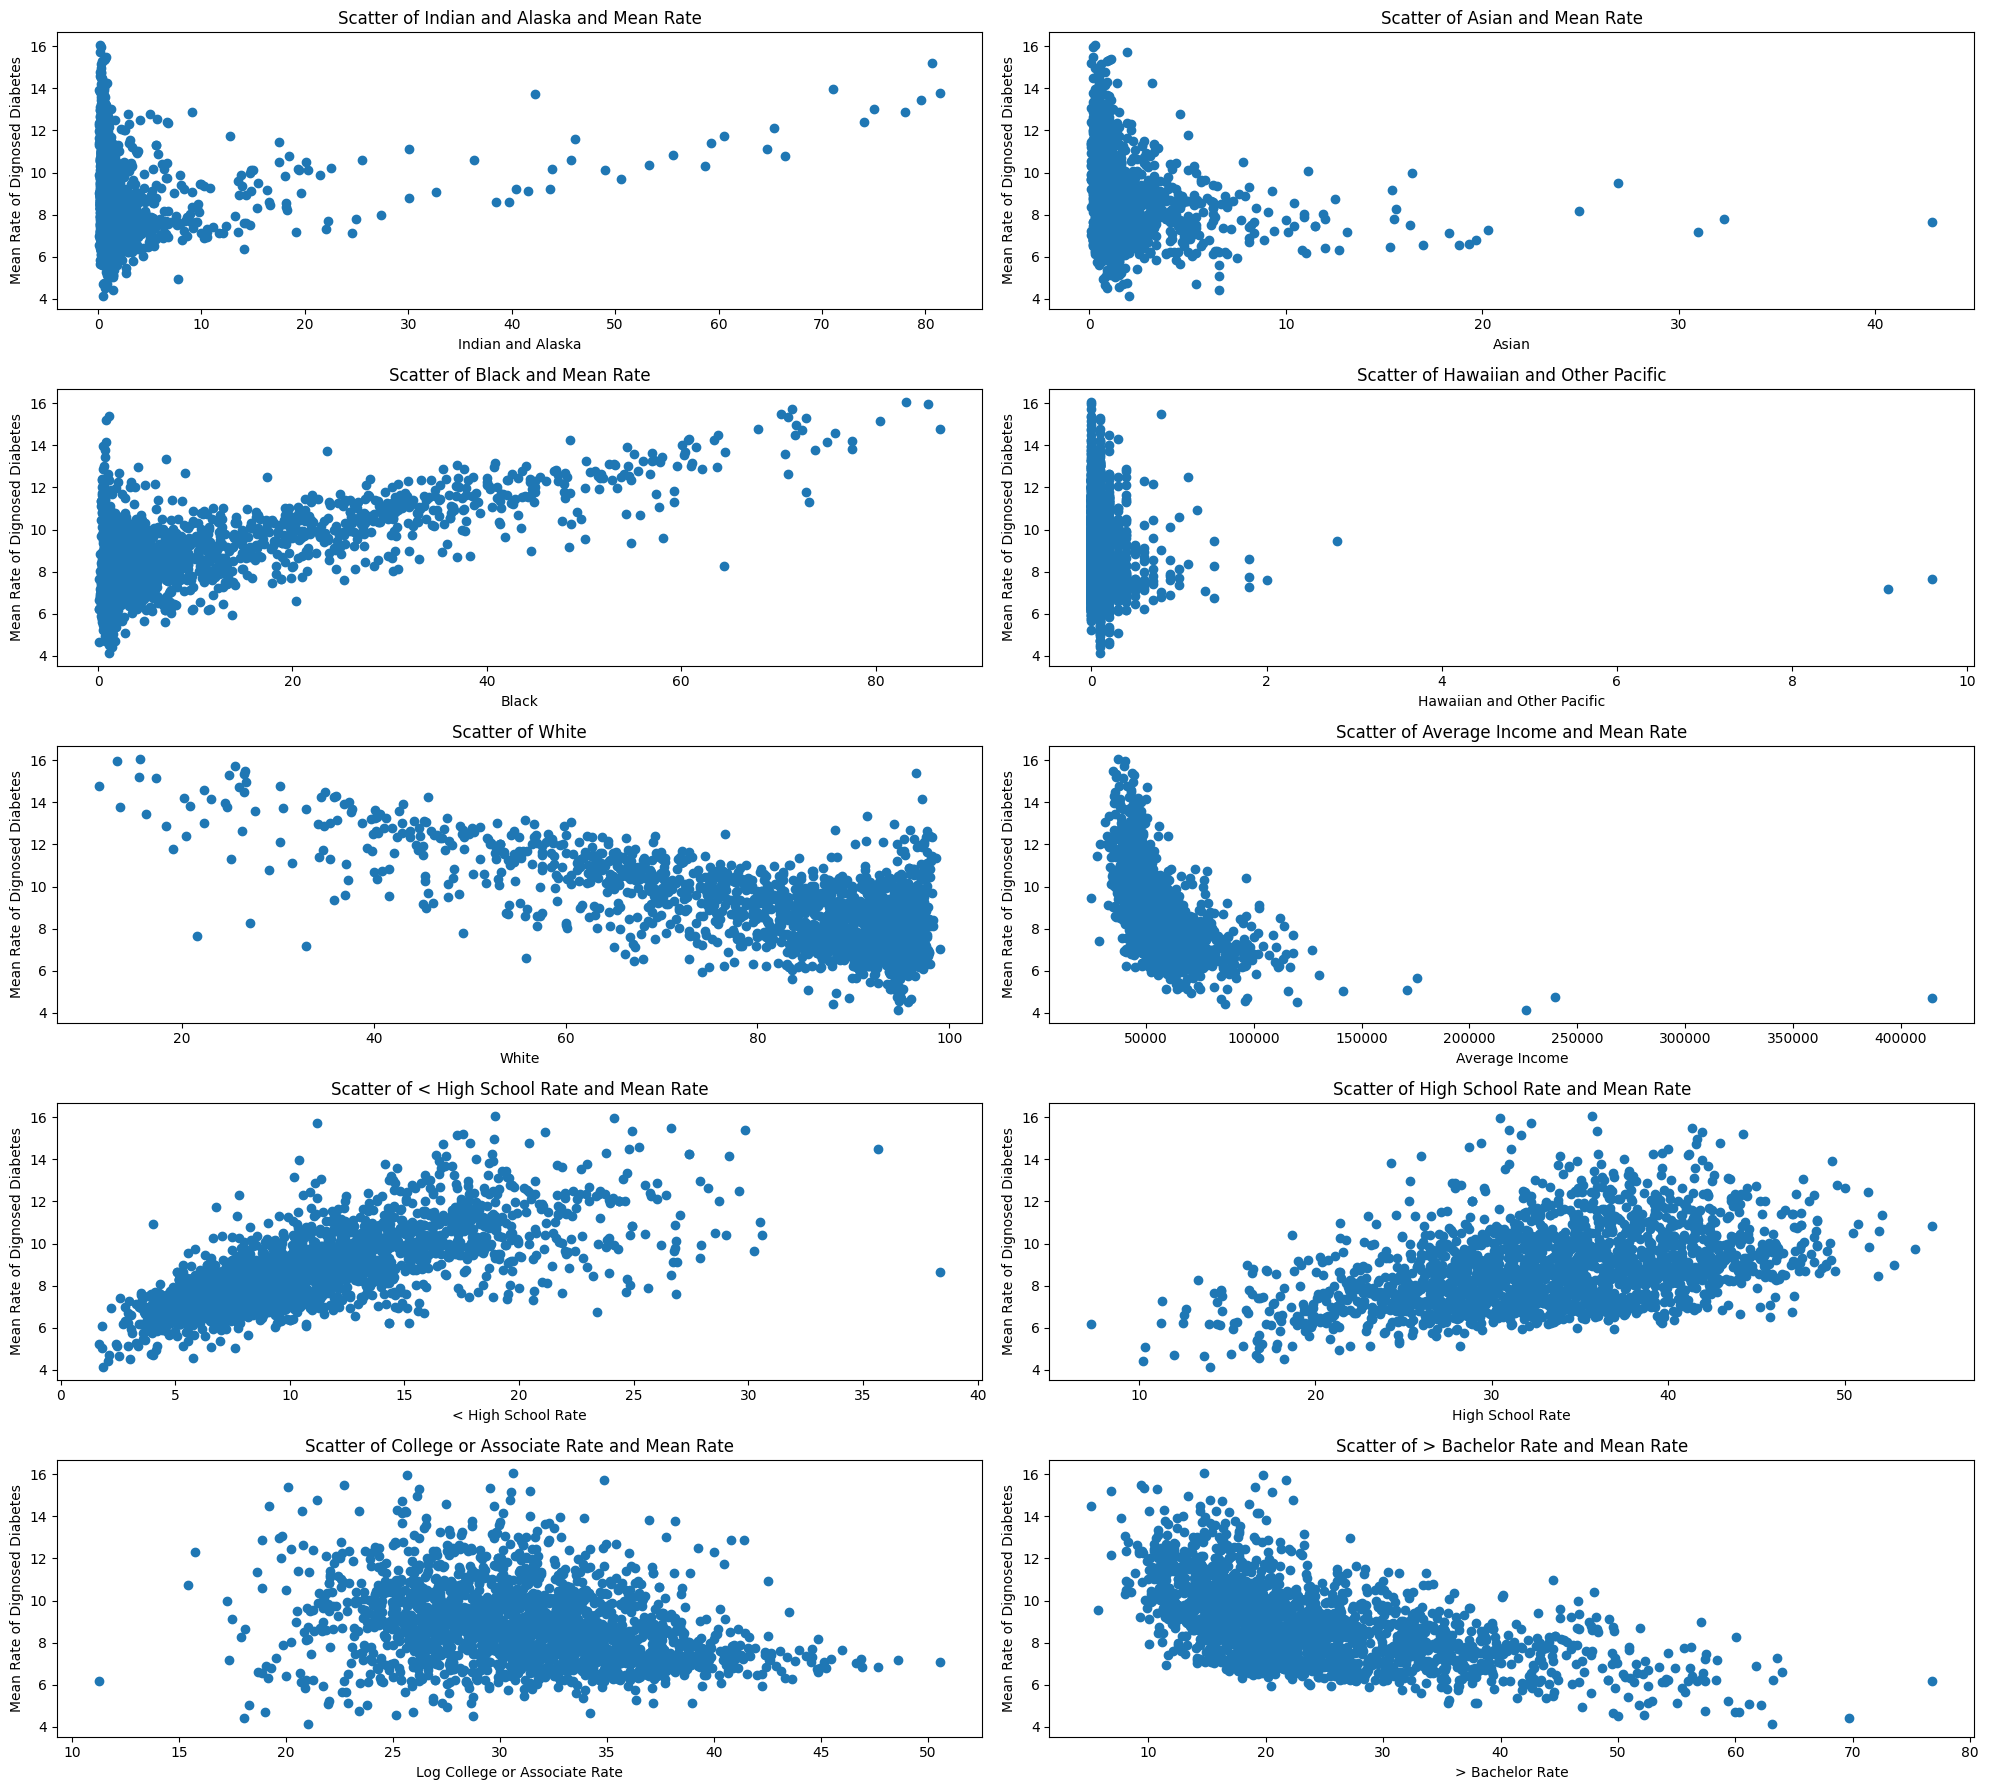

In [78]:
plt.figure(figsize=(20,18))

plt.subplot(5,2,1)
plt.scatter(df_reg1['Indian and Alaska'], df_reg1['mean rate'])
plt.title('Scatter of Indian and Alaska and Mean Rate')
plt.xlabel('Indian and Alaska')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,2)
plt.scatter(df_reg1['Asian'], df_reg1['mean rate'])
plt.title('Scatter of Asian and Mean Rate')
plt.xlabel('Asian')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,3)
plt.scatter(df_reg1['Black'], df_reg1['mean rate'])
plt.title('Scatter of Black and Mean Rate')
plt.xlabel('Black')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,4)
plt.scatter(df_reg1['Hawaiian and Other Pacific'], df_reg1['mean rate'])
plt.title('Scatter of Hawaiian and Other Pacific')
plt.xlabel('Hawaiian and Other Pacific')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,5)
plt.scatter(df_reg1['White'], df_reg1['mean rate'])
plt.title('Scatter of White')
plt.xlabel('White')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,6)
plt.scatter(df_reg1['average income'], df_reg1['mean rate'])
plt.title('Scatter of Average Income and Mean Rate')
plt.xlabel('Average Income')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,7)
plt.scatter(df_reg1['< high school %'], df_reg1['mean rate'])
plt.title('Scatter of < High School Rate and Mean Rate')
plt.xlabel('< High School Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,8)
plt.scatter(df_reg1['high school %'], df_reg1['mean rate'])
plt.title('Scatter of High School Rate and Mean Rate')
plt.xlabel('High School Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,9)
plt.scatter(df_reg1['college or associate %'], df_reg1['mean rate'])
plt.title('Scatter of College or Associate Rate and Mean Rate')
plt.xlabel('Log College or Associate Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,10)
plt.scatter(df_reg1['> bachelor %'], df_reg1['mean rate'])
plt.title('Scatter of > Bachelor Rate and Mean Rate')
plt.xlabel('> Bachelor Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.tight_layout()
plt.show()

Conclusion: 
* For Race, the linearity is not obvious.

* For Income, it does not show too much the linearity here.

* For Education, except College or Assocaite Rate, other variables all shows some kind of linearity here.

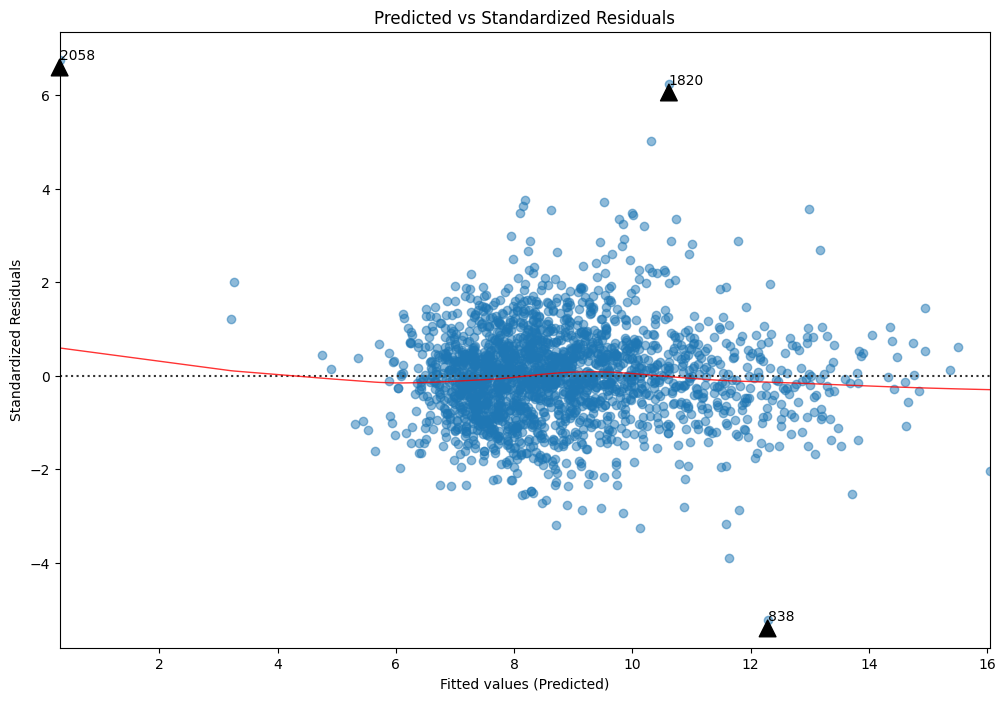

In [79]:
# Create the plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

# Residuals vs Fitted plot
sns.residplot(x=model_fitted_y, y=model_std_residuals, 
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Predicted vs Standardized Residuals')
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
abs_resid_top_3 = model_abs_resid.sort_values(ascending=False)[:3]

for i in abs_resid_top_3.index:
    plt.annotate(i, 
                 xy=(model_fitted_y[i], model_std_residuals[i]),
                 xytext=(model_fitted_y[i], model_std_residuals[i]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()


Conclusion:

* The Residual Plot shows that the model could not pass the linearity assumption.

After Transformation

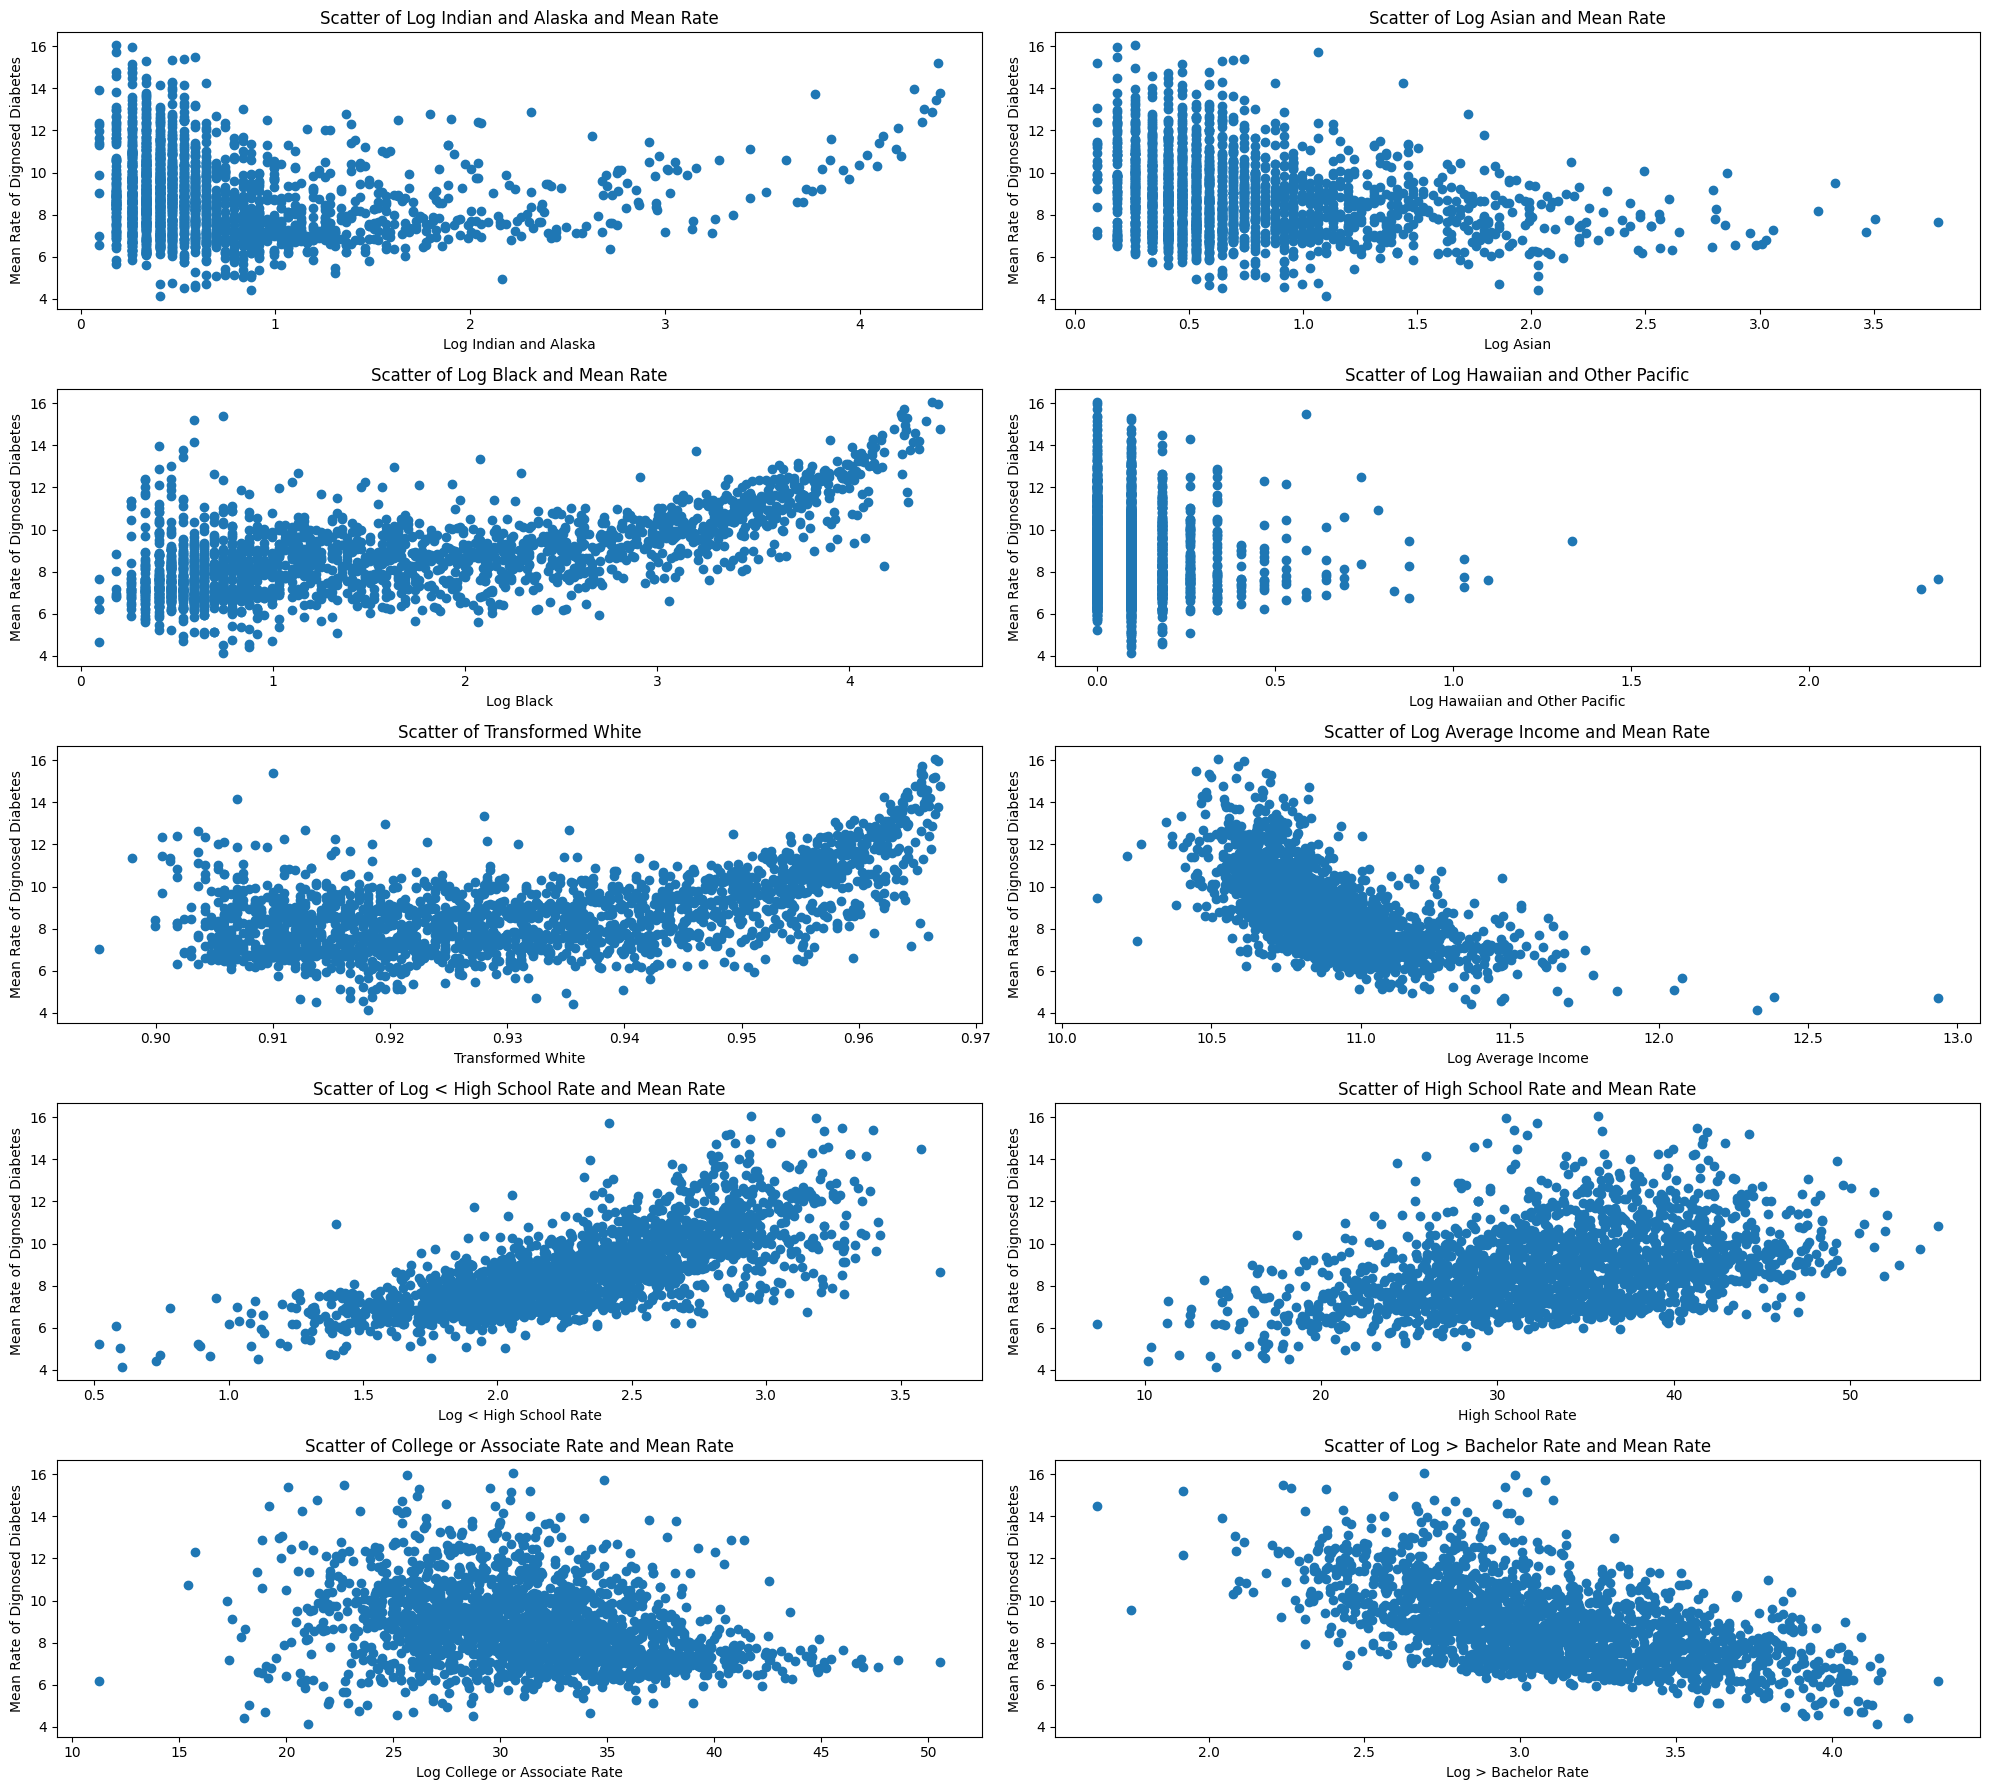

In [80]:
plt.figure(figsize=(20,18))

plt.subplot(5,2,1)
plt.scatter(df_reg1['log Indian and Alaska'], df_reg1['mean rate'])
plt.title('Scatter of Log Indian and Alaska and Mean Rate')
plt.xlabel('Log Indian and Alaska')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,2)
plt.scatter(df_reg1['log Asian'], df_reg1['mean rate'])
plt.title('Scatter of Log Asian and Mean Rate')
plt.xlabel('Log Asian')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,3)
plt.scatter(df_reg1['log Black'], df_reg1['mean rate'])
plt.title('Scatter of Log Black and Mean Rate')
plt.xlabel('Log Black')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,4)
plt.scatter(df_reg1['log Hawaiian and Other Pacific'], df_reg1['mean rate'])
plt.title('Scatter of Log Hawaiian and Other Pacific')
plt.xlabel('Log Hawaiian and Other Pacific')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,5)
plt.scatter(df_reg1['Transformed White'], df_reg1['mean rate'])
plt.title('Scatter of Transformed White')
plt.xlabel('Transformed White')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,6)
plt.scatter(df_reg1['log average income'], df_reg1['mean rate'])
plt.title('Scatter of Log Average Income and Mean Rate')
plt.xlabel('Log Average Income')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,7)
plt.scatter(df_reg1['log < high school %'], df_reg1['mean rate'])
plt.title('Scatter of Log < High School Rate and Mean Rate')
plt.xlabel('Log < High School Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,8)
plt.scatter(df_reg1['high school %'], df_reg1['mean rate'])
plt.title('Scatter of High School Rate and Mean Rate')
plt.xlabel('High School Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,9)
plt.scatter(df_reg1['college or associate %'], df_reg1['mean rate'])
plt.title('Scatter of College or Associate Rate and Mean Rate')
plt.xlabel('Log College or Associate Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.subplot(5,2,10)
plt.scatter(df_reg1['log > bachelor %'], df_reg1['mean rate'])
plt.title('Scatter of Log > Bachelor Rate and Mean Rate')
plt.xlabel('Log > Bachelor Rate')
plt.ylabel('Mean Rate of Dignosed Diabetes')

plt.tight_layout()
plt.show()

Conclusion:

* From linearity perspective, we do not think it is worthwhile for us to do the log transformation here.

#### 1.4.3.3 Multicollinearity

In [81]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

/Users/cherongtian/Desktop/python/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/cherongtian/Desktop/python/.venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variable         VIF
0                        const    0.000000
1            Indian and Alaska   74.953440
2                        Asian   12.174723
3                        Black  288.827169
4   Hawaiian and Other Pacific    2.632683
5                        White  339.175732
6               average income    1.658926
7              < high school %         inf
8                high school %         inf
9       college or associate %         inf
10                > bachelor %         inf

Conclusion:

* Before the transformation, Race and Education shows high Collinearity here and we should try to drop at least one of them.

In [82]:
X_drop = df_reg1[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'average income', 
             '< high school %','high school %', '> bachelor %']]
# drop White and College or Associate rate here
vif_data = pd.DataFrame()
vif_data["Variable"] = X_drop.columns
vif_data["VIF"] = [variance_inflation_factor(X_drop.values, i) for i in range(X_drop.shape[1])]
vif_data

Variable        VIF
0           Indian and Alaska   1.126420
1                       Asian   2.699922
2                       Black   1.809992
3  Hawaiian and Other Pacific   1.562654
4              average income  17.871933
5             < high school %   8.255098
6               high school %  13.180965
7                > bachelor %  13.839442

Conclusion: 

* After dropping White for Race and college or associate % for Education, those variables for Race do not show collinearity but other variables still show the collinearity.

* The VIF for average income switch from 1.66 to 17.87, indicating that after dropping the 2 variables, average income shows some collinearity with other variables.

* Things become some kind of more complicates that we do not sure if we should do the drop here.

#### 1.4.3.4 Constant Variance

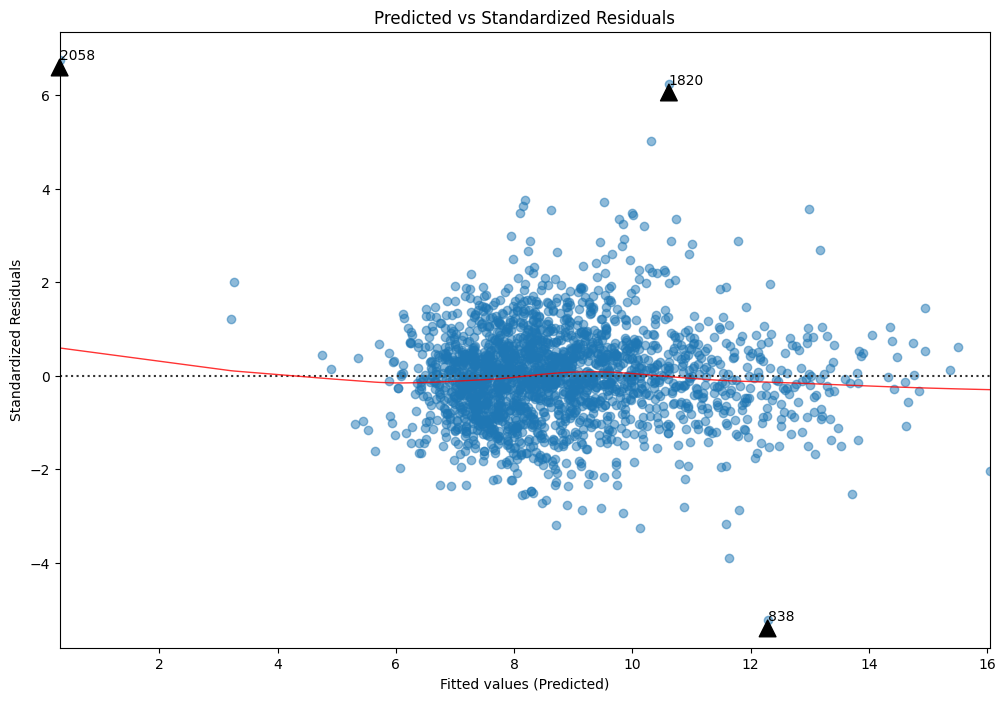

In [83]:
# Create the plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

# Residuals vs Fitted plot
sns.residplot(x=model_fitted_y, y=model_std_residuals, 
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Predicted vs Standardized Residuals')
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
abs_resid_top_3 = model_abs_resid.sort_values(ascending=False)[:3]

for i in abs_resid_top_3.index:
    plt.annotate(i, 
                 xy=(model_fitted_y[i], model_std_residuals[i]),
                 xytext=(model_fitted_y[i], model_std_residuals[i]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()


Conclusion:

* The residual plot shows that the regression model could not satisfy the constant variance assumption.

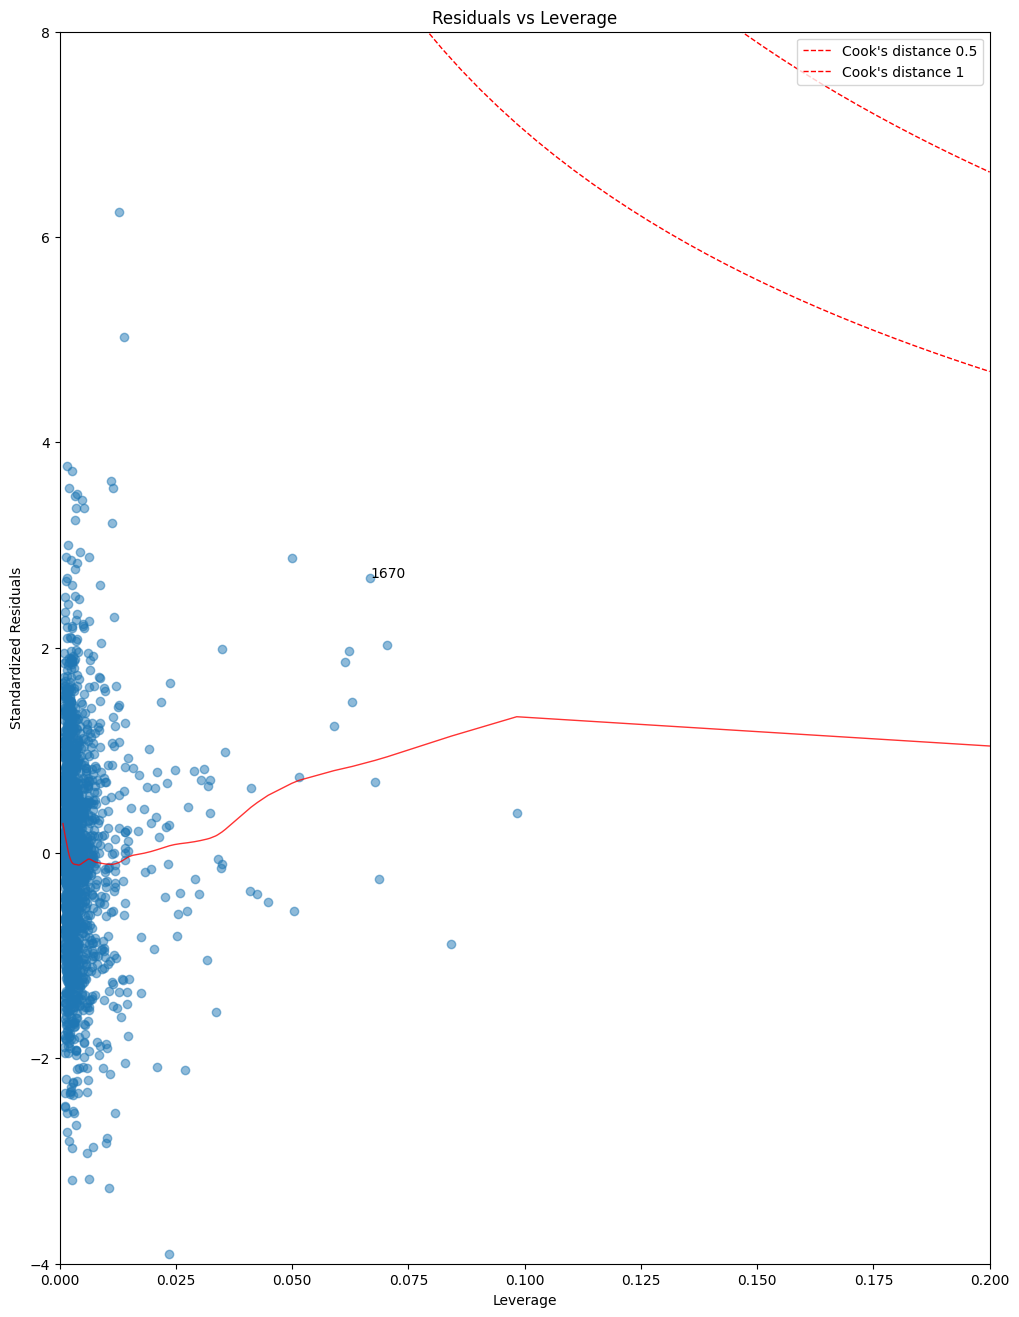

In [84]:
influence = model.get_influence()
model_leverage = influence.hat_matrix_diag
model_norm_residuals = influence.resid_studentized_internal
model_cooks = influence.cooks_distance[0]

# Create the leverage plot as described
plot_lm_4 = plt.figure(1)
plot_lm_4.set_figheight(16)
plot_lm_4.set_figwidth(12)

# Scatter plot for leverage vs residuals
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)

# Use sns.regplot to add a lowess line (fit is False for regplot to avoid conflict)
sns.regplot(x=model_leverage, y=model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.2)
plot_lm_4.axes[0].set_ylim(-4, 8)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# Annotations for the top 3 leverage points
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))

# Function for Cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model.params)  # Number of parameters in the model

# Plot Cook's distance contours
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance 0.5')

graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance 1')

plt.legend(loc='upper right')

# Show the plot
plt.show()

Conclusion:

* There is no plot above the Cook's Distance 1, showing there is no influencial outliers.

#### 1.4.3.5 Independence

In [85]:
# Durbin-Watson test
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.434335333804178


Conclusion:

* DW statistic 1.434 suggests positive autocorrelation in the residuals, as the value is below 2 but above 1, which could indicate that:
    1. Residuals are not independent.
    2. Observations may have a temporal or spatial structure.

#### 1.4.3.6 Assumption Check Conclusion for First Regression before Transformation

1. Normality: Even some variables cannot satisfy the normality assumption, but the Q-Q plot shows that the model could roughly satisfy the normality assumption.

2. Linearty: Almost half of the variables could not satisfy the linearity assumption and the residual plot shows that the model could not satisfy the linearity assumption, even after the log transformation.

3. Multicollinearity: The VIF shows that variables for race and education cannot satisfy the multicollinearity assumption and we should drop one of them for each and recheck. But after dropping, the situation seems to become more complicated.

4. Constant Variance: Since there is no plot above the Cook's Distance 1 line, there are no influencial outliers. But according to the residual plot, the model still could not satisfy the constant variance assumption.

5. Independence: The DW statistic is about 1.43, which is a little bit from 2 (ideal number), indicating positive autocorrelation.

### 1.4.4 Model Adjustment

#### 1.4.4.1 Log Transform Average Income

In [86]:
X_log = df_reg1[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White',
                'log average income', '< high school %','high school %', 'college or associate %',
                '> bachelor %']]

y = df_reg1['mean rate']

X_log = sm.add_constant(X_log)
model_log = sm.OLS(y, X_log).fit()

print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1154.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:28   Log-Likelihood:                -2335.7
No. Observations:                2062   AIC:                             4691.
Df Residuals:                    2052   BIC:                             4748.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* Coefficient for log average income looks more reasonable, showing that our guess above should be correct.

* R-squared increases and AIC & BIC decreases some kind, showing that after transformation, the goodness of fit for the model improves.

* P-values here changed, but the conclusion is still the same.

#### 1.4.4.2 Recheck Multicollinearity

In [87]:
X_log = df_reg1[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White', 'log average income', 
                      '< high school %','high school %', 'college or associate %', '> bachelor %']]
# drop White and College or Associate rate here
vif_data = pd.DataFrame()
vif_data["Variable"] = X_log.columns
vif_data["VIF"] = [variance_inflation_factor(X_log.values, i) for i in range(X_log.shape[1])]
vif_data

Variable          VIF
0           Indian and Alaska    75.183188
1                       Asian    12.269363
2                       Black   289.809356
3  Hawaiian and Other Pacific     2.630816
4                       White   340.689701
5          log average income     2.077031
6             < high school %   235.786832
7               high school %  1730.099766
8      college or associate %  1480.572763
9                > bachelor %  1054.258913

Conclusion:

* After log transformation, there is still strong collinearity among variables for Race and Education.

#### 1.4.4.3 Recheck Normality

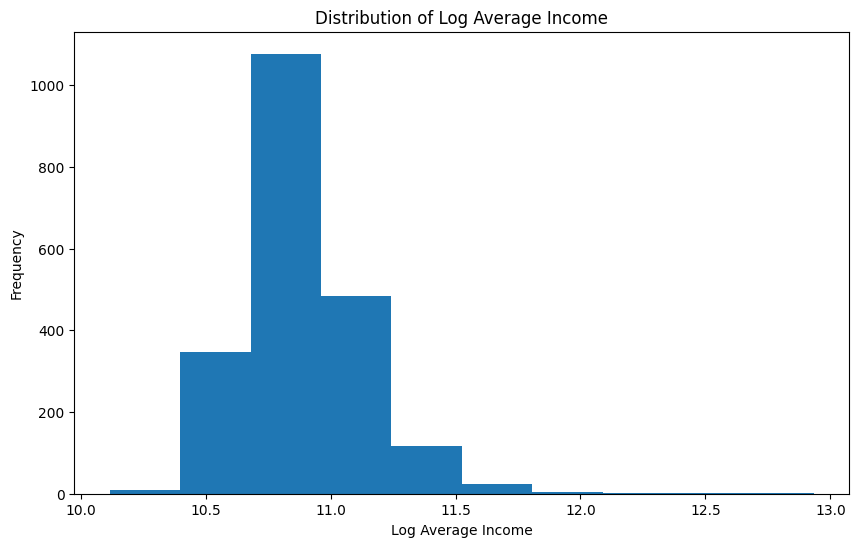

In [88]:
plt.figure(figsize=(10,6))
plt.hist(df_reg1['log average income'])
plt.title('Distribution of Log Average Income')
plt.xlabel('Log Average Income')
plt.ylabel('Frequency')
plt.show()

Conclusion:

* After log transformation, the distribution looks more normal.

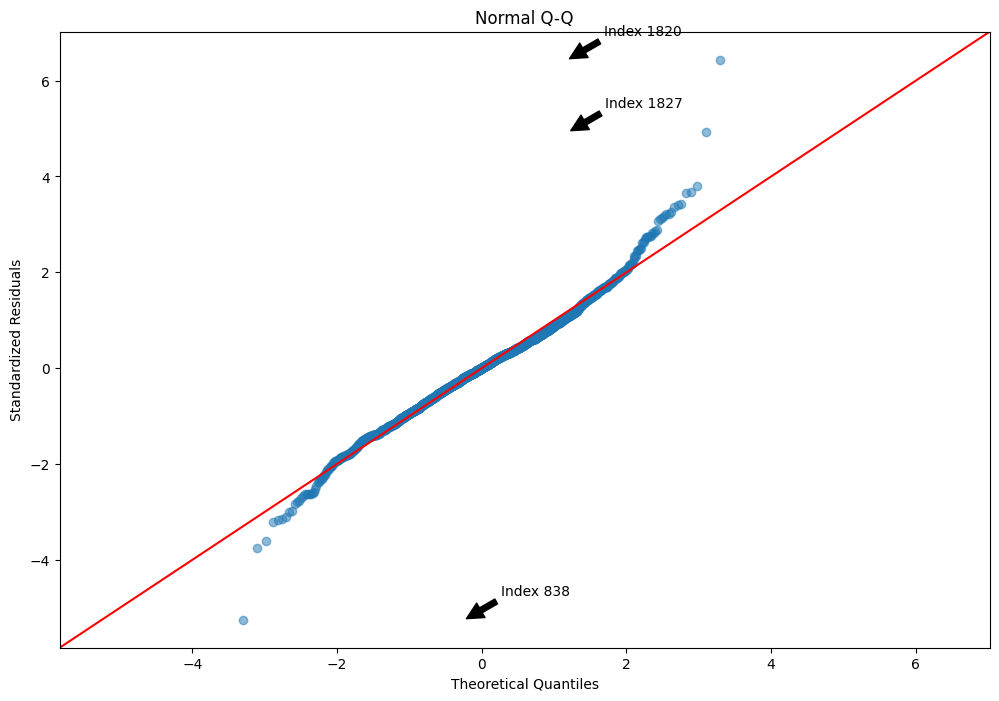

In [89]:
model_fitted_y = model_log.fittedvalues  # Predicted (fitted) values
model_residuals = model_log.resid  # Residuals
model_abs_resid = abs(model_residuals)  # Absolute residuals
model_std_residuals = model_log.get_influence().resid_studentized_internal  # Standardized residuals

# Q-Q plot of standardized residuals
QQ = ProbPlot(model_std_residuals)  
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, lw=1)

# Set figure size and title
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
# Use standardized residuals to find the largest values
abs_norm_resid = np.flip(np.argsort(np.abs(model_std_residuals)), 0)  # Get indices of largest residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# Annotate the top 3 residuals
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(f'Index {i}', 
                               xy=(QQ.theoretical_quantiles[i], model_std_residuals[i]),
                               xytext=(QQ.theoretical_quantiles[i] + 0.5, model_std_residuals[i] + 0.5),
                               arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

Conclusion:
* According to the Q-Q plot, the model could still roughly satisfy the normality assumption

#### 1.4.4.4 Recheck Linearity

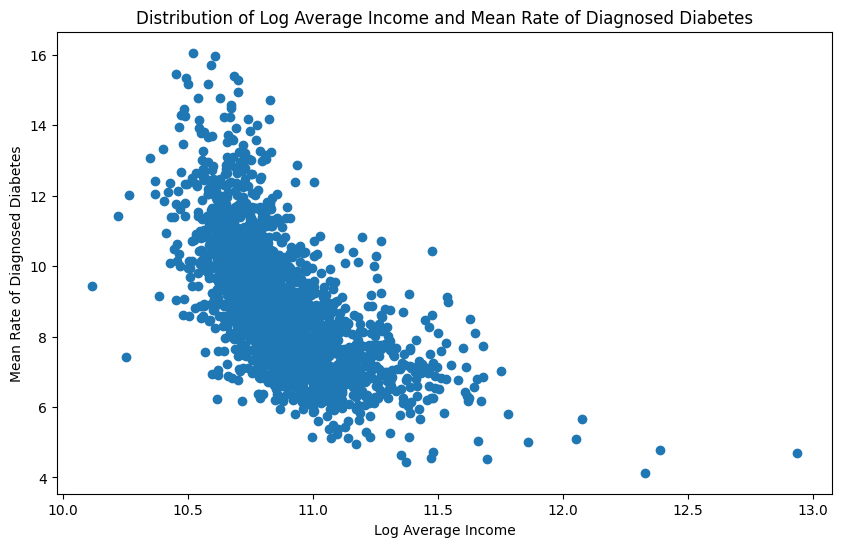

In [90]:
plt.figure(figsize=(10,6))
plt.scatter(df_reg1['log average income'], df_reg1['mean rate'])
plt.title('Distribution of Log Average Income and Mean Rate of Diagnosed Diabetes')
plt.xlabel('Log Average Income')
plt.ylabel('Mean Rate of Diagnosed Diabetes')
plt.show()

Conclusion:

* After log transformation, the linearity is still not obvious.

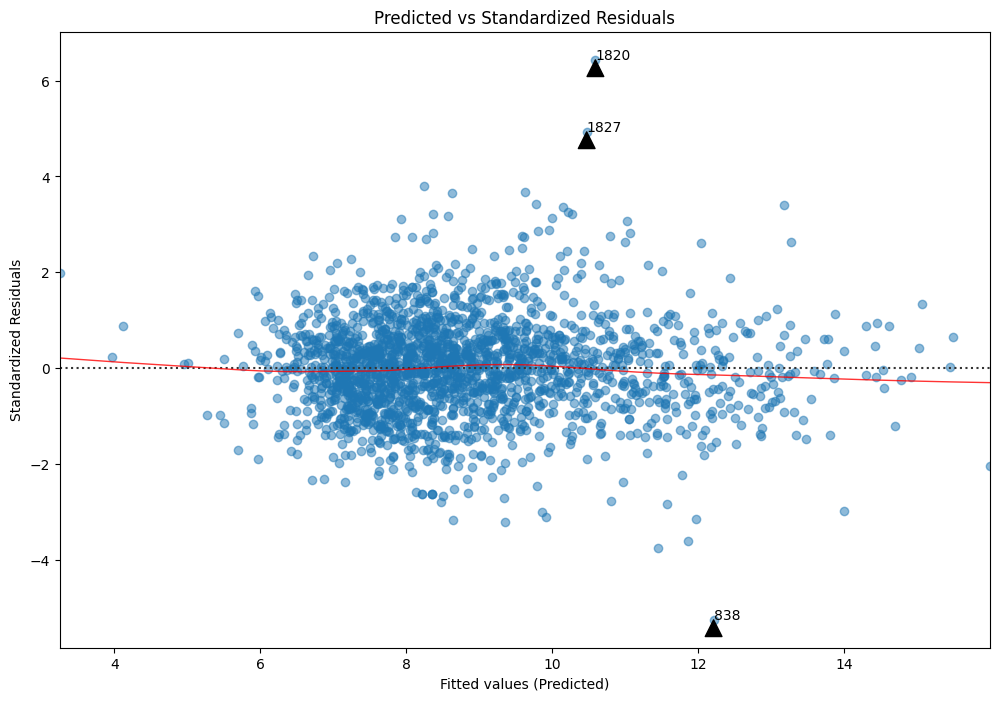

In [91]:
# Create the plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

# Residuals vs Fitted plot
sns.residplot(x=model_fitted_y, y=model_std_residuals, 
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Predicted vs Standardized Residuals')
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
abs_resid_top_3 = model_abs_resid.sort_values(ascending=False)[:3]

for i in abs_resid_top_3.index:
    plt.annotate(i, 
                 xy=(model_fitted_y[i], model_std_residuals[i]),
                 xytext=(model_fitted_y[i], model_std_residuals[i]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()


Conclusion:

* After log transformation average income, the model seems still cannot satisfy the linearity assumption.

#### 1.4.4.5 Recheck Constance Variance

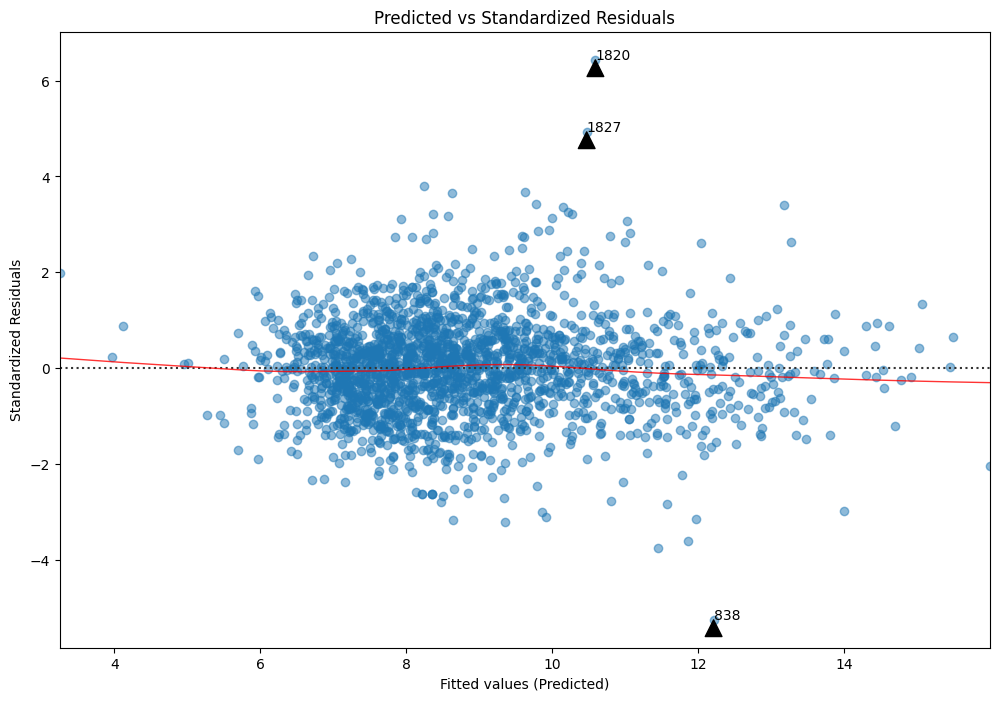

In [92]:
# Create the plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

# Residuals vs Fitted plot
sns.residplot(x=model_fitted_y, y=model_std_residuals, 
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Predicted vs Standardized Residuals')
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
abs_resid_top_3 = model_abs_resid.sort_values(ascending=False)[:3]

for i in abs_resid_top_3.index:
    plt.annotate(i, 
                 xy=(model_fitted_y[i], model_std_residuals[i]),
                 xytext=(model_fitted_y[i], model_std_residuals[i]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()


Conclusion:

* After transformation, the model still could not satisfy the constant variance assumption.

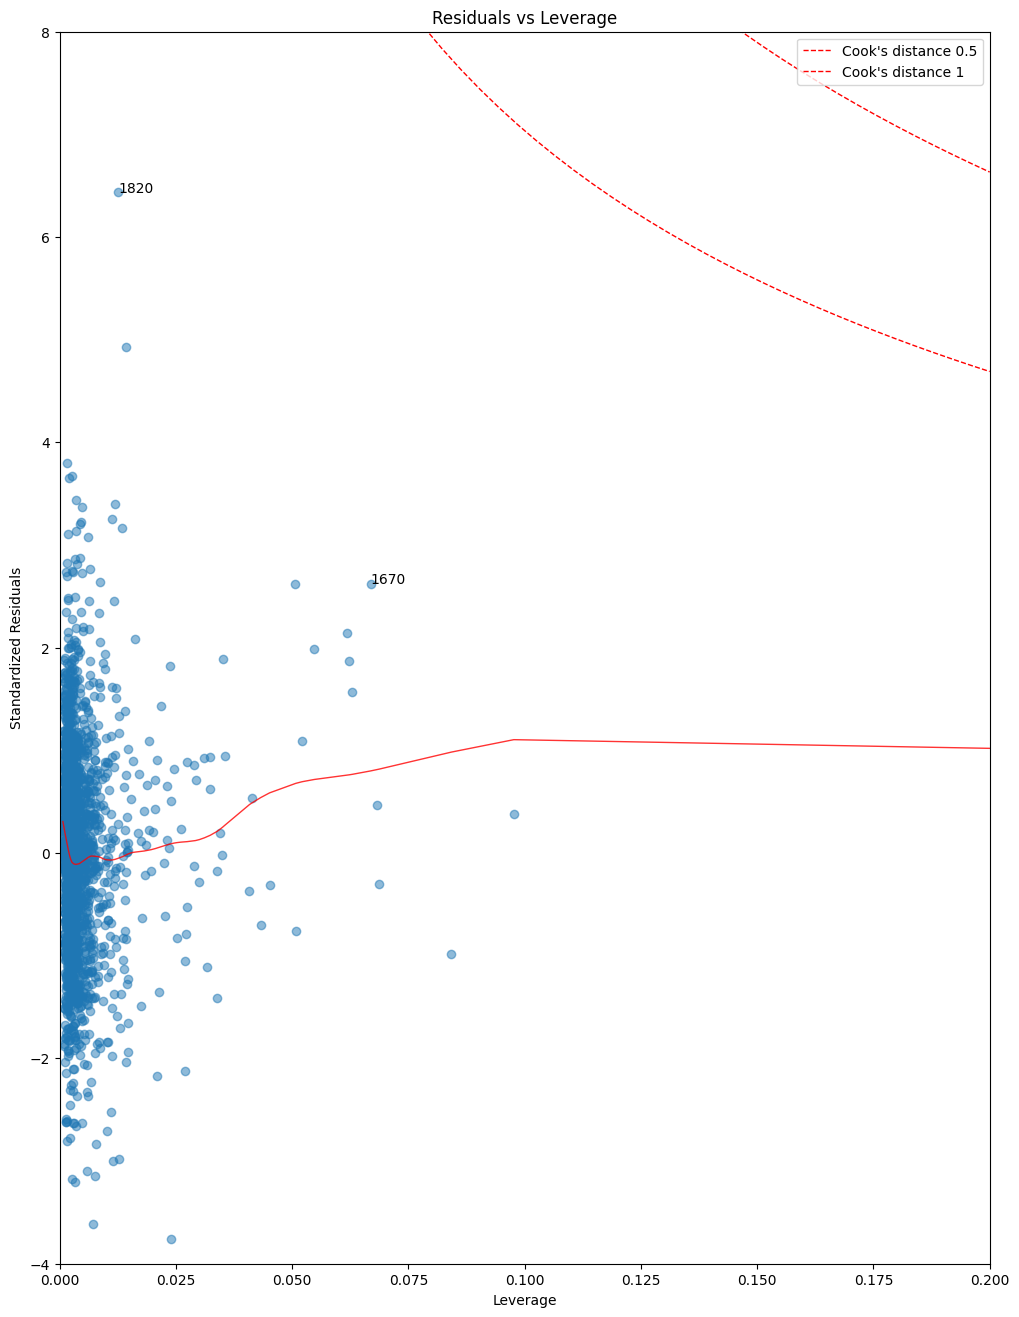

In [93]:
influence = model_log.get_influence()
model_leverage = influence.hat_matrix_diag
model_norm_residuals = influence.resid_studentized_internal
model_cooks = influence.cooks_distance[0]

# Create the leverage plot as described
plot_lm_4 = plt.figure(1)
plot_lm_4.set_figheight(16)
plot_lm_4.set_figwidth(12)

# Scatter plot for leverage vs residuals
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)

# Use sns.regplot to add a lowess line (fit is False for regplot to avoid conflict)
sns.regplot(x=model_leverage, y=model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.2)
plot_lm_4.axes[0].set_ylim(-4, 8)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# Annotations for the top 3 leverage points
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))

# Function for Cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model.params)  # Number of parameters in the model

# Plot Cook's distance contours
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance 0.5')

graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance 1')

plt.legend(loc='upper right')

# Show the plot
plt.show()

Conclusion:

* There is no plot above the line of Cook's Distance 1, meaning there are no influencial outliers for the model.

#### 1.4.4.6 Recheck Independence

In [94]:
# Durbin-Watson test
dw_stat = durbin_watson(model_log.resid)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.433483190684177


Conclusion:

* The DW statistic does not change much, showing that the independence is still not ideal enough here.

#### 1.4.4.7 Further Adjustment: Dropping

In [95]:
X_log_drop = df_reg1[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'log average income', 
                      '< high school %','high school %', '> bachelor %']]

y = df_reg1['mean rate']

X_log_drop = sm.add_constant(X_log_drop)
model_log_drop = sm.OLS(y, X_log_drop).fit()

print(model_log_drop.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1299.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:29   Log-Likelihood:                -2335.7
No. Observations:                2062   AIC:                             4689.
Df Residuals:                    2053   BIC:                             4740.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* The R-squared and AIC & BIC seems to be almost stable here, so it is not worthwhile to drop from the perspective of goodness of fit for the model.

* So we could keep the model for just log transformation average income.

### 1.4.5 Conclusion for Regression

In [96]:
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1154.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:29   Log-Likelihood:                -2335.7
No. Observations:                2062   AIC:                             4691.
Df Residuals:                    2052   BIC:                             4748.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* R-squred: R-squared is 0.835, showing the model is good fitting the data.

* P-value: P-value for the model is 0.00, which smaller than alpha, 0.05, indicating there is a significant relationship between mean dignosed diabetes rate and those 3 predictors.

* Individual P-values: The P-values among those predictors are smaller than 0.05 except Asian, Hawaiian and Other Pacific and White, showing all of those predictors are significant except those 3 predictors.

* Coeffecient: The coefficient here are positive, except Hawaiian and Other Pacific and log average income, showing there have negative relationship with the mean rate of diagnosed diabetes rate and other variables have the postive relationship.

# 2. Forward Selection

For this selction, we would explore if grocery density is a significant variable to diagnosed diabetes rate accounting for predictors like race, income and education.

## 2.1 Grocery Density

### Dependent Variable

The dependent variable (y) here is the mean diagnosed diabetes rate.

### Independent Variables

The independent variables (Xs) here are the rate, income, education and grocery density.

### Hypothesis

Hypothesis for the Forward Selection model:

$\begin{cases}
H_0: \text{The addition of the variable, grocery density does not provide a statistically significant explanation for variations in the diagnosed diabetes rate after accounting for race, education, and income.}\\
H_1: \text{The addition of the variable, grocery density does provide a statistically significant explanation for variations in the diagnosed diabetes rate after accounting for race, education, and income.}\\
\end{cases}$

### 2.1.1 Import Data 

In [97]:
path_grocery = Path('cbp22co.txt.zip')
with zipfile.ZipFile(path_grocery, 'r') as zip_ref:
    txt_file = 'cbp22co.txt'
    
    # Open the file inside the ZIP and read it into a DataFrame
    with zip_ref.open(txt_file) as file:
        df_grocery = pd.read_csv(file, delimiter=',')

### 2.1.2 Observe Data

In [98]:
df_grocery

fipstate  fipscty   naics emp_nf    emp qp1_nf     qp1 ap_nf      ap  \
0               1        1  ------      G  12409      G  117103     G  496158   
1               1        1  11----      G     52      G     793     G    3477   
2               1        1  113///      H     39      G     686     G    2890   
3               1        1  1133//      H     39      G     686     G    2890   
4               1        1  11331/      H     39      G     686     G    2890   
...           ...      ...     ...    ...    ...    ...     ...   ...     ...   
1100799        56      999  81321/      G      6      H      99     H     463   
1100800        56      999  813212      G      6      H      99     H     463   
1100801        56      999  8133//      J     12      J     309     J    1245   
1100802        56      999  81331/      J     12      J     309     J    1245   
1100803        56      999  813312      J     12      J     309     J    1245   

         est  ... n20_49 n50_99 n100_249 n250_499 n500_999 n1000 n1000_1  \
0        948  ...    102     33       10        3        N     N       N   
1         10  ...      N      N        N        N        N     N       N   
2          7  ...      N      N        N        N        N     N       N   
3          7  ...      N      N        N        N        N     N       N   
4          7  ...      N      N        N        N        N     N       N   
...      ...  ...    ...    ...      ...      ...      ...   ...     ...   
1100799    3  ...      N      N        N        N        N     N       N   
1100800    3  ...      N      N        N        N        N     N       N   
1100801    3  ...      N      N        N        N        N     N       N   
1100802    3  ...      N      N        N        N        N     N       N   
1100803    3  ...      N      N        N        N        N     N       N   

        n1000_2 n1000_3 n1000_4  
0             N       N       N  
1             N       N       N  
2             N       N       N  
3             N       N       N  
4             N       N       N  
...         ...     ...     ...  
1100799       N       N       N  
1100800       N       N       N  
1100801       N       N       N  
1100802       N       N       N  
1100803       N       N       N  

[1100804 rows x 23 columns]

### 2.1.3 Processing Data

In [99]:
df_grocery['numeric_naics'] = df_grocery['naics'].str.replace(r'\D', '', regex=True)    # to make sure those /,- would not impact the result
df_grocery = df_grocery[df_grocery['numeric_naics'] == '445110']    # 445110 represents grocery
df_grocery = df_grocery[['fipstate', 'fipscty', 'naics','est']].reset_index().drop('index', axis=1) # keep columns we need
df_grocery

fipstate  fipscty   naics  est
0            1        1  445110    4
1            1        3  445110   30
2            1        5  445110    5
3            1        7  445110    4
4            1        9  445110    4
...        ...      ...     ...  ...
2224        56       33  445110    6
2225        56       35  445110    3
2226        56       37  445110    5
2227        56       39  445110    9
2228        56       45  445110    4

[2229 rows x 4 columns]

In [100]:
df_grocery['fips'] = df_grocery['fipstate'].astype(str) + df_grocery['fipscty'].apply(lambda x: f"{int(x):03}") 
# combine the stacty fips, uniform the style with other data
df_grocery = df_grocery[['fips', 'est']]    # keep columns we need
df_grocery

fips  est
0      1001    4
1      1003   30
2      1005    5
3      1007    4
4      1009    4
...     ...  ...
2224  56033    6
2225  56035    3
2226  56037    5
2227  56039    9
2228  56045    4

[2229 rows x 2 columns]

In [101]:
df_grocery.isnull().sum()

fips    0
est     0
dtype: int64

In [102]:
df_grocery.describe()

est
count  2229.000000
mean     27.541498
std      93.133587
min       3.000000
25%       4.000000
50%       7.000000
75%      18.000000
max    1960.000000

In [103]:
df_grocery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fips    2229 non-null   object
 1   est     2229 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.0+ KB


In [104]:
df_grocery = df_grocery.copy()
df_grocery['fips'] = df_grocery['fips'].astype(str)
df_grocery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fips    2229 non-null   object
 1   est     2229 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.0+ KB


Conclusion: 

1. Here we need another data to transfer the fips to the exact location.

2. In order to get the grocery density (number of groceries per million people own), we also need data for population in one location. 

### 2.1.4 Data for County

#### 2.1.4.1 Import Data

In [105]:
path_county = Path('uscounties.csv')
df_county = pd.read_csv(path_county)

#### 2.1.4.2 Observe Data

In [106]:
df_county

county county_ascii         county_full  county_fips state_id  \
0     Los Angeles  Los Angeles  Los Angeles County         6037       CA   
1            Cook         Cook         Cook County        17031       IL   
2          Harris       Harris       Harris County        48201       TX   
3        Maricopa     Maricopa     Maricopa County         4013       AZ   
4       San Diego    San Diego    San Diego County         6073       CA   
...           ...          ...                 ...          ...      ...   
3139       Blaine       Blaine       Blaine County        31009       NE   
3140         King         King         King County        48269       TX   
3141       Kenedy       Kenedy       Kenedy County        48261       TX   
3142       Loving       Loving       Loving County        48301       TX   
3143      Kalawao      Kalawao      Kalawao County        15005       HI   

      state_name      lat       lng  population  
0     California  34.3219 -118.2247     9936690  
1       Illinois  41.8401  -87.8168     5225367  
2          Texas  29.8578  -95.3938     4726177  
3        Arizona  33.3490 -112.4915     4430871  
4     California  33.0343 -116.7350     3289701  
...          ...      ...       ...         ...  
3139    Nebraska  41.9128  -99.9768         384  
3140       Texas  33.6165 -100.2558         216  
3141       Texas  26.9285  -97.7017         116  
3142       Texas  31.8493 -103.5800          96  
3143      Hawaii  21.1709 -156.9475          50  

[3144 rows x 9 columns]

#### 2.1.4.3 Processing Data

In [107]:
df_county = df_county[['county', 'county_fips', 'state_id', 'population']]  # keep columns we need
df_county.columns = ['county', 'fips', 'state', 'population']   # rename columns for future merge
df_county

county   fips state  population
0     Los Angeles   6037    CA     9936690
1            Cook  17031    IL     5225367
2          Harris  48201    TX     4726177
3        Maricopa   4013    AZ     4430871
4       San Diego   6073    CA     3289701
...           ...    ...   ...         ...
3139       Blaine  31009    NE         384
3140         King  48269    TX         216
3141       Kenedy  48261    TX         116
3142       Loving  48301    TX          96
3143      Kalawao  15005    HI          50

[3144 rows x 4 columns]

In [108]:
df_county.isnull().sum()

county        0
fips          0
state         0
population    0
dtype: int64

In [109]:
df_county.describe()

fips    population
count   3144.000000  3.144000e+03
mean   30368.187023  1.053109e+05
std    15170.427484  3.337924e+05
min     1001.000000  5.000000e+01
25%    18174.500000  1.083575e+04
50%    29174.000000  2.578450e+04
75%    45079.500000  6.807975e+04
max    56045.000000  9.936690e+06

In [110]:
df_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   county      3144 non-null   object
 1   fips        3144 non-null   int64 
 2   state       3144 non-null   object
 3   population  3144 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 98.4+ KB


In [111]:
df_county = df_county.copy()
df_county['fips'] = df_county['fips'].astype(str)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   county      3144 non-null   object
 1   fips        3144 non-null   object
 2   state       3144 non-null   object
 3   population  3144 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 98.4+ KB


### 2.1.5 Futher Processing

In [112]:
df_density = pd.merge(df_grocery, df_county, on=['fips'])
df_density

fips  est      county state  population
0      1001    4     Autauga    AL       58761
1      1003   30     Baldwin    AL      233420
2      1005    5     Barbour    AL       24877
3      1007    4        Bibb    AL       22251
4      1009    4      Blount    AL       59077
...     ...  ...         ...   ...         ...
2224  56033    6    Sheridan    WY       31176
2225  56035    3    Sublette    WY        8801
2226  56037    5  Sweetwater    WY       42079
2227  56039    9       Teton    WY       23346
2228  56045    4      Weston    WY        6870

[2229 rows x 5 columns]

In [113]:
df_density['density'] = df_density['est'] / df_density['population'] * 1000000
df_density = df_density[['county', 'state', 'density']]
df_density

county state     density
0        Autauga    AL   68.072361
1        Baldwin    AL  128.523691
2        Barbour    AL  200.988865
3           Bibb    AL  179.767201
4         Blount    AL   67.708245
...          ...   ...         ...
2224    Sheridan    WY  192.455735
2225    Sublette    WY  340.870356
2226  Sweetwater    WY  118.824117
2227       Teton    WY  385.505012
2228      Weston    WY  582.241630

[2229 rows x 3 columns]

In [114]:
df_reg1

county state  mean rate  Indian and Alaska  Asian  Black  \
0        Autauga    AL   9.825000                0.5    1.2   20.1   
1        Baldwin    AL   8.230714                0.8    1.1    8.8   
2        Barbour    AL  12.485000                0.7    0.5   48.2   
3           Bibb    AL  10.394286                0.5    0.2   21.3   
4         Blount    AL   9.632857                0.6    0.3    1.7   
...          ...   ...        ...                ...    ...    ...   
2057  Sweetwater    WY   7.512143                1.5    1.1    1.4   
2058       Teton    WY   4.703571                0.9    1.7    0.7   
2059       Uinta    WY   6.961429                1.4    0.5    0.8   
2060    Washakie    WY   7.074286                1.8    0.8    0.6   
2061      Weston    WY   6.670000                1.9    1.7    0.7   

      Hawaiian and Other Pacific  White  average income  < high school %  ...  \
0                            0.1   76.3    50688.000000         9.597392  ...   
1                            0.1   87.4    58291.666667         8.400690  ...   
2                            0.2   49.2    41172.000000        23.507779  ...   
3                            0.1   76.8    38464.333333        21.136578  ...   
4                            0.1   95.8    44019.666667        18.244849  ...   
...                          ...    ...             ...              ...  ...   
2057                         0.2   93.8    60126.666667         6.954410  ...   
2058                         0.1   95.0   414561.000000         4.034018  ...   
2059                         0.2   95.3    46812.000000         5.635076  ...   
2060                         0.1   94.5    56942.333333         5.288897  ...   
2061                         0.0   93.2    51994.000000         8.877551  ...   

      college or associate %  > bachelor %  log Indian and Alaska  log Asian  \
0                  29.697920     29.558575               0.405465   0.788457   
1                  31.262349     32.561579               0.587787   0.741937   
2                  27.796322     11.881188               0.530628   0.405465   
3                  27.064364     10.919937               0.405465   0.182322   
4                  31.700027     14.741407               0.470004   0.262364   
...                      ...           ...                    ...        ...   
2057               40.410959     19.982605               0.916291   0.741937   
2058               19.023107     60.292061               0.641854   0.993252   
2059               38.940786     19.105017               0.875469   0.405465   
2060               45.118638     21.137475               1.029619   0.587787   
2061               36.632653     17.612245               1.064711   0.993252   

      log Black  log Hawaiian and Other Pacific  log average income  \
0      3.049273                        0.095310           10.833444   
1      2.282382                        0.095310           10.973214   
2      3.895894                        0.182322           10.625514   
3      3.104587                        0.095310           10.557487   
4      0.993252                        0.095310           10.692392   
...         ...                             ...                 ...   
2057   0.875469                        0.182322           11.004209   
2058   0.530628                        0.095310           12.934975   
2059   0.587787                        0.182322           10.753895   
2060   0.470004                        0.095310           10.949794   
2061   0.530628                        0.000000           10.858884   

      log > bachelor %  log < high school %  Transformed White  
0             3.386374             2.261491           0.949532  
1             3.483133             2.128314           0.936500  
2             2.474956             3.157331           0.961349  
3             2.390590             3.051005           0.949132  
4             2.690660             2.903883           0.9

In [115]:
df_reg2 = pd.merge(df_reg1, df_density, on=['state', 'county'])
df_reg2

county state  mean rate  Indian and Alaska  Asian  Black  \
0        Autauga    AL   9.825000                0.5    1.2   20.1   
1        Baldwin    AL   8.230714                0.8    1.1    8.8   
2        Barbour    AL  12.485000                0.7    0.5   48.2   
3           Bibb    AL  10.394286                0.5    0.2   21.3   
4         Blount    AL   9.632857                0.6    0.3    1.7   
...          ...   ...        ...                ...    ...    ...   
1530    Sheridan    WY   6.662857                1.3    0.9    0.9   
1531    Sublette    WY   5.963571                1.2    0.8    0.9   
1532  Sweetwater    WY   7.512143                1.5    1.1    1.4   
1533       Teton    WY   4.703571                0.9    1.7    0.7   
1534      Weston    WY   6.670000                1.9    1.7    0.7   

      Hawaiian and Other Pacific  White  average income  < high school %  ...  \
0                            0.1   76.3    50688.000000         9.597392  ...   
1                            0.1   87.4    58291.666667         8.400690  ...   
2                            0.2   49.2    41172.000000        23.507779  ...   
3                            0.1   76.8    38464.333333        21.136578  ...   
4                            0.1   95.8    44019.666667        18.244849  ...   
...                          ...    ...             ...              ...  ...   
1530                         0.1   95.0    69334.666667         3.692280  ...   
1531                         0.0   95.5    67225.333333         4.139715  ...   
1532                         0.2   93.8    60126.666667         6.954410  ...   
1533                         0.1   95.0   414561.000000         4.034018  ...   
1534                         0.0   93.2    51994.000000         8.877551  ...   

      > bachelor %  log Indian and Alaska  log Asian  log Black  \
0        29.558575               0.405465   0.788457   3.049273   
1        32.561579               0.587787   0.741937   2.282382   
2        11.881188               0.530628   0.405465   3.895894   
3        10.919937               0.405465   0.182322   3.104587   
4        14.741407               0.470004   0.262364   0.993252   
...            ...                    ...        ...        ...   
1530     32.128277               0.832909   0.641854   0.641854   
1531     25.582147               0.788457   0.587787   0.641854   
1532     19.982605               0.916291   0.741937   0.875469   
1533     60.292061               0.641854   0.993252   0.530628   
1534     17.612245               1.064711   0.993252   0.530628   

      log Hawaiian and Other Pacific  log average income  log > bachelor %  \
0                           0.095310           10.833444          3.386374   
1                           0.095310           10.973214          3.483133   
2                           0.182322           10.625514          2.474956   
3                           0.095310           10.557487          2.390590   
4                           0.095310           10.692392          2.690660   
...                              ...                 ...               ...   
1530                        0.095310           11.146700          3.469737   
1531                        0.000000           11.115805          3.241895   
1532                        0.182322           11.004209          2.994862   
1533                        0.095310           12.934975          4.099200   
1534                        0.000000           10.858884          2.868594   

      log < high school %  Transformed White     density  
0                2.261491           0.949532   68.072361  
1                2.128314           0.936500  128.523691  
2                3.157331           0.961349  200.988865  
3                3.051005           0.949132  179.767201  
4                2.903883           0.913220   67.708245  
...                   ...                ...         ...  
1530             1.306244           0.916

### 2.1.6 Multiple Regression

In [116]:
X = df_reg2[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White',
                'log average income', '< high school %','high school %', 'college or associate %',
                '> bachelor %', 'density']]

y = df_reg2['mean rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     758.4
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:31   Log-Likelihood:                -1670.0
No. Observations:                1535   AIC:                             3362.
Df Residuals:                    1524   BIC:                             3421.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* The R-squared drops from 0.835 to 0.833 showing that the goodness of fit drops a little.

* The P-value keeps the same.

* The AIC drops from 4691 to 3362 and the BIC drops from 4748 to 3421, showing the huge improvement of goodness of fit.

* *Comprehensively speaking*, we think we could accpet add grocery density as a variable from fitness perspective, and we shall also do the assumption check in the following content.

* The cofficient of density is negative, showing that higher grocery density could conduct lower diagnosed diabetes rate just as we assumed and the p-value is smaller than 0.05, indicating that grocery density is a significant variable here. 

### 2.1.7 Assumption Check

#### 2.1.7.1 Normality

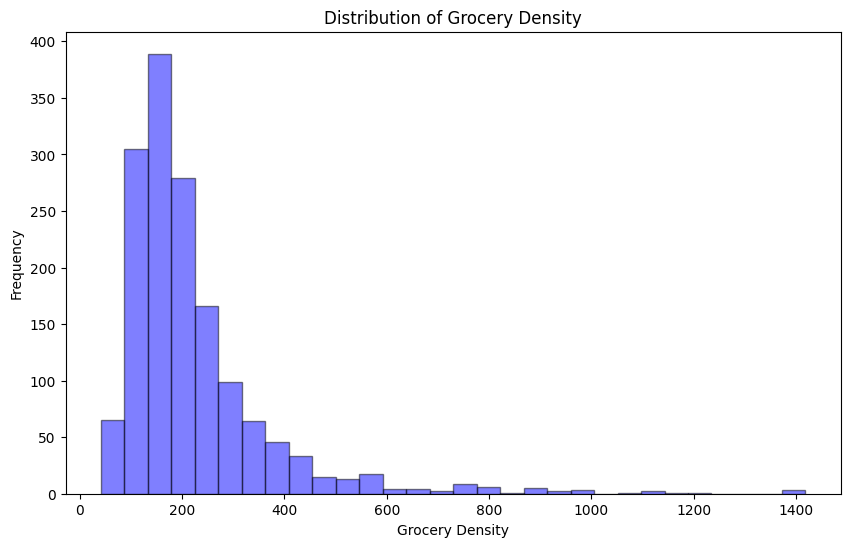

In [117]:
plt.figure(figsize=(10, 6))
plt.hist(df_reg2['density'], bins=30, color='blue', edgecolor='black', alpha=0.5)
plt.title('Distribution of Grocery Density')
plt.xlabel('Grocery Density')
plt.ylabel('Frequency')
plt.show()

Conclusion:

* The distribution of grocery density here is right-skewed.

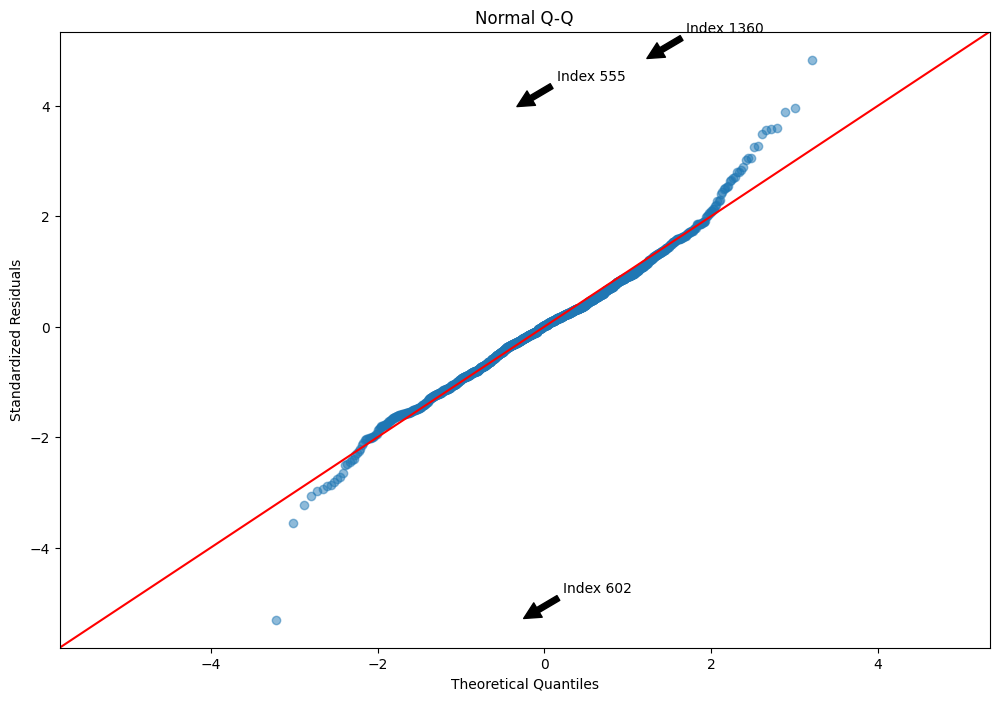

In [118]:
model_fitted_y = model.fittedvalues  # Predicted (fitted) values
model_residuals = model.resid  # Residuals
model_abs_resid = abs(model_residuals)  # Absolute residuals
model_std_residuals = model.get_influence().resid_studentized_internal  # Standardized residuals

# Q-Q plot of standardized residuals
QQ = ProbPlot(model_std_residuals)  
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, lw=1)

# Set figure size and title
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
# Use standardized residuals to find the largest values
abs_norm_resid = np.flip(np.argsort(np.abs(model_std_residuals)), 0)  # Get indices of largest residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# Annotate the top 3 residuals
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(f'Index {i}', 
                               xy=(QQ.theoretical_quantiles[i], model_std_residuals[i]),
                               xytext=(QQ.theoretical_quantiles[i] + 0.5, model_std_residuals[i] + 0.5),
                               arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

Conclusion:

* The Q-Q plot shows that the model could still roughly satisfy the normality assumption.

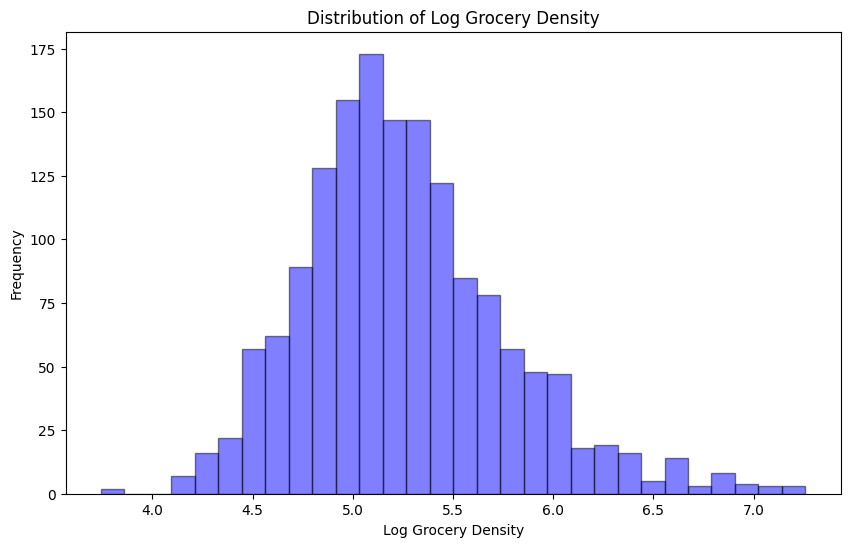

In [119]:
df_reg2['log density'] = np.log(df_reg2['density'] + 1)
plt.figure(figsize=(10, 6))
plt.hist(df_reg2['log density'], bins=30, color='blue', edgecolor='black', alpha=0.5)
plt.title('Distribution of Log Grocery Density')
plt.xlabel('Log Grocery Density')
plt.ylabel('Frequency')
plt.show()

Conclusion:

* After log transformation, it looks like normal distribution.

In [120]:
X = df_reg2[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White',
                'log average income', '< high school %','high school %', 'college or associate %',
                '> bachelor %', 'log density']]

y = df_reg2['mean rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     784.8
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:31   Log-Likelihood:                -1648.0
No. Observations:                1535   AIC:                             3318.
Df Residuals:                    1524   BIC:                             3377.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* Considering the higher R-squared and lower AIC & BIC, transformation here could be a better choice.

* The coefficient and p-value here could allow us to keep the conclusion above.

* *Thus*, we could keep this model for our forward selection.

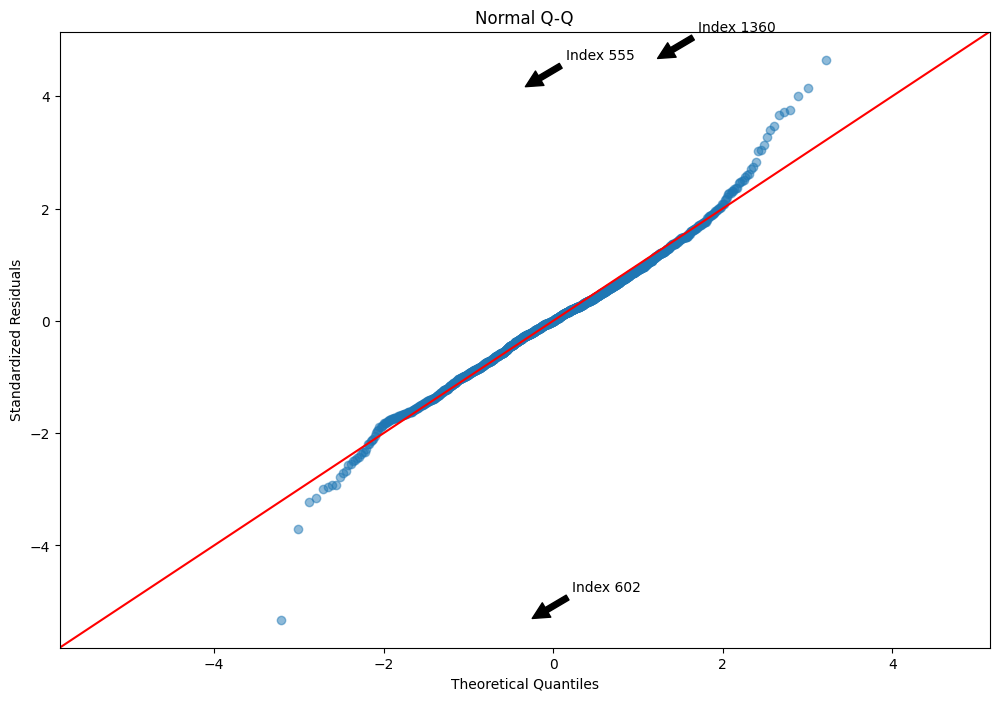

In [121]:
model_fitted_y = model.fittedvalues  # Predicted (fitted) values
model_residuals = model.resid  # Residuals
model_abs_resid = abs(model_residuals)  # Absolute residuals
model_std_residuals = model.get_influence().resid_studentized_internal  # Standardized residuals

# Q-Q plot of standardized residuals
QQ = ProbPlot(model_std_residuals)  
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, lw=1)

# Set figure size and title
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
# Use standardized residuals to find the largest values
abs_norm_resid = np.flip(np.argsort(np.abs(model_std_residuals)), 0)  # Get indices of largest residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# Annotate the top 3 residuals
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(f'Index {i}', 
                               xy=(QQ.theoretical_quantiles[i], model_std_residuals[i]),
                               xytext=(QQ.theoretical_quantiles[i] + 0.5, model_std_residuals[i] + 0.5),
                               arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

Conclusion:

* According to the Q-Q plot, the model still roughly shows the normality here and the performance seems to be better.

#### 2.1.7.2 Linearity

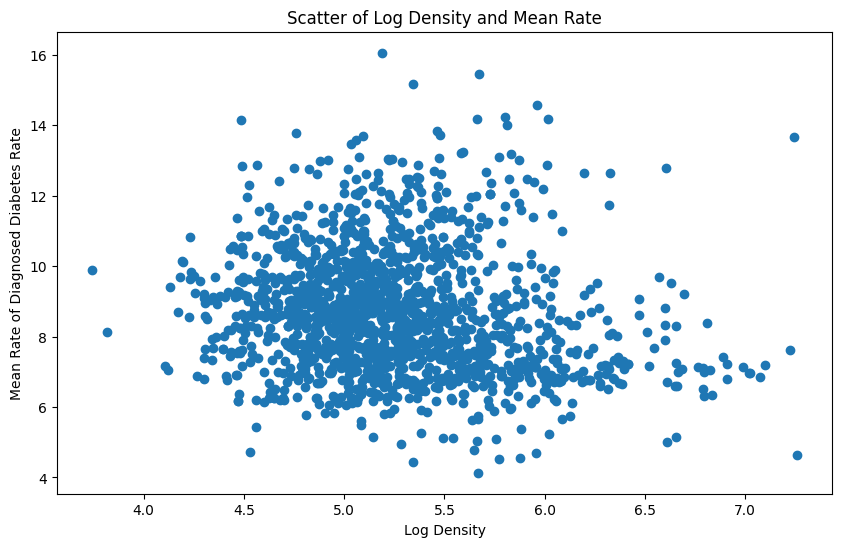

In [122]:
plt.figure(figsize=(10, 6))
plt.scatter(df_reg2['log density'], df_reg2['mean rate'])
plt.title('Scatter of Log Density and Mean Rate')
plt.xlabel('Log Density')
plt.ylabel('Mean Rate of Diagnosed Diabetes Rate')
plt.show()

Conclusion:

* The transformed grocery density does not show the linearity with diagnosed diabetes rate.

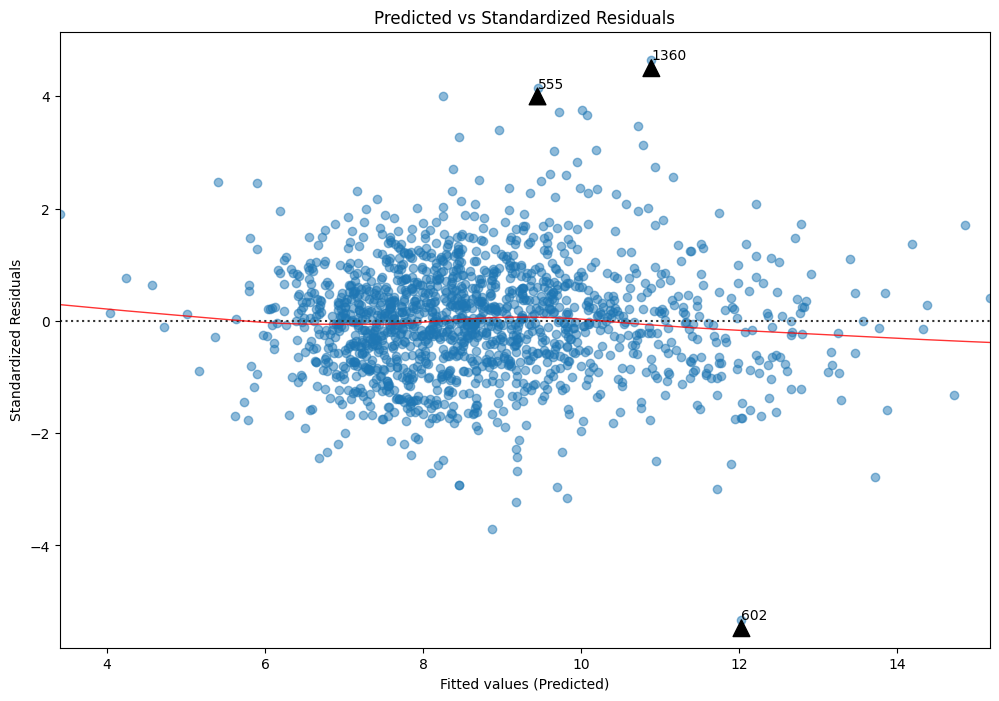

In [123]:
# Create the plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

# Residuals vs Fitted plot
sns.residplot(x=model_fitted_y, y=model_std_residuals, 
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Predicted vs Standardized Residuals')
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
abs_resid_top_3 = model_abs_resid.sort_values(ascending=False)[:3]

for i in abs_resid_top_3.index:
    plt.annotate(i, 
                 xy=(model_fitted_y[i], model_std_residuals[i]),
                 xytext=(model_fitted_y[i], model_std_residuals[i]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

Conclusion:

* Apparently, it could not satisfy the linearity assumption.

#### 2.1.7.3 Multicollinearity

In [124]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

/Users/cherongtian/Desktop/python/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/cherongtian/Desktop/python/.venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variable         VIF
0                        const    0.000000
1            Indian and Alaska   58.712038
2                        Asian   15.702533
3                        Black  285.233490
4   Hawaiian and Other Pacific    3.154259
5                        White  331.179039
6           log average income    2.470286
7              < high school %         inf
8                high school %         inf
9       college or associate %         inf
10                > bachelor %         inf
11                 log density    1.099922

In [125]:
X_log_drop = df_reg2[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'log average income', 
                      '< high school %','high school %', '> bachelor %', 'log density']]
# drop White and College or Associate rate here
vif_data = pd.DataFrame()
vif_data["Variable"] = X_log_drop.columns
vif_data["VIF"] = [variance_inflation_factor(X_log_drop.values, i) for i in range(X_log_drop.shape[1])]
vif_data

Variable         VIF
0           Indian and Alaska    1.171951
1                       Asian    3.057392
2                       Black    1.812308
3  Hawaiian and Other Pacific    1.689496
4          log average income  376.718258
5             < high school %   12.575451
6               high school %   75.451147
7                > bachelor %   50.558109
8                 log density  114.836214

Conclusion:

* The issue is the same as above content, we think we do not need to drop variables even from multicollinearity perspective.

#### 2.1.7.4 Constant Variance

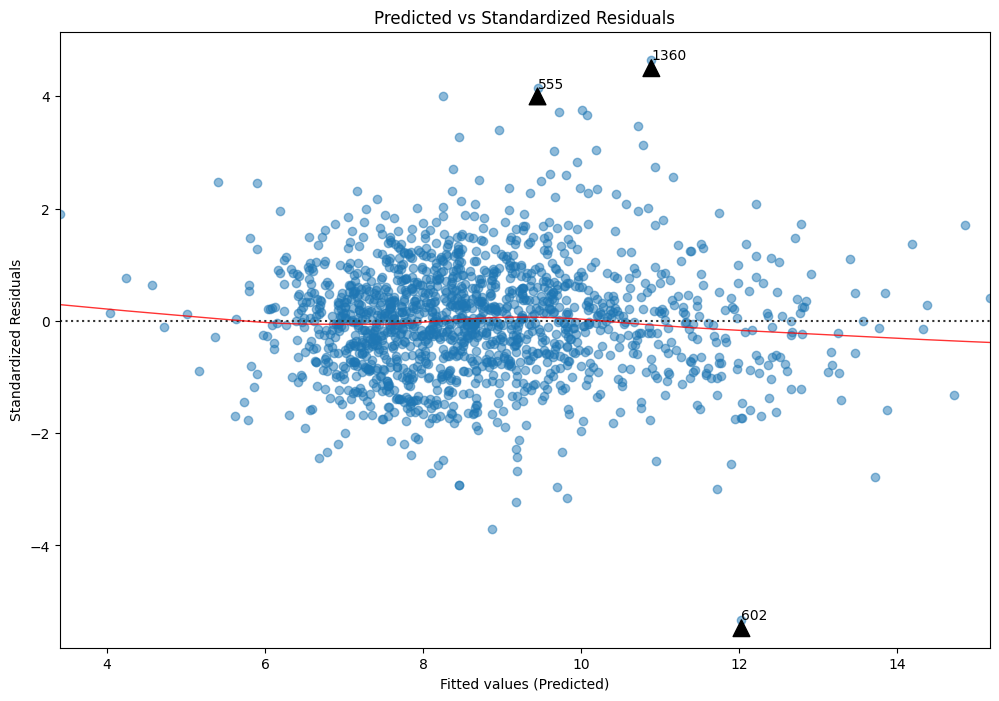

In [126]:
# Create the plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

# Residuals vs Fitted plot
sns.residplot(x=model_fitted_y, y=model_std_residuals, 
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Predicted vs Standardized Residuals')
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Standardized Residuals')

# Annotate the top 3 largest residuals
abs_resid_top_3 = model_abs_resid.sort_values(ascending=False)[:3]

for i in abs_resid_top_3.index:
    plt.annotate(i, 
                 xy=(model_fitted_y[i], model_std_residuals[i]),
                 xytext=(model_fitted_y[i], model_std_residuals[i]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

Conclusion:

* The model cannot satisfy the constant variance assumption.

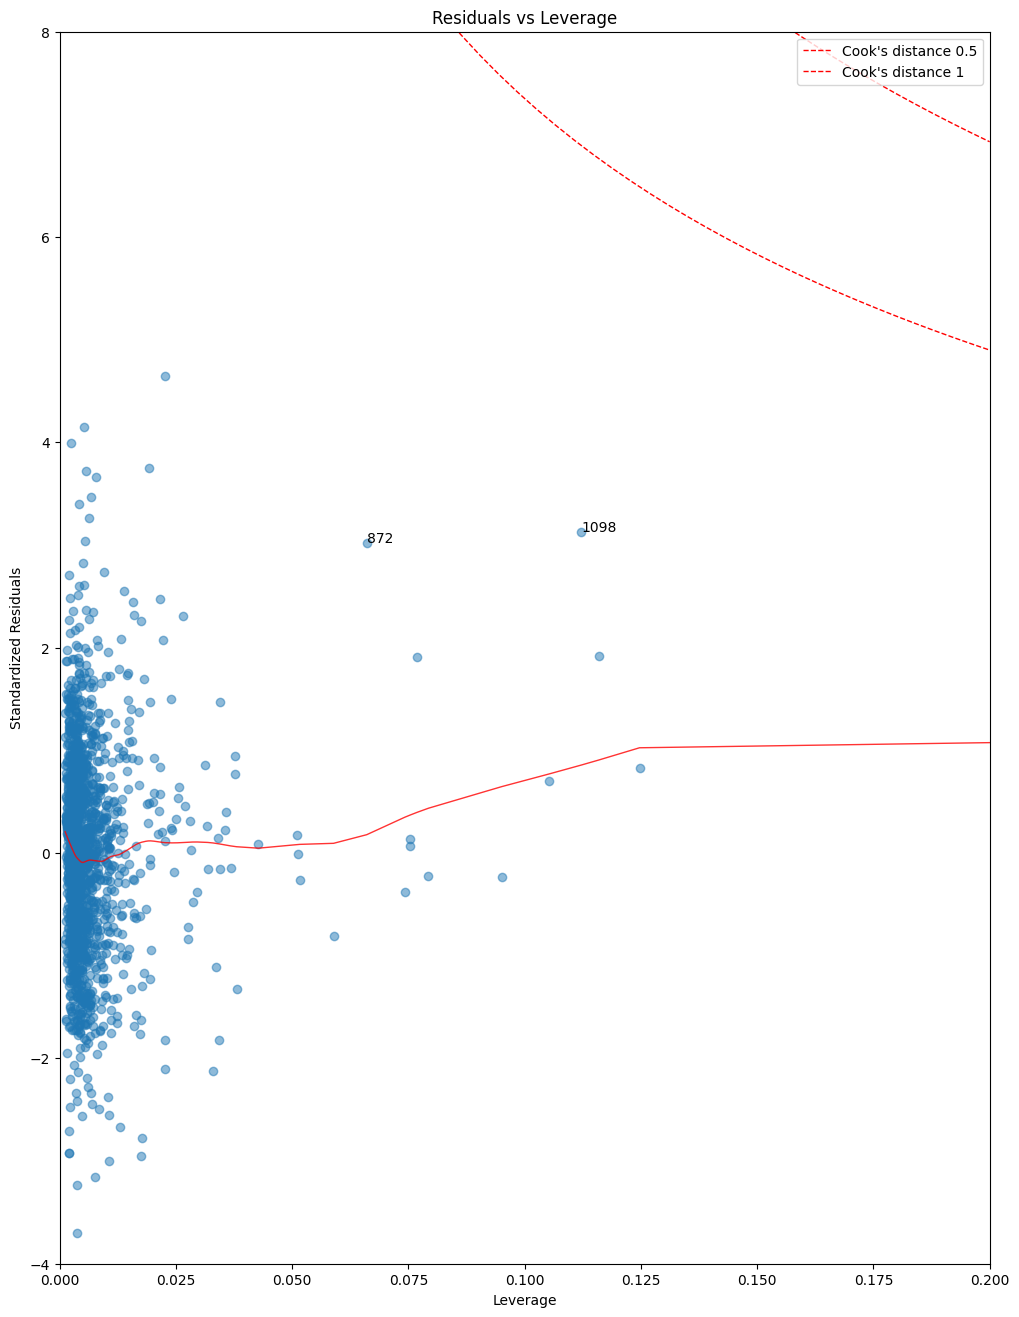

In [127]:
influence = model.get_influence()
model_leverage = influence.hat_matrix_diag
model_norm_residuals = influence.resid_studentized_internal
model_cooks = influence.cooks_distance[0]

# Create the leverage plot as described
plot_lm_4 = plt.figure(1)
plot_lm_4.set_figheight(16)
plot_lm_4.set_figwidth(12)

# Scatter plot for leverage vs residuals
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)

# Use sns.regplot to add a lowess line (fit is False for regplot to avoid conflict)
sns.regplot(x=model_leverage, y=model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.2)
plot_lm_4.axes[0].set_ylim(-4, 8)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# Annotations for the top 3 leverage points
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))

# Function for Cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model.params)  # Number of parameters in the model

# Plot Cook's distance contours
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance 0.5')

graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance 1')

plt.legend(loc='upper right')

# Show the plot
plt.show()

Conclusion:

* There is not plot above the Cook's Distance 1 line, showing that there is no influencial outliers.

#### 2.1.7.5 Independence

In [128]:
# Durbin-Watson test
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.474598967549526


Conclusion:

* The DW statistic is a little bit closer to 2 than the model before forward selection, showing that from independence perspective, the model is better.

#### 2.1.7.6 Conclusion for Assumption Check

In [129]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     784.8
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:33   Log-Likelihood:                -1648.0
No. Observations:                1535   AIC:                             3318.
Df Residuals:                    1524   BIC:                             3377.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* The R-squared increased from 0.835 to 0.837, the improvement is not huge.

* AIC dropped from 4691 to 3318 and BIC dropped from 4748 to 3377, showing huge improvements. 

* *Thus*, we could do the forward selection.

## 2.2 Crime Rate

### Dependent Variable

The dependent variable (y) here is the mean diagnosed diabetes rate.

### Independent Variables

The independent variables (Xs) here are the rate, income, education and grocery density.

### Hypothesis

Hypothesis for the Forward Selection model:

$\begin{cases}
H_0: \text{The addition of the variable, crime rate does not provide a statistically significant explanation for variations in the diagnosed diabetes rate after accounting for race, education, income and grocery density.}\\
H_1: \text{The addition of the variable, crime rate does provide a statistically significant explanation for variations in the diagnosed diabetes rate after accounting for race, education, income and grocery density.}\\
\end{cases}$

### 2.2.1 Import Data

In [130]:
path_crime = Path('crime_data_w_population_and_crime_rate.csv')
df_crime = pd.read_csv(path_crime)

### 2.2.2 Observe Data

In [131]:
df_crime

county_name  crime_rate_per_100000  index  EDITION  PART  \
0        St. Louis city, MO            1791.995377      1        1     4   
1     Crittenden County, AR            1754.914968      2        1     4   
2      Alexander County, IL            1664.700485      3        1     4   
3         Kenedy County, TX            1456.310680      4        1     4   
4        De Soto Parish, LA            1447.402430      5        1     4   
...                     ...                    ...    ...      ...   ...   
3131        Ohio County, IN               0.000000   3132        1     4   
3132      Newton County, MS               0.000000   3133        1     4   
3133     Jerauld County, SD               0.000000   3134        1     4   
3134    Cimarron County, OK               0.000000   3135        1     4   
3135    Lawrence County, MS               0.000000   3136        1     4   

      IDNO  CPOPARST  CPOPCRIM  AG_ARRST  AG_OFF  ...  RAPE  ROBBERY  AGASSLT  \
0     1612    318667    318667        15      15  ...   200     1778     3609   
1      130     50717     50717         4       4  ...    38      165      662   
2      604      8040      8040         2       2  ...     2        5      119   
3     2681       444       444         1       1  ...     3        1        2   
4     1137     26971     26971         3       3  ...     4       17      368   
...    ...       ...       ...       ...     ...  ...   ...      ...      ...   
3131   762      6084         0         2       1  ...     0        0        0   
3132  1465     21545      3346         3       1  ...     0        0        0   
3133  2424      2108      2108         1       1  ...     0        0        0   
3134  2167      2502      2502         2       2  ...     0        0        0   
3135  1453     12714         0         1       1  ...     0        0        0   

      BURGLRY  LARCENY  MVTHEFT  ARSON  population  FIPS_ST  FIPS_CTY  
0        4995    13791     3543    464      318416       29       510  
1        1482     1753      189     28       49746        5        35  
2          82      184       12      2        7629       17         3  
3           5        4        4      0         412       48       261  
4         149      494       60      0       27083       22        31  
...       ...      ...      ...    ...         ...      ...       ...  
3131        2        2        0      0        5994       18       115  
3132        4        0        1      0       21689       28       101  
3133        1        3        1      0        2066       46        73  
3134        1        2        0      0        2335       40        25  
3135        0        0        0      0       12514       28        77  

[3136 rows x 24 columns]

### 2.2.3 Processing Data

In [132]:
df_crime = df_crime[df_crime['crime_rate_per_100000'] != 0]
df_crime = df_crime[['county_name', 'crime_rate_per_100000']]
df_crime

county_name  crime_rate_per_100000
0        St. Louis city, MO            1791.995377
1     Crittenden County, AR            1754.914968
2      Alexander County, IL            1664.700485
3         Kenedy County, TX            1456.310680
4        De Soto Parish, LA            1447.402430
...                     ...                    ...
2970       Boone County, IL               7.413311
2971      Newton County, TX               7.072136
2972       Baker County, OR               6.242977
2973      Jasper County, MS               6.071645
2974     Fayette County, IN               4.190939

[2975 rows x 2 columns]

In [133]:
df_crime = df_crime.copy()

df_crime['state'] = df_crime['county_name'].str.split(',').str[1].str.strip()   # extract the state name
df_crime['county_name'] = df_crime['county_name'].str.split(',').str[0].str.strip() # remove state name from the original column
df_crime = df_crime[~df_crime['county_name'].str.contains('city', case=False)]  # exclude rows containing "city"

df_crime

county_name  crime_rate_per_100000 state
1     Crittenden County            1754.914968    AR
2      Alexander County            1664.700485    IL
3         Kenedy County            1456.310680    TX
4        De Soto Parish            1447.402430    LA
6         Shelby County            1315.003752    TN
...                 ...                    ...   ...
2970       Boone County               7.413311    IL
2971      Newton County               7.072136    TX
2972       Baker County               6.242977    OR
2973      Jasper County               6.071645    MS
2974     Fayette County               4.190939    IN

[2929 rows x 3 columns]

In [134]:
df_crime['county_name'] = df_crime['county_name'].str.replace('County', '', case=False).str.strip() # remove the word "County" from the remaining content
df_crime = df_crime.reset_index().drop('index', axis=1)
df_crime

county_name  crime_rate_per_100000 state
0         Crittenden            1754.914968    AR
1          Alexander            1664.700485    IL
2             Kenedy            1456.310680    TX
3     De Soto Parish            1447.402430    LA
4             Shelby            1315.003752    TN
...              ...                    ...   ...
2924           Boone               7.413311    IL
2925          Newton               7.072136    TX
2926           Baker               6.242977    OR
2927          Jasper               6.071645    MS
2928         Fayette               4.190939    IN

[2929 rows x 3 columns]

In [135]:
df_crime = df_crime.rename(columns={'county_name': 'county',
                                    'crime_rate_per_100000': 'crime rate'})
df_crime

county   crime rate state
0         Crittenden  1754.914968    AR
1          Alexander  1664.700485    IL
2             Kenedy  1456.310680    TX
3     De Soto Parish  1447.402430    LA
4             Shelby  1315.003752    TN
...              ...          ...   ...
2924           Boone     7.413311    IL
2925          Newton     7.072136    TX
2926           Baker     6.242977    OR
2927          Jasper     6.071645    MS
2928         Fayette     4.190939    IN

[2929 rows x 3 columns]

In [136]:
df_crime.isnull().sum()

county        0
crime rate    0
state         0
dtype: int64

In [137]:
df_crime.describe()

crime rate
count  2929.000000
mean    246.309024
std     195.249941
min       4.190939
25%     109.021532
50%     194.383904
75%     330.478182
max    1754.914968

In [138]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   county      2929 non-null   object 
 1   crime rate  2929 non-null   float64
 2   state       2929 non-null   object 
dtypes: float64(1), object(2)
memory usage: 68.8+ KB


### 2.2.4 Multiple Regression

#### 2.2.4.1 Raw Data

In [139]:
df_reg3 = pd.merge(df_reg2, df_crime, on=['state', 'county'])
df_reg3

county state  mean rate  Indian and Alaska  Asian  Black  \
0        Autauga    AL   9.825000                0.5    1.2   20.1   
1        Baldwin    AL   8.230714                0.8    1.1    8.8   
2        Barbour    AL  12.485000                0.7    0.5   48.2   
3           Bibb    AL  10.394286                0.5    0.2   21.3   
4         Blount    AL   9.632857                0.6    0.3    1.7   
...          ...   ...        ...                ...    ...    ...   
1502    Sheridan    WY   6.662857                1.3    0.9    0.9   
1503    Sublette    WY   5.963571                1.2    0.8    0.9   
1504  Sweetwater    WY   7.512143                1.5    1.1    1.4   
1505       Teton    WY   4.703571                0.9    1.7    0.7   
1506      Weston    WY   6.670000                1.9    1.7    0.7   

      Hawaiian and Other Pacific  White  average income  < high school %  ...  \
0                            0.1   76.3    50688.000000         9.597392  ...   
1                            0.1   87.4    58291.666667         8.400690  ...   
2                            0.2   49.2    41172.000000        23.507779  ...   
3                            0.1   76.8    38464.333333        21.136578  ...   
4                            0.1   95.8    44019.666667        18.244849  ...   
...                          ...    ...             ...              ...  ...   
1502                         0.1   95.0    69334.666667         3.692280  ...   
1503                         0.0   95.5    67225.333333         4.139715  ...   
1504                         0.2   93.8    60126.666667         6.954410  ...   
1505                         0.1   95.0   414561.000000         4.034018  ...   
1506                         0.0   93.2    51994.000000         8.877551  ...   

      log Asian  log Black  log Hawaiian and Other Pacific  \
0      0.788457   3.049273                        0.095310   
1      0.741937   2.282382                        0.095310   
2      0.405465   3.895894                        0.182322   
3      0.182322   3.104587                        0.095310   
4      0.262364   0.993252                        0.095310   
...         ...        ...                             ...   
1502   0.641854   0.641854                        0.095310   
1503   0.587787   0.641854                        0.000000   
1504   0.741937   0.875469                        0.182322   
1505   0.993252   0.530628                        0.095310   
1506   0.993252   0.530628                        0.000000   

      log average income  log > bachelor %  log < high school %  \
0              10.833444          3.386374             2.261491   
1              10.973214          3.483133             2.128314   
2              10.625514          2.474956             3.157331   
3              10.557487          2.390590             3.051005   
4              10.692392          2.690660             2.903883   
...                  ...               ...                  ...   
1502           11.146700          3.469737             1.306244   
1503           11.115805          3.241895             1.420627   
1504           11.004209          2.994862             1.939376   
1505           12.934975          4.099200             1.394763   
1506           10.858884          2.868594             2.183526   

      Transformed White     density  log density  crime rate  
0              0.949532   68.072361     4.235155  251.601926  
1              0.936500  128.523691     4.863864  228.086325  
2              0.961349  200.988865     5.308213  177.278771  
3              0.949132  179.767201     5.197210  217.661691  
4              0.913220   67.708245     4.229869  210.810064  
...                 ...         ...          ...         ...  
1502           0.916546  192.455735     5.265049   93.884120  
1503           0.914510  340.870356     5.834432  119.510009  
1504           0.920928  118.824117     4.786025  433.273648  
1505           0

In [140]:
X = df_reg3[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White',
                'log average income', '< high school %','high school %', 'college or associate %',
                '> bachelor %', 'log density', 'crime rate']]

y = df_reg3['mean rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     696.8
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:33   Log-Likelihood:                -1617.3
No. Observations:                1507   AIC:                             3259.
Df Residuals:                    1495   BIC:                             3322.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* Considering the changes of R-squared, AIC and BIC are not obvious, we do not recommend to do the forward selection.

#### 2.2.4.2 Transformation

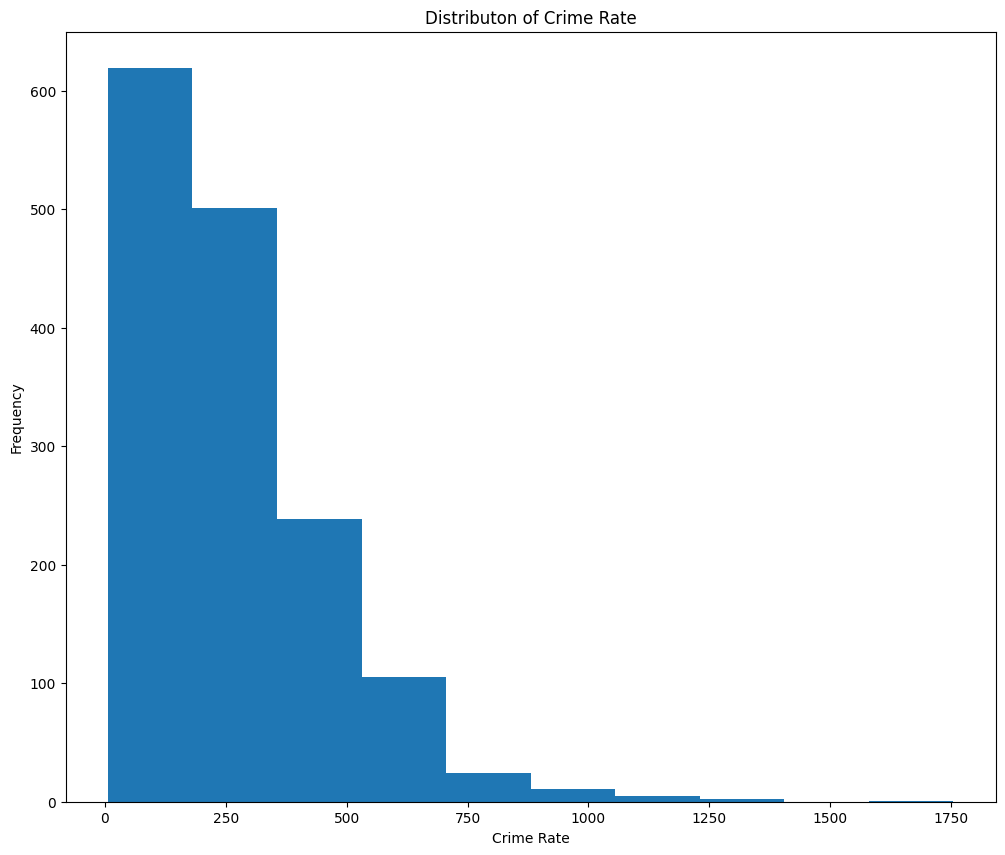

In [141]:
plt.figure(figsize=(12, 10))
plt.hist(df_reg3['crime rate'])
plt.title('Distributon of Crime Rate')
plt.xlabel('Crime Rate')
plt.ylabel('Frequency')
plt.show()

Conclusion:

* The crime rate shows right-skewed here.

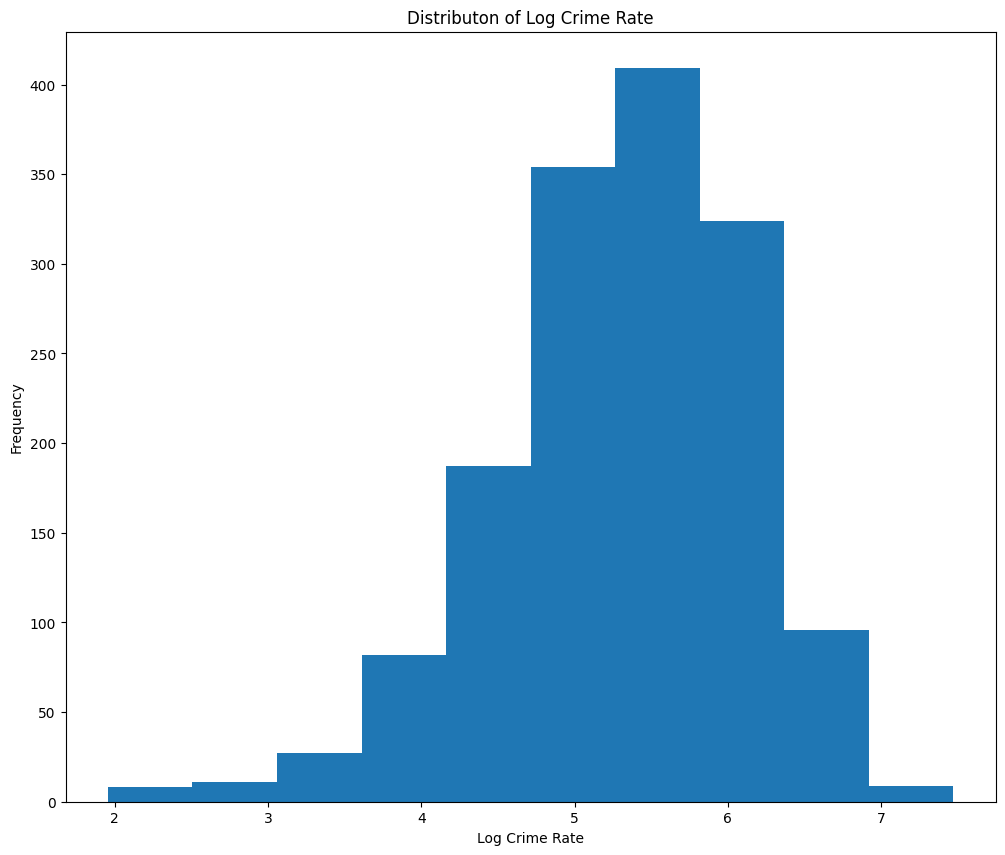

In [142]:
df_reg3['log crime rate'] = np.log(df_reg3['crime rate'] + 1)
plt.figure(figsize=(12, 10))
plt.hist(df_reg3['log crime rate'])
plt.title('Distributon of Log Crime Rate')
plt.xlabel('Log Crime Rate')
plt.ylabel('Frequency')
plt.show()

Conclusion:

* After log transformation, the distribution shows more like normal distribution.

In [143]:
X = df_reg3[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White',
                'log average income', '< high school %','high school %', 'college or associate %',
                '> bachelor %', 'log density', 'log crime rate']]

y = df_reg3['mean rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     696.3
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:33   Log-Likelihood:                -1617.8
No. Observations:                1507   AIC:                             3260.
Df Residuals:                    1495   BIC:                             3323.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* R-Squared: We could observe that the R-squared stays the same before and after the selection.

* AIC & BIC: We could observe that the change of AIC & BIC is not obvious.

* Thus we could say it is not worthwhile to add crime rate as a variable even we have done the log transformation.

## 2.3 Model After Selection

We decided just do the forward selection to add the grocery density and we could do the log transformation here.

In [144]:
X = df_reg2[['Indian and Alaska', 'Asian', 'Black', 'Hawaiian and Other Pacific', 'White',
                'log average income', '< high school %','high school %', 'college or associate %',
                '> bachelor %', 'log density']]

y = df_reg2['mean rate']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mean rate   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     784.8
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:56:33   Log-Likelihood:                -1648.0
No. Observations:                1535   AIC:                             3318.
Df Residuals:                    1524   BIC:                             3377.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Conclusion:

* The R-squared is 0.837, showing that the fit of the model is good.

* The P-value is 0.00 for the model, which is smaller than alpha, 0.05, indicating that the model is significant.

* For individual variables, the p-value for all race variables are bigger than alpha, 0.05, showing that they are not significant and the rest variables are significant as their p-values are all 0.00.

* For coeffieicents, those significant variables are positive related to the dependent variable except log grocery density and log average income, when these 2 variables increase, the mean diagnosed diabetes rate would decrease.

* For assumption checks, the model violates linearity, constant variance, multicollinearity and independence assumptions and could only roughly satisfy the normality assumption.

### 2.3.1 Math Formula

$$
\hat{Y} = 0.0121 -1.4994 e ^ {X_1} + 0.3862 X_2 + 0.3073 X_3 + 0.2527 X_4 + 0.2649 X_5 - 0.3912 e ^ {X_6}
$$


Where:
* $\hat{Y}$: represents estimated mean rate of diagnosed diabetes rate.
* $X_1$: represents average income.
* $X_2$: represents percentage of population whose educatiion level is below high school.
* $X_3$: represents percentage of population whose educatiion level is high school.
* $X_4$: represents percentage of population whose educatiion level is college or associate.
* $X_5$: represents percentage of population whose educatiion level is higher than bachelor.
* $X_6$: represents grocery density.

Other variables are excluded as they are not significant.

### 2.3.2 Conclusion

Since the cofficient for $e ^ {X_6}$ is negative, showing that when $X_6$ increases, $\hat{Y}$ would decreases and the formula could measure the quantitative relationship between ${X_6}$ and $\hat{Y}$.

Our primary guess should be correct.

# 3. Further Exploration

## 3.1 Concerns

Even though we generate the regression model and the R-squared shows that the performance of fit for the model is good, but the violation of those assumptions, linearity, multicollinearity, and independence still exists. Thus, we would like to try other methods to explore our hypothesis again.

## 3.2 Potential Methods

Since the Tree models do not need those assumptions, we would consider to use those methods to replace the regression models.

# 4. Tree Models

## 4.1 Data

In [145]:
df_reg3

county state  mean rate  Indian and Alaska  Asian  Black  \
0        Autauga    AL   9.825000                0.5    1.2   20.1   
1        Baldwin    AL   8.230714                0.8    1.1    8.8   
2        Barbour    AL  12.485000                0.7    0.5   48.2   
3           Bibb    AL  10.394286                0.5    0.2   21.3   
4         Blount    AL   9.632857                0.6    0.3    1.7   
...          ...   ...        ...                ...    ...    ...   
1502    Sheridan    WY   6.662857                1.3    0.9    0.9   
1503    Sublette    WY   5.963571                1.2    0.8    0.9   
1504  Sweetwater    WY   7.512143                1.5    1.1    1.4   
1505       Teton    WY   4.703571                0.9    1.7    0.7   
1506      Weston    WY   6.670000                1.9    1.7    0.7   

      Hawaiian and Other Pacific  White  average income  < high school %  ...  \
0                            0.1   76.3    50688.000000         9.597392  ...   
1                            0.1   87.4    58291.666667         8.400690  ...   
2                            0.2   49.2    41172.000000        23.507779  ...   
3                            0.1   76.8    38464.333333        21.136578  ...   
4                            0.1   95.8    44019.666667        18.244849  ...   
...                          ...    ...             ...              ...  ...   
1502                         0.1   95.0    69334.666667         3.692280  ...   
1503                         0.0   95.5    67225.333333         4.139715  ...   
1504                         0.2   93.8    60126.666667         6.954410  ...   
1505                         0.1   95.0   414561.000000         4.034018  ...   
1506                         0.0   93.2    51994.000000         8.877551  ...   

      log Black  log Hawaiian and Other Pacific  log average income  \
0      3.049273                        0.095310           10.833444   
1      2.282382                        0.095310           10.973214   
2      3.895894                        0.182322           10.625514   
3      3.104587                        0.095310           10.557487   
4      0.993252                        0.095310           10.692392   
...         ...                             ...                 ...   
1502   0.641854                        0.095310           11.146700   
1503   0.641854                        0.000000           11.115805   
1504   0.875469                        0.182322           11.004209   
1505   0.530628                        0.095310           12.934975   
1506   0.530628                        0.000000           10.858884   

      log > bachelor %  log < high school %  Transformed White     density  \
0             3.386374             2.261491           0.949532   68.072361   
1             3.483133             2.128314           0.936500  128.523691   
2             2.474956             3.157331           0.961349  200.988865   
3             2.390590             3.051005           0.949132  179.767201   
4             2.690660             2.903883           0.913220   67.708245   
...                ...                  ...                ...         ...   
1502          3.469737             1.306244           0.916546  192.455735   
1503          3.241895             1.420627           0.914510  340.870356   
1504          2.994862             1.939376           0.920928  118.824117   
1505          4.099200             1.394763           0.916546  385.505012   
1506          2.868594             2.183526           0.922887  582.241630   

      log density  crime rate  log crime rate  
0        4.235155  251.601926        5.531815  
1        4.863864  228.086325        5.434099  
2        5.308213  177.278771        5.183348  
3        5.197210  217.661691        5.387526  
4        4.229869  210.810064        5.355690  
...           ...         ...             ...  
1502     5.265049   93.884120        4.552656  
1503     5.834432  119

In [146]:
df_tfx = df_reg3.drop(columns=[col for col in df_reg3.columns if 'log' in col])
df_tfx = df_tfx.drop(columns=[col for col in df_tfx.columns if 'Transformed' in col])
# since there is no assumptions, we do not need the transformation here

df_tfx = df_tfx.rename(columns={'< high school %': "less than high school rate", 
                                'high school %': 'high school rate',
                                'college or associate %': 'college or associate rate',
                                '> bachelor %': 'higher than bachelor rate'})
# rename some columns for satisfying XGBoost's requirement.
df_tfx

county state  mean rate  Indian and Alaska  Asian  Black  \
0        Autauga    AL   9.825000                0.5    1.2   20.1   
1        Baldwin    AL   8.230714                0.8    1.1    8.8   
2        Barbour    AL  12.485000                0.7    0.5   48.2   
3           Bibb    AL  10.394286                0.5    0.2   21.3   
4         Blount    AL   9.632857                0.6    0.3    1.7   
...          ...   ...        ...                ...    ...    ...   
1502    Sheridan    WY   6.662857                1.3    0.9    0.9   
1503    Sublette    WY   5.963571                1.2    0.8    0.9   
1504  Sweetwater    WY   7.512143                1.5    1.1    1.4   
1505       Teton    WY   4.703571                0.9    1.7    0.7   
1506      Weston    WY   6.670000                1.9    1.7    0.7   

      Hawaiian and Other Pacific  White  average income  \
0                            0.1   76.3    50688.000000   
1                            0.1   87.4    58291.666667   
2                            0.2   49.2    41172.000000   
3                            0.1   76.8    38464.333333   
4                            0.1   95.8    44019.666667   
...                          ...    ...             ...   
1502                         0.1   95.0    69334.666667   
1503                         0.0   95.5    67225.333333   
1504                         0.2   93.8    60126.666667   
1505                         0.1   95.0   414561.000000   
1506                         0.0   93.2    51994.000000   

      less than high school rate  high school rate  college or associate rate  \
0                       9.597392         31.146113                  29.697920   
1                       8.400690         27.775383                  31.262349   
2                      23.507779         36.814710                  27.796322   
3                      21.136578         40.879121                  27.064364   
4                      18.244849         35.313717                  31.700027   
...                          ...               ...                        ...   
1502                    3.692280         31.089540                  33.089903   
1503                    4.139715         28.040103                  42.238034   
1504                    6.954410         32.652026                  40.410959   
1505                    4.034018         16.650814                  19.023107   
1506                    8.877551         36.877551                  36.632653   

      higher than bachelor rate     density  crime rate  
0                     29.558575   68.072361  251.601926  
1                     32.561579  128.523691  228.086325  
2                     11.881188  200.988865  177.278771  
3                     10.919937  179.767201  217.661691  
4                     14.741407   67.708245  210.810064  
...                         ...         ...         ...  
1502                  32.128277  192.455735   93.884120  
1503                  25.582147  340.870356  119.510009  
1504                  19.982605  118.824117  433.273648  
1505                  60.292061  385.505012  179.629962  
1506                  17.612245  582.241630   69.851914  

[1507 rows x 15 columns]

## 4.2 Decision Tree

In [147]:
# Remove `state` and `county` columns
data_cleaned = df_tfx.drop(columns=['state', 'county'])

# Check for missing values and handle them
data_cleaned = data_cleaned.dropna()

# Separate dependent and independent variables
X = data_cleaned.drop(columns=['mean rate'])
y = data_cleaned['mean rate']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

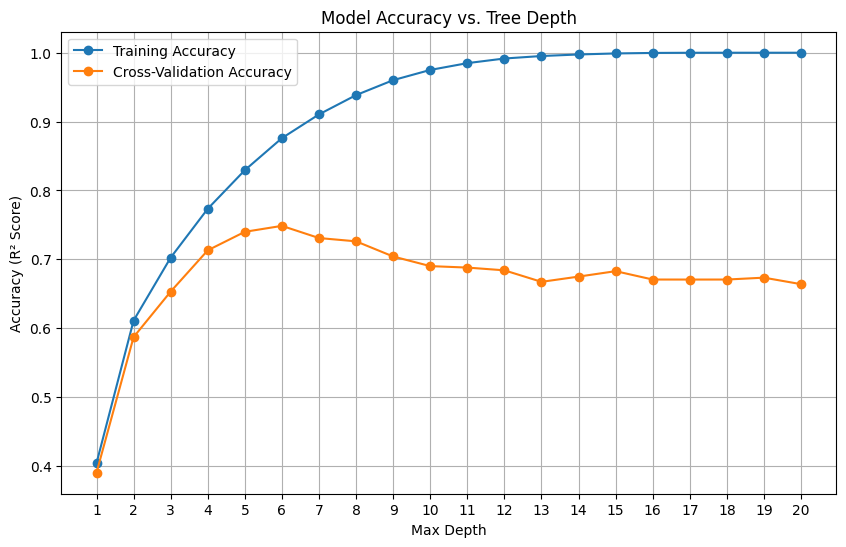

In [148]:
# Calculate training and cross-validation scores for different max_depths
train_scores = []
cv_scores = []

for depth in range(1, 21):
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Training accuracy
    train_scores.append(model.score(X_train, y_train))
    
    # Cross-validation accuracy
    cv_score = cross_val_score(model, X_train, y_train, cv=10, scoring='r2').mean()
    cv_scores.append(cv_score)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores, label="Training Accuracy", marker='o')
plt.plot(range(1, 21), cv_scores, label="Cross-Validation Accuracy", marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy (R² Score)")
plt.title("Model Accuracy vs. Tree Depth")
plt.grid()
plt.xticks(range(1, 21))
plt.legend()
plt.show()

In [149]:
# Find the optimal depth based on cross-validation accuracy
optimal_depth = cv_scores.index(max(cv_scores)) + 1

# Train a new model with the optimal depth
optimal_model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
optimal_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = optimal_model.predict(X_test)

# Calculate R² and MSE
final_r2 = r2_score(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)

optimal_depth, final_r2, final_mse

(6, 0.6875753871260131, 0.8261937246972452)

Conclusion:
* R-squared for the Tree Regressor is 0.688.
* MSE is 0.826.
* Max depth node is the 6th.

## 4.3 Random Forest

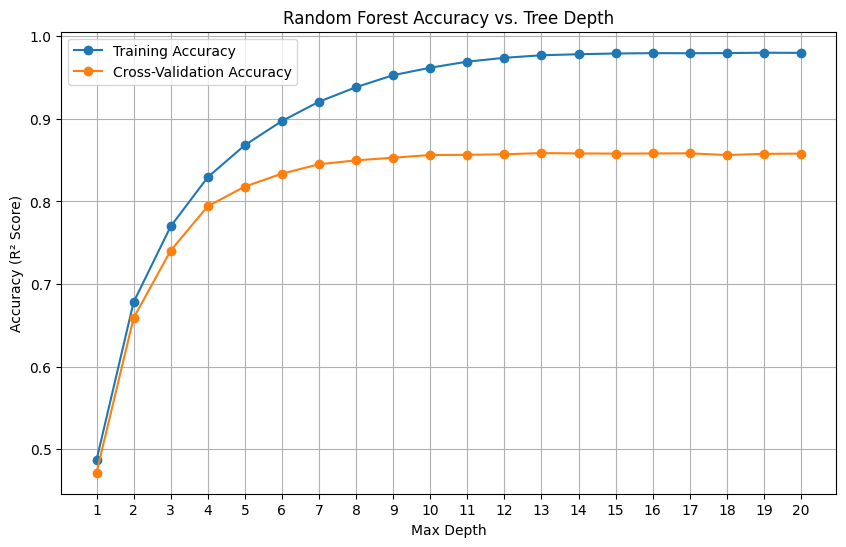

In [150]:
# Variables to store training and cross-validation scores for Random Forest
train_scores_rf = []
cv_scores_rf = []

# Evaluate Random Forest models with varying numbers of estimators (trees)
for depth in range(1, 21):
    rf_model = RandomForestRegressor(max_depth=depth, n_estimators=100, max_features='sqrt', random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Training accuracy
    train_scores_rf.append(rf_model.score(X_train, y_train))
    
    # Cross-validation accuracy
    cv_score_rf = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='r2').mean()
    cv_scores_rf.append(cv_score_rf)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores_rf, label="Training Accuracy", marker='o')
plt.plot(range(1, 21), cv_scores_rf, label="Cross-Validation Accuracy", marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy (R² Score)")
plt.title("Random Forest Accuracy vs. Tree Depth")
plt.grid()
plt.xticks(range(1, 21))
plt.legend()
plt.show()

In [151]:
# Determine the optimal depth based on cross-validation
optimal_depth_rf = cv_scores_rf.index(max(cv_scores_rf)) + 1

# Train the final Random Forest model using the optimal depth
optimal_rf_model = RandomForestRegressor(max_depth=optimal_depth_rf, n_estimators=100, random_state=42)
optimal_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = optimal_rf_model.predict(X_test)

# Calculate R² and MSE for Random Forest
final_r2_rf = r2_score(y_test, y_pred_rf)
final_mse_rf = mean_squared_error(y_test, y_pred_rf)

optimal_depth_rf, final_r2_rf, final_mse_rf

(13, 0.7997180212655626, 0.529637253858359)

Conclusion:
* R-squared for the Forest Regressor is 0.800.
* MSE is 0.530.
* Max depth node is the 13th.

## 4.4 XGBoost

In [152]:
# Remove `state` and `county` columns
data_cleaned = df_tfx.drop(columns=['state', 'county'])

# Check for missing values and handle them
data_cleaned = data_cleaned.dropna()

# Separate dependent and independent variables
X = data_cleaned.drop(columns=['mean rate'])
y = data_cleaned['mean rate']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

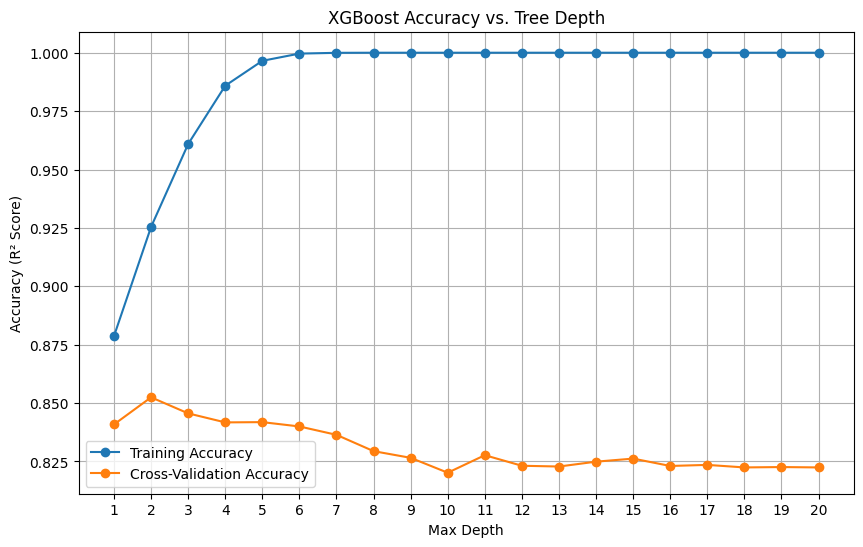

In [153]:
# Variables to store training and cross-validation scores for XGBoost
train_scores_xgb = []
cv_scores_xgb = []

# Evaluate XGBoost models with varying tree depths
for depth in range(1, 21):
    xgb_model = XGBRegressor(max_depth=depth, n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Training accuracy
    train_scores_xgb.append(xgb_model.score(X_train, y_train))
    
    # Cross-validation accuracy
    cv_score_xgb = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='r2').mean()
    cv_scores_xgb.append(cv_score_xgb)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores_xgb, label="Training Accuracy", marker='o')
plt.plot(range(1, 21), cv_scores_xgb, label="Cross-Validation Accuracy", marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy (R² Score)")
plt.title("XGBoost Accuracy vs. Tree Depth")
plt.grid()
plt.xticks(range(1, 21))
plt.legend()
plt.show()

In [154]:
# Determine the optimal depth based on cross-validation
optimal_depth_xgb = cv_scores_xgb.index(max(cv_scores_xgb)) + 1

# Train the final XGBoost model using the optimal depth
optimal_xgb_model = XGBRegressor(max_depth=optimal_depth_xgb, n_estimators=100, random_state=42, objective='reg:squarederror')
optimal_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = optimal_xgb_model.predict(X_test)

# Calculate R² and MSE for XGBoost
final_r2_xgb = r2_score(y_test, y_pred_xgb)
final_mse_xgb = mean_squared_error(y_test, y_pred_xgb)

optimal_depth_xgb, final_r2_xgb, final_mse_xgb

(2, 0.7938283174964618, 0.5452123273123811)

Conclusion:
* R-squared for the Forest Regressor is 0.794.
* MSE is 0.545.
* Max depth node is the 2nd.

## 4.5 Comparasion

|Model|R-squared|MSE|Max Depth|
|------|--------|----|--------|
|Tree|0.688|0.826|6th|
|Forest|0.800|0.530|13th|
|XGBoost|0.794|0.545|2nd|

Conclusion: 
* Since we need descriptive analysis here, we should pick the model that has the highest R-squared. So, we should use the Forest Regressor.

## 4.6 Conclusion for Random Forests

In [155]:
# Compute feature importances from the Random Forest model
feature_importances = optimal_rf_model.feature_importances_

# Compute correlations with the target variable
correlations = X.corrwith(y)

combined_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances,
    'Correlation': X.corrwith(y)
}).sort_values(by='Importance', ascending=False)

# Set the 'Feature' column as the new index to remove duplicates
combined_df.set_index('Feature', inplace=True)

# Display the combined DataFrame
combined_df


Importance  Correlation
Feature                                            
less than high school rate    0.472088     0.721335
Black                         0.197421     0.679779
White                         0.103666    -0.626170
average income                0.090809    -0.510347
higher than bachelor rate     0.026472    -0.553086
Indian and Alaska             0.025309     0.100804
high school rate              0.021121     0.437578
density                       0.019172    -0.148706
college or associate rate     0.015647    -0.180943
crime rate                    0.013601     0.375995
Asian                         0.009878    -0.181958
Hawaiian and Other Pacific    0.004814    -0.049327

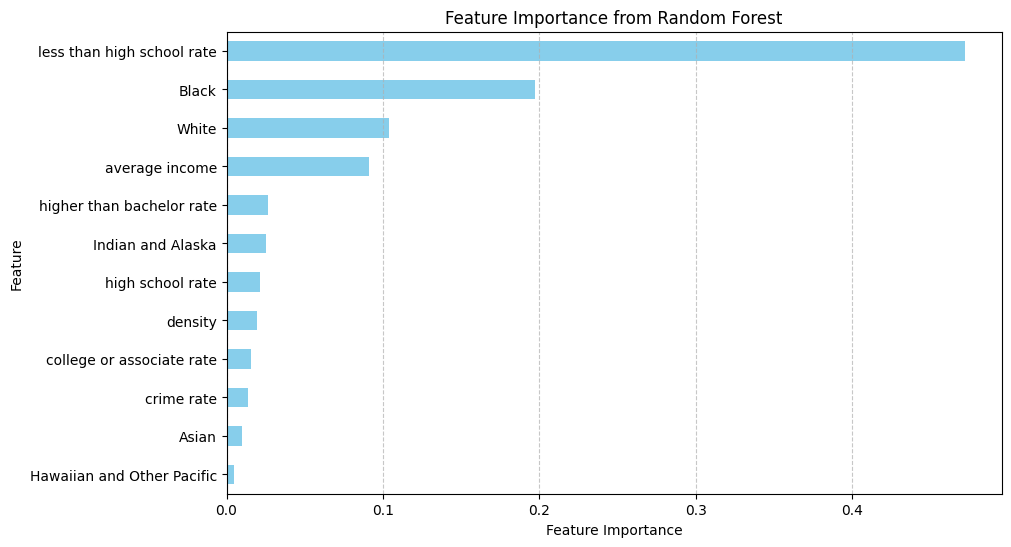

In [156]:
# Plot feature importance as a horizontal bar chart
plt.figure(figsize=(10, 6))
combined_df['Importance'].plot(kind='barh', color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Conclusion:

* Less than high school rate, Black, White and average income are the top 4 the most important predictors in the model.

* The correlations for less than high school rate (0.721) and Black (0.680) are positive and also show strongly positive relationships, meaning that when these 2 variables increases, the mean diagnosed diabetes rate would increase also.

* The correlations for White (-0.63) and average income (-0.51) are negative and also shows some kind of strongly negative relastionships, meaning that when these 2 variables increases, the mean diagnosed diabetets rate would decrease.

* College or associate rate, crime rate, Asian and Hawaiian and Other Pacific are the top 4 the least important predictors in the model.

* The importance of density is 0.019, showing that it may not be an important predictor for this model, and the correlation is -0.149, meaning that when this predictor increases, the mean diahnosed diabetes rate would decrease.

From the conclusion, we guess that there may be some interaction between grocery density and some other variable. Thus, we decided to pick average income to test our guess.

# 5. Interaction

## 5.1 Partial Dependence

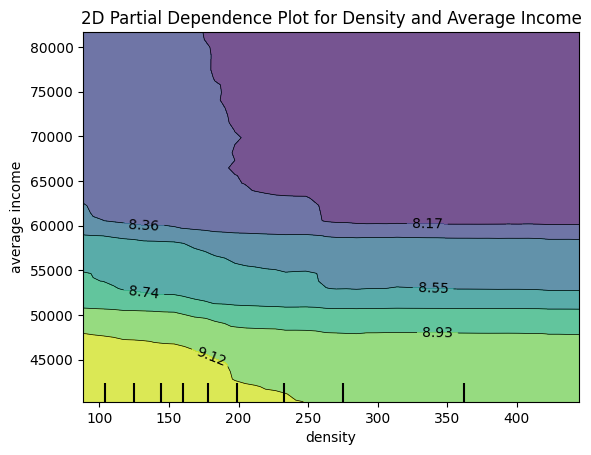

In [157]:
# Generate a 2D Partial Dependence Plot for 'density' and average income
PartialDependenceDisplay.from_estimator(optimal_rf_model, X, [('density', 'average income')], grid_resolution=50)
plt.title("2D Partial Dependence Plot for Density and Average Income")
plt.show()


Conclusion:

* The plot shows the joint effect of grocery density and average income on diagnosed diabetes rate:

    1. Grocery density has a stronger negative impact on diagnosed diabetes rate at lower income levels.

    2. At higher income levels, the effect of grocery density weakens significantly.

    3. The plot confirms the interaction between grocery density and average income, with income moderating the impact of grocery density on diagnosed diabetes rate.


## 5.2 Analyze Feature Interaction in Random Forest

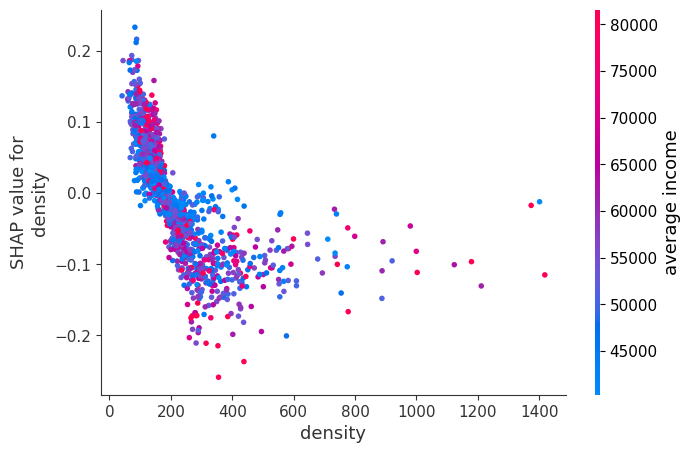

In [158]:
# Fit SHAP explainer on the Random Forest model
explainer = shap.TreeExplainer(optimal_rf_model)
shap_values = explainer.shap_values(X)

# Plot SHAP interaction effects for 'density' with another variable
# Replace 'average income' with the exact column name as a string
shap.dependence_plot('density', shap_values, X, interaction_index='average income')


Conclusion:

* Impact of Grocery Density:

1. At low grocery density ( < 200), the effect is mixed and varies.

2. At medium grocery density (200 ~ 600), the negative impact of density is strongest.

3. At high grocery density ( > 600), the impact of density diminishes.

* Interaction with Average Income:

1. For low-income areas (blue dots), grocery density in low area has a positive relationship with diagnosed diabetes rate and in high area has a negative relationship with diagnosed diabetes rate.

2. For high-income areas (red dots), the similar effect of grocery density is mitigated.

## 5.3 Explore Interactions Using Statistical Models

### Dependent Variable

The dependent variable (y) here is the mean diagnosed diabetes rate.

### Independent Variables

The independent variables (Xs) here are the income, grocery density and the interaction of income and grocery density.

### Hypothesis

Hypothesis for the First model:

$\begin{cases}
H_0: \text{The interaction of income and grocery density does not significantly affect the diagnosed diabetes rate.}\\
H_1: \text{The interaction of income and grocery density does significantly affect the diagnosed diabetes rate.}\\
\end{cases}$


In [159]:
# Rename columns to make them valid for formula syntax
data_with_target = X.copy()
data_with_target['average_income'] = data_with_target['average income']
data_with_target.drop(columns=['average income'], inplace=True)
data_with_target['y'] = y

model = smf.ols(formula='y ~ density * average_income', data=data_with_target).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     202.4
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          2.86e-110
Time:                        00:57:53   Log-Likelihood:                -2727.4
No. Observations:                1507   AIC:                             5463.
Df Residuals:                    1503   BIC:                             5484.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 13

Conclusion:

* The P-value for the model is smaller than 0.05, indicating that we could reject our ${H_0}$. The interaction of income and grocery density does significant affect the diagnosed diabetes rate.

* The p-value for the interaction is smaller than 0.05, indicating that the interaction is a significant variable.

* The positive and significant interaction term means that the effect of grocery density on diagnosed diabetes rate depends on average income. Specifically:

    As average income increases, the negative impact of grocery density on diagnosed diabetes rate weakens.

* The model explains approximately 28.8% of the variance in y. While significant, this suggests other factors not included in the model contribute substantially to y.

## 5.4 Visualize Interaction Effects

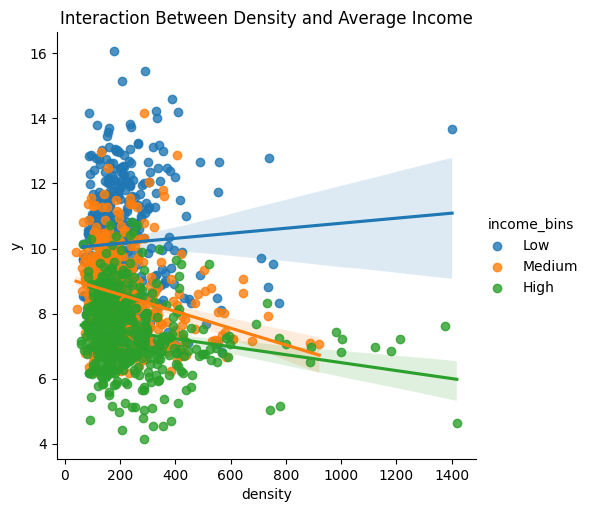

In [160]:
# Combine X and y into a single DataFrame
data_with_target = X.copy()
data_with_target['y'] = y  # Add the target variable as a new column

# Create bins for 'average income'
data_with_target['income_bins'] = pd.qcut(data_with_target['average income'], q=3, labels=['Low', 'Medium', 'High'])

# Plot the relationship between 'density' and 'y' across income levels
sns.lmplot(data=data_with_target, x='density', y='y', hue='income_bins', scatter=True)
plt.title("Interaction Between Density and Average Income")
plt.show()


Conclusion:

The lines for different income_bins indicate interaction:

* For low-income areas, grocery density has a slight positive effect.

* For medium-income areas, the effect is negative.

* For high-income areas, grocery density has a weaker negative effect.

## 5.5 Conclusion

* There is a significant interaction between grocery density and average income in their effect on diagnosed diabetes rate. This interaction suggests that:

    1. At lower average income, the negative effect of grocery density on diagnosed diabetes rate is more pronounced.

    2. At higher average income, the effect of grocery density on diagnosed diabetes rate diminishes, indicating a moderating effect of income.

# 6. Conclusion & Recommendation

## 6.1 Conclusion

### 6.1.1 Regression

* The R-squared for multiple regression shows that fit of the model is good and we could do the forward selection to add grocery density.
* The p-value shows that variables are not significant and other variables are.
* The coefficient for log average income and log grocery density is negative and others are positive, indicating the relationship between independent variables and dependent variables.
* Assumption violation still exists, normality could be roughly satisfied, but the rest could not be satisfied.

### 6.1.2 Tree Models

* We choose decision tree, random forest and XGBoost models. After comparing R-squared and MSE, we could generate conclusion that the performance of the random forest model here is the best.
* When checking the importance of the features, the importance for grocery density is too low.
* Thus we want to check the possibility of interaction between grocery density and average income.

### 6.1.3 Interaction 

* There is a strong interaction between grocery density and average income:

1. At lower average income, the negative effect of grocery density on mean rate of diagnosed diabetes rate is more pronounced.
2. At higher average income, the effect of density on mean rate of diagnosed diabetes rate diminishes, indicating a moderating effect of income.

* Grocery density should be considered as a predictor, especially when considering interaction effects with average income. However, it may not be a strong standalone predictor.

* Grocery density negatively affects mean rate of diagnosed diabetes rate, but its impact depends on income levels:

1. At low income levels, grocery density strongly reduces mean rate of diagnosed diabetes rate.
2. At high income levels, the negative effect of grocery density is mitigated, resulting in little to no impact on mean rate of diagnosed diabetes rate.

* Income moderates the effect of grocery density, highlighting the importance of interaction in understanding mean rate of diagnosed diabetes rate.

## 6.2 Recommendation

1. **Low Grocery Density in Low-Income Areas:**
   - **Problem:** The negative impact of low grocery density is amplified in low-income areas, leading to poorer outcomes for mean rate of diagnosed diabetes rate.
   - **Recommendation:** 
     - Invest in programs to increase grocery availability (e.g., subsidies for opening grocery stores in underserved areas).
     - Encourage local or community-based grocery initiatives (e.g., farmer's markets or food co-ops).

2. **Moderate Grocery Density in Medium-Income Areas:**
   - **Problem:** Grocery density has a less pronounced impact in medium-income areas but remains relevant for ensuring convenience and affordability.
   - **Recommendation:**
     - Focus on maintaining diversity and competition among grocery providers to improve accessibility and reduce costs.

3. **High Grocery Density in High-Income Areas:**
   - **Problem:** At higher income levels, the relationship between grocery density and mean rate of diagnosed diabetes rate diminishes, suggesting that income provides resilience against low grocery density.
   - **Recommendation:**
     - Support sustainable grocery density, avoiding oversaturation to prevent wastage or inefficient resource allocation.

